## Declare Model

In [5]:
import torch
import torch.nn as nn
from networks.model_utils import *

z_dim = 64

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, target_shape):
        super().__init__()
        self.target_shape = target_shape
        
    def forward(self, input):
        return torch.reshape(input, (input.size(0),*self.target_shape))


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        ndf = 16
        self.main = nn.Sequential(
#             nn.Linear(z_dim,64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(True),
            
            nn.Linear(64, 128),
            nn.ReLU(True),
            
            UnFlatten((ndf*8, 1, 1)),
            # state size. (ndf*8) x 1 x 1
            nn.ConvTranspose2d(ndf*8, ndf*8, 3, 1, 0),
            nn.BatchNorm2d(ndf*8),
            nn.ReLU(True),
            
            # state size. (ndf*8) x 3 x 3
            nn.ConvTranspose2d(ndf*8, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.ReLU(True),
            
            # state size. (ndf*4) x 6 x 6   
            nn.ConvTranspose2d(ndf*4, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.ReLU(True),

            # state size (ndf*2) x 12 x 12
            nn.ConvTranspose2d(ndf*2, ndf*1, 4, 2, 0),
            nn.BatchNorm2d(ndf*1),
            nn.ReLU(True),

            # state size (ndf) x 26, 26
            nn.ConvTranspose2d(ndf*1,2, 4, 2, 0),
            nn.BatchNorm2d(2),
            nn.ReLU(True),

            # state size 2 x 54 x 54
            nn.Conv2d(2,1, 4, 1, 0),
            nn.Sigmoid()
            # output 1 x 51 x 51              
        )

    def forward(self, input):
#         for layer in self.main:
#             input = layer(input)
#             print(input.shape)
#         return input
        return self.main(input)




class GANEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        architecture = {
            "conv_layers": 5,
            "conv_channels": [16, 32, 64, 128, 256],
            "conv_kernel_sizes": [(4, 4), (4, 4), (4, 4), (4,4), (4,4)],
            "conv_strides": [(1, 1), (2, 2), (1, 1), (2,2), (2,2)],
            "conv_paddings": [(1, 1), (1, 1), (1, 1), (1,1), (1,1)],
            "z_dimension": 64
        }
        input_shape = [1,51,51]
        self.main, self.output_shapes = create_encoder(architecture, input_shape)
        self.main.add_module('flatten',Flatten())
        encoded_shape = architecture['conv_channels'][-1]*np.prod(self.output_shapes[-1][:])
        self.main.add_module('lin_1', nn.Linear(encoded_shape, architecture['z_dimension']))
        def forward(self, input):
            return self.main(input)
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        ndf = 16
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 51 x 51
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 25 x 25
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 12 x 12
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 6 x 6
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 3 x 3
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            # state size. 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

    
class SNDiscriminator(nn.Module):
    ndf = 16
    def __init__(self):
        super(SNDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 51 x 51
            SNConv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 25 x 25
            SNConv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 12 x 12
            SNConv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 6 x 6
            SNConv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 3 x 3
            SNConv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            # state size. 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
 

## Data Loader

In [40]:
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
    
DEFAULT_ROOT = '/scratch/sagar/slf/train_set/2m_data/slf_mat'

class SLF(Dataset):
    def __init__(self, root=DEFAULT_ROOT, train=True, download=True, transform=None, total_data=None, sampling=False, normalize=False):
        self.root_dir = root
        self.train = train
        self.test_id = 0
        if not total_data is None:
            self.num_examples = total_data
        else:
            if train == True:
                self.num_examples = 1900000
            else:
                self.num_examples = 2000
                self.test_id = 1900000
        
        self.sampling = sampling
        sample_size = [0.01,0.30]
        self.sampling_rate = sample_size[1] - sample_size[0]
        self.omega_start_point = 1.0 - sample_size[1]
        self.normalize = normalize
        
    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        if self.train:
            filename = os.path.join(self.root_dir, str(idx)+'.pt')
        else:
            filename = os.path.join(self.root_dir, str(self.test_id + idx)+'.pt')
            
        sample = torch.load(filename)
        if self.sampling:
            rand = self.sampling_rate*torch.rand(1).item()
            bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
            int_mask = bool_mask*torch.ones((1,51,51), dtype=torch.float32)
            subsample = sample*bool_mask
            return subsample, sample
        
        if self.normalize:
            sample = np.log(sample)
            sample = sample/sample.min()
        return sample
    
def plot_image(train_set, index, log=False):
    a = train_set[index]
    if not log:
        plt.imshow(a.detach().squeeze().numpy())
    else:
        plt.imshow(np.log(a.detach().squeeze().numpy()))
        

def plot_image_output(image, log=False):
    if log:
        plt.imshow(np.log(image.detach().squeeze().numpy()))
    else:
        plt.imshow(image.detach().squeeze().numpy())
    
class GANSample(Dataset):
    def __init__(self, generator_path = 'trained-models/gan/generator-gan-first',train=True, download=True, transform=None, total_data=None, sampling=False):
        self.generator = torch.load(generator_path)
        self.generator.eval()
        self.generator = self.generator.to('cpu')
        self.z_dim = next(self.generator.parameters()).shape[1]
        if not total_data is None:
            self.num_examples = total_data
        else:
            if train == True:
                self.num_examples = 50000
            else:
                self.num_examples = 2000
        
        self.sampling = sampling
        sample_size = [0.01,0.30]
        self.sampling_rate = sample_size[1] - sample_size[0]
        self.omega_start_point = 1.0 - sample_size[1]
        
    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        z = torch.randn((1,self.z_dim), dtype=torch.float32)
        with torch.no_grad():
            sample = self.generator(z)
        z = z.squeeze()
        sample = sample.squeeze(dim=0)
        if self.sampling:
            rand = self.sampling_rate*torch.rand(1).item()
            bool_mask = torch.FloatTensor(1,51,51).uniform_() > (self.omega_start_point+rand)
            int_mask = bool_mask*torch.ones((1,51,51), dtype=torch.float32)
            subsample = sample*bool_mask
            subsample.requires_grad = False
            z.requires_grad = False
            return subsample, z
        else:
            return sample, z



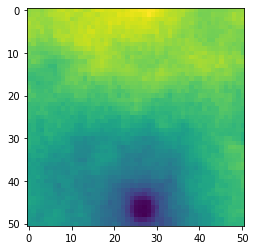

In [7]:
train_set = SLF(normalize=True)
import torch
plot_image(train_set, 3)

## Tune Hyperparamters for GAN

In [9]:
from collections import OrderedDict, namedtuple
import os
from run_manager_adv import RunBuilder, RunManager
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import pandas as pd
import torch.nn as nn
from networks.gan import SNDiscriminator
import torch

# DEFAULT_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'
DEFAULT_ROOT = '/scratch/sagar/slf/train_set/2m_data/'

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')

params = OrderedDict(
    d_lr = [0.0004],
    g_lr = [0.0001],
    batch_size = [128],
    device = devices,
    shuffle = [True],
    num_workers = [5], 
    normalize_data = [True]
)

m = RunManager(epoch_count_print=1)

real_label = 0.9
fake_label = 0

criterion = nn.BCELoss()
alpha = 0.0001
Tc = 0
Td = 0
T_train = 100

count=0
run_data = []

models = []
for run in RunBuilder.get_runs(params):
    device = torch.device(run.device)
    generator = Generator().to(run.device)
    discriminator = SNDiscriminator().to(run.device)

    train_set = SLF(root=os.path.join(DEFAULT_ROOT, 'slf_mat'), normalize = run.normalize_data,)
    
    loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle, num_workers=run.num_workers)
    optimizerGenerator = torch.optim.Adam(generator.parameters(), lr=run.g_lr)
    optimizerDiscriminator = torch.optim.Adam(discriminator.parameters(), lr=run.d_lr)
        
    for epoch in range(25):

        total_adv_loss = 0
 
        real_count = 0
        fake_count = 0
        
        total_D_real = 0
        total_D_fake = 0
        
        total_D_loss = 0
        total_G_loss = 0
        
        num_batches = len(train_set)/run.batch_size
        i = 0
        for batch in tqdm(loader):
            i += 1
            # Get data
            real_slf = batch
            real_slf = real_slf.to(run.device)
            
            b_size = real_slf.size(0)
            labels_real = torch.full((b_size,1,1,1), real_label, device=run.device, dtype=torch.float32)
            labels_fake = torch.full((b_size,1,1,1), fake_label, device=run.device, dtype=torch.float32)
            
            sample_z = torch.randn((b_size, z_dim), dtype=torch.float32)
            sample_z = sample_z.to(run.device)
            
            # Update Generator
            if i%2 != 0:
                optimizerGenerator.zero_grad()
               
                fake_slf = generator(sample_z)
                fake_pred = discriminator(fake_slf)
                gen_loss = criterion(fake_pred, labels_real)
                gen_loss.backward()
                optimizerGenerator.step()
            
            # Update Discriminator
            optimizerDiscriminator.zero_grad()
            fake_slf = generator(sample_z)
            real_loss = criterion(discriminator(real_slf), labels_real)
            fake_loss = criterion(discriminator(fake_slf), labels_fake)
            d_loss = 0.5*(real_loss + fake_loss)
            d_loss.backward()
            optimizerDiscriminator.step()
            
            total_D_real += real_loss.item()
            total_D_fake += fake_loss.item()
        
            total_D_loss += d_loss.item()
            total_G_loss += gen_loss.item()

            
        results = OrderedDict()
        results['G_loss'] = total_G_loss/num_batches
        results['D_loss'] = total_D_loss/num_batches
        results['d_lr'] = run.d_lr
        results['g_lr'] = run.g_lr
        results['batch_size'] = [run.batch_size]
        results['normalize'] = run.normalize_data
        run_data.append(results)
        df = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    df.to_pickle('trained-models/gan/table_performance/performance_spectral_norm')
    models.append(generator)
    torch.save(generator, 'trained-models/gan/sn1_g_lr_{}_d_lr_{}_normalize_{}'.format(run.g_lr,run.d_lr, run.normalize_data))
    m.end_run()

,G_loss,D_loss,d_lr,g_lr,batch_size,normalize
0,6.327331,0.170085,0.0004,0.0001,[128],True
1,5.937904,0.170572,0.0004,0.0001,[128],True
2,6.113786,0.169689,0.0004,0.0001,[128],True
3,5.591667,0.172550,0.0004,0.0001,[128],True
4,5.133491,0.175473,0.0004,0.0001,[128],True
5,4.294399,0.185791,0.0004,0.0001,[128],True
6,3.776014,0.197582,0.0004,0.0001,[128],True
7,3.569165,0.203717,0.0004,0.0001,[128],True
8,3.638640,0.205142,0.0004,0.0001,[128],True
9,3.655009,0.208127,0.0004,0.0001,[128],True


In [56]:
MODEL_PATH_GEN = 'trained-models/gan/gen'
MODEL_PATH_DIS = 'trained-models/gan/dis3'
torch.save({'epoch': epoch, 
                    'model_state_dict': generator.state_dict(), 
                    'optimizer_state_dict': optimizerGenerator.state_dict(),
                    'loss': results['G_loss'],
                    'lr': run.d_lr},
                    MODEL_PATH_GEN)

In [57]:
gen = Generator()
checkpoint = torch.load(MODEL_PATH_GEN)
gen.load_state_dict(checkpoint['model_state_dict'])
save_epoch = checkpoint['epoch']

In [47]:
MODEL_PATH_GAN = 'trained-models/gan/sngan2'

torch.save({'epoch': epoch, 
            'g_model_state_dict': generator.state_dict(),
            'd_model_state_dict': discriminator.state_dict(),
            'optimizerG_state_dict': optimizerGenerator.state_dict(),
            'optimizerD_state_dict': optimizerDiscriminator.state_dict(),
            'G_loss': results['G_loss'],
            'D_loss': results['D_loss'],
            },
            MODEL_PATH_GAN)  

In [54]:
torch.save(discriminator, 'trained-models/gan/sn1_discrim_g_lr_{}_d_lr_{}_normalize_{}'.format(run.g_lr,run.d_lr, run.normalize_data))


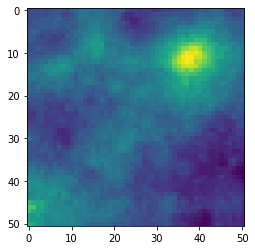

In [38]:


# generator = torch.load('trained-models/gan/gen2_lr_0.0001_d_lr_0.0004_normalize_True')
# generator = models[0]
# generator.eval()
# generator = generator.to('cpu')
generator.eval()
gen = generator.to('cpu')

a = torch.randn((1,64), dtype=torch.float32)
out = gen(a)
plot_image_output(-out, log=False)

## Tune Hyperparameters for Encoder before GAN

In [325]:
from collections import OrderedDict, namedtuple
import os
from run_manager_adv import RunBuilder, RunManager
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import pandas as pd

DEFAULT_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')

params = OrderedDict(
    lr = [0.0001],
    batch_size = [32],
    device = devices,
    shuffle = [True],
    num_workers = [1]
)
GAN_path = 'trained-models/gan/generator-gan-first'

train_set = GANSample(GAN_path, total_data=500000, sampling=True)

m = RunManager(epoch_count_print=1)

criterion = nn.MSELoss()
run_data = []

data_load_time = time.time()
forward_time = time.time()
for run in RunBuilder.get_runs(params):
    device = torch.device(run.device)
    encoder = GANEncoder().to(run.device)
    loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle, num_workers = 5)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=run.lr)
        
    for epoch in range(10):
        
        total_loss = 0
        num_batches = len(train_set)/run.batch_size
        
        for batch in tqdm(loader):
            # Get data
            sample, true_label = batch
            sample = sample.to(run.device)
            true_label = true_label.to(run.device)
#             print('data load time:{}'.format(time.time()-data_load_time))
            # Update Encoder parameters
#             forward_time = time.time()
            optimizer.zero_grad()

            output = encoder(sample)
            loss = criterion(output, true_label)
            loss.backward()
            print(loss.item())
            optimizer.step()
#             print('forward_time =', time.time()-forward_time)
            total_loss += loss.item()
#             data_load_time = time.time()
            
            
        results = OrderedDict()
        results['loss'] = total_loss/num_batches
        results['lr'] = run.lr
        results['batch_size'] = [run.batch_size]
        run_data.append(results)
        df = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df)
        
    m.end_run()

  0%|          | 0/15625 [00:00<?, ?it/s]

starting


  0%|          | 7/15625 [00:00<14:59, 17.37it/s]  

1.2942736148834229
1.2792531251907349
1.2538325786590576
1.300809383392334
1.2491551637649536
1.3185405731201172
1.3362056016921997
1.3157709836959839
1.2646838426589966
1.2686610221862793
1.17344069480896
1.2445380687713623
1.2395656108856201


  0%|          | 25/15625 [00:00<05:03, 51.43it/s]

1.2420839071273804
1.2218281030654907
1.2418193817138672
1.2093915939331055
1.2409744262695312
1.2262907028198242
1.2060301303863525
1.1770578622817993
1.1978988647460938
1.2322711944580078
1.2357032299041748
1.2404040098190308
1.247361183166504
1.2655274868011475
1.1990231275558472
1.2279257774353027
1.2101548910140991
1.2167823314666748
1.2398951053619385


  0%|          | 46/15625 [00:00<03:24, 76.01it/s]

1.2231985330581665
1.1826164722442627
1.2431374788284302
1.1476247310638428
1.2319551706314087
1.2537617683410645
1.2486340999603271
1.1681926250457764
1.1624622344970703
1.1561940908432007
1.1311872005462646
1.2330187559127808
1.153343677520752
1.1433660984039307
1.2046259641647339
1.271921157836914
1.1444296836853027
1.1485512256622314
1.2376571893692017
1.1461975574493408
1.2005871534347534


  0%|          | 68/15625 [00:01<02:55, 88.82it/s]

1.1270020008087158
1.2125414609909058
1.132534146308899
1.16127347946167
1.2447094917297363
1.2007182836532593
1.1269006729125977
1.0764198303222656
1.1590619087219238
1.1251354217529297
1.1368532180786133
1.1367818117141724
1.1298785209655762
1.1157927513122559
1.0965423583984375
1.1894183158874512
1.1257375478744507
1.1737929582595825
1.117541790008545
1.1543774604797363
1.1476911306381226


  1%|          | 89/15625 [00:01<02:43, 94.79it/s]

1.157837152481079
1.1170272827148438
1.0971182584762573
1.148057222366333
1.1140897274017334
1.1940045356750488
1.0907987356185913
1.1405184268951416
1.1252150535583496
1.1510558128356934
1.1291478872299194
1.1613106727600098
1.1461155414581299
1.1264770030975342
1.0898950099945068
1.1168930530548096
1.1053951978683472
1.1547958850860596
1.1665680408477783


  1%|          | 109/15625 [00:01<02:51, 90.47it/s]

1.1113717555999756
1.1387286186218262
1.1300859451293945
1.0784759521484375
1.0877330303192139
1.0909544229507446
1.1122822761535645
1.0582612752914429
1.1190617084503174
1.1542093753814697
1.0729517936706543
1.12257719039917
1.12696373462677
1.0717731714248657
1.1220548152923584
1.0712895393371582
1.1577314138412476
1.090224027633667
1.1414787769317627
1.0973156690597534


  1%|          | 131/15625 [00:01<02:38, 97.82it/s]

1.0346271991729736
1.1080057621002197
1.122069001197815
1.085669994354248
1.1061677932739258
1.1074936389923096
1.114973783493042
1.0827445983886719
1.1210644245147705
1.100020170211792
1.105717420578003
1.1742751598358154
1.1536509990692139
1.0702580213546753
1.1535621881484985
1.150956630706787
1.1010289192199707
1.1230273246765137
1.126457929611206
1.1286659240722656
1.1281310319900513
1.1222569942474365


  1%|          | 153/15625 [00:02<02:32, 101.39it/s]

1.0759191513061523
1.0364279747009277
1.0612914562225342
1.1157984733581543
1.1061241626739502
1.090463638305664
1.1483291387557983
1.139831781387329
1.0640382766723633
1.0651307106018066
1.0694609880447388
1.0912706851959229
1.028289556503296
1.0300796031951904
1.0849192142486572
1.1024534702301025
1.1036255359649658
1.0365058183670044
1.0909684896469116
1.1330592632293701
1.1258437633514404


  1%|          | 175/15625 [00:02<02:29, 103.03it/s]

1.0753779411315918
1.0344998836517334
1.0883967876434326
1.1360077857971191
1.0699799060821533
1.0585052967071533
1.112177848815918
1.207765817642212
1.1177263259887695
1.1873207092285156
1.1033971309661865
1.033111572265625
1.0764820575714111
1.1050634384155273
1.0935434103012085
1.0764477252960205
1.0794100761413574
1.117478370666504
1.0271332263946533
1.112906575202942
1.0694866180419922
1.0906246900558472


  1%|          | 186/15625 [00:02<02:28, 103.89it/s]

1.091741919517517
1.048086404800415
1.0690391063690186
1.1433484554290771
1.0645002126693726
1.0989481210708618
1.050913691520691
1.077158808708191
1.1142332553863525
1.0106921195983887
1.1349701881408691
1.0722970962524414
1.096695899963379
1.031930685043335
1.0458457469940186
1.09488844871521
1.0694961547851562
1.1027673482894897


  1%|▏         | 207/15625 [00:02<02:51, 89.94it/s] 

1.0491336584091187
1.0685499906539917
1.0632810592651367
1.1126229763031006
1.0745761394500732
1.0669105052947998
1.0813977718353271
1.0852689743041992
1.1124675273895264
1.001203179359436
1.0683374404907227
1.196684718132019
1.0179821252822876
1.0134167671203613
1.0782419443130493
1.0466803312301636
1.1038166284561157
1.0478453636169434


  1%|▏         | 229/15625 [00:02<02:44, 93.38it/s]

1.0522522926330566
1.0497891902923584
1.0700619220733643
1.0929467678070068
1.0727686882019043
1.0826202630996704
1.1091313362121582
1.1208631992340088
1.0801879167556763
1.1255857944488525
1.066678762435913
1.0393807888031006
1.0162279605865479
1.038987159729004
1.0543550252914429
1.133120059967041
1.048971176147461
1.0644526481628418


  2%|▏         | 249/15625 [00:03<02:53, 88.87it/s]

1.1092383861541748
1.126408576965332
1.058034062385559
1.1106932163238525
1.066875696182251
1.0068674087524414
1.0383191108703613
1.125126600265503
1.0829826593399048
1.0806037187576294
1.0631554126739502
1.104195237159729
1.070340871810913
1.0854830741882324
1.1238274574279785
1.058821678161621
1.0591853857040405
1.0840452909469604


  2%|▏         | 269/15625 [00:03<02:44, 93.55it/s]

1.0822012424468994
1.0673739910125732
1.0508229732513428
1.0166964530944824
1.0722204446792603
1.1065785884857178
1.1288056373596191
1.0325531959533691
1.077513337135315
1.095499038696289
1.0952155590057373
1.0951437950134277
1.0327589511871338
1.0761635303497314
1.096343755722046
1.0350024700164795
1.0931463241577148
1.0804688930511475
1.0642592906951904
1.028342366218567


  2%|▏         | 279/15625 [00:03<02:41, 94.94it/s]

1.059414029121399
1.0607913732528687
1.0076669454574585
1.0822008848190308
1.0873346328735352
1.0453448295593262
1.0339906215667725
1.0536127090454102
1.0671277046203613
1.0143842697143555
1.0585461854934692
1.040236473083496
1.0895437002182007
1.0346890687942505
1.0551105737686157
1.0586601495742798
1.1319981813430786


  2%|▏         | 298/15625 [00:03<02:59, 85.20it/s]

1.0911279916763306
1.100183367729187
1.0434458255767822
1.0010019540786743
1.0733435153961182
1.051698923110962
1.1146798133850098
1.0257859230041504
1.0662376880645752
1.103008508682251
1.1382453441619873
1.004638671875
1.1137973070144653
1.0791025161743164
1.0412055253982544
0.9922913312911987
1.0595815181732178
1.0178050994873047


  2%|▏         | 318/15625 [00:03<02:50, 89.90it/s]

1.0905988216400146
1.0987826585769653
1.0798711776733398
1.0906448364257812
1.047379493713379
1.0911918878555298
1.1023578643798828
1.0858519077301025
1.068069338798523
1.0874601602554321
1.129276990890503
1.011566400527954
1.0359822511672974
1.0557239055633545
1.0833702087402344
1.0652413368225098
1.0570106506347656
1.0187056064605713
1.0510355234146118
1.1124365329742432


  2%|▏         | 338/15625 [00:04<02:43, 93.30it/s]

1.0620349645614624
1.050307273864746
1.1359513998031616
1.0455124378204346
1.098924160003662
1.061242938041687
1.097095012664795
1.036317229270935
1.0624828338623047
1.0836613178253174
1.0599055290222168
1.033074140548706
1.0879991054534912
1.1308677196502686
1.0998632907867432
1.058007001876831
1.1972075700759888
1.0195441246032715
1.0610909461975098
1.0687463283538818


  2%|▏         | 359/15625 [00:04<02:39, 95.77it/s]

1.0874351263046265
1.0666234493255615
1.032787561416626
1.0581045150756836
1.0915167331695557
1.072450876235962
1.020601511001587
1.0773141384124756
1.106169581413269
1.0731780529022217
1.0839564800262451
1.0617667436599731
1.0729756355285645
1.057780146598816
1.1052937507629395
1.0821242332458496
1.0722272396087646
1.065737009048462
0.9941753149032593
1.1179828643798828


  2%|▏         | 379/15625 [00:04<02:38, 95.98it/s]

1.0737528800964355
1.1393465995788574
1.0069854259490967
1.0730373859405518
1.0483322143554688
1.0837111473083496
1.0796539783477783
1.0627487897872925
1.0682330131530762
1.0715973377227783
1.1258373260498047
1.0761518478393555
1.1610419750213623
1.0752925872802734
1.0380265712738037
1.0900318622589111
1.0606728792190552
1.0745528936386108
1.0956048965454102
1.1077828407287598


  3%|▎         | 399/15625 [00:04<02:39, 95.26it/s]

1.0508501529693604
1.1068085432052612
1.0946273803710938
1.028635025024414
1.0777204036712646
1.069381594657898
1.0168657302856445
1.0444414615631104
1.0673545598983765
1.0842914581298828
1.0519773960113525
1.067798376083374
1.0821797847747803
1.055753231048584
1.0834102630615234
1.0092369318008423
1.0562090873718262
1.0774078369140625
1.0386030673980713


  3%|▎         | 419/15625 [00:04<02:38, 96.21it/s]

1.0840458869934082
1.0762985944747925
1.1088767051696777
1.0753999948501587
1.139892339706421
1.0266783237457275
1.1158421039581299
1.084953784942627
1.085242748260498
1.0241940021514893
1.0653589963912964
1.0654056072235107
1.0334479808807373
1.1083210706710815
1.1064342260360718
1.081344723701477
1.0535982847213745
1.0117384195327759
1.058902382850647
1.0532617568969727


  3%|▎         | 439/15625 [00:05<02:36, 97.25it/s]

1.0616130828857422
1.0940371751785278
1.0822618007659912
1.0531630516052246
1.0960605144500732
1.0903030633926392
1.0915600061416626
1.0585123300552368
1.100306510925293
1.1056808233261108
1.1049922704696655
1.0565255880355835
1.045989990234375
1.090477705001831
1.030646562576294
1.118201494216919
1.0631952285766602
1.1701606512069702
1.1032087802886963
0.9380984902381897


  3%|▎         | 459/15625 [00:05<02:35, 97.47it/s]

1.0345484018325806
1.049821376800537
1.1364518404006958
1.071414589881897
1.0573821067810059
1.0091564655303955
1.0418553352355957
1.0338454246520996
1.0446479320526123
1.0313444137573242
1.1051664352416992
1.0657434463500977
1.0641310214996338
1.1052169799804688
1.0995051860809326
1.0729296207427979
1.086092233657837
1.0615153312683105
1.0800055265426636
1.0539031028747559
1.1274453401565552


  3%|▎         | 479/15625 [00:05<02:34, 98.04it/s]

1.0646238327026367
1.0330514907836914
1.0621681213378906
1.0626776218414307
1.0705511569976807
1.0304908752441406
1.0254662036895752
1.096083402633667
1.0683379173278809
1.1375973224639893
1.044832468032837
1.0972158908843994
1.1238486766815186
1.1354327201843262
1.082383394241333
1.0869815349578857
1.0215377807617188
1.0642515420913696
1.0767884254455566
1.0091552734375


  3%|▎         | 500/15625 [00:05<02:33, 98.83it/s]

1.0606772899627686
1.0660830736160278
1.0639722347259521
1.065430998802185
1.0331745147705078
1.0849827527999878
1.0060272216796875
1.0472124814987183
1.1086292266845703
1.0866533517837524
1.0441381931304932
1.0540177822113037
0.99696946144104
1.1284470558166504
1.0733071565628052
1.0208029747009277
1.0665507316589355
1.0636186599731445
1.0869649648666382
1.1083941459655762
1.1007660627365112


  3%|▎         | 521/15625 [00:05<02:31, 99.53it/s]

1.0952401161193848
1.065009355545044
1.078395128250122
1.0525081157684326
1.028074026107788
1.088020920753479
1.0483832359313965
1.111943006515503
1.0258419513702393
1.0046632289886475
1.1143485307693481
1.084425449371338
1.0552525520324707
1.0770249366760254
1.05295991897583
1.0940420627593994
1.0513229370117188
1.0842567682266235
1.1047426462173462
1.1039254665374756


  3%|▎         | 541/15625 [00:06<02:33, 98.52it/s]

1.052472710609436
1.0794811248779297
1.0475077629089355
1.0929697751998901
1.0784060955047607
1.0448836088180542
1.068560004234314
1.020994782447815
1.092909336090088
1.1063101291656494
1.066145896911621
1.0863230228424072
1.0523924827575684
1.0747981071472168
1.0975112915039062
1.0819995403289795
1.0496670007705688
1.0330743789672852
1.073989748954773
1.0536105632781982


  4%|▎         | 562/15625 [00:06<02:32, 98.54it/s]

1.0999513864517212
1.090669870376587
1.0838994979858398
1.048642635345459
1.0535883903503418
1.0520973205566406
1.0479596853256226
1.0572396516799927
1.049704670906067
1.1539493799209595
1.0662009716033936
1.0673487186431885
1.052764654159546
1.0748772621154785
1.0563158988952637
1.0583138465881348
1.048953890800476
1.0838775634765625
1.0521888732910156
1.0756977796554565
1.1406400203704834


  4%|▎         | 582/15625 [00:06<02:32, 98.52it/s]

1.0682536363601685
1.0631976127624512
1.0409008264541626
1.0261521339416504
1.0752878189086914
1.1771814823150635
1.0510648488998413
1.0778579711914062
1.0483582019805908
1.0432965755462646
1.0350703001022339
1.049109697341919
0.9991215467453003
1.0392308235168457
1.055332064628601
1.0523173809051514
1.0683701038360596
1.1018524169921875
1.0830023288726807
0.9951224327087402


  4%|▍         | 602/15625 [00:06<02:33, 97.77it/s]

1.0262809991836548
1.08017897605896
1.0487923622131348
1.0467109680175781
1.0020240545272827
1.0700962543487549
1.1077512502670288
1.0900235176086426
1.0368006229400635
1.0942955017089844
1.0059256553649902
1.100574016571045
1.038944959640503
1.0487953424453735
1.0255380868911743
1.067387342453003
1.020231008529663
1.0843894481658936
1.0618919134140015
1.0745923519134521


  4%|▍         | 623/15625 [00:06<02:32, 98.18it/s]

1.0571906566619873
1.0492267608642578
1.1195464134216309
1.0748989582061768
1.0761909484863281
1.0563039779663086
1.0262422561645508
1.1396595239639282
1.052161693572998
1.1360445022583008
1.020308256149292
1.0824509859085083
1.0429311990737915
1.0819777250289917
1.0688599348068237
1.0300822257995605
1.0281562805175781
1.0262633562088013
1.136988639831543
1.0343129634857178


  4%|▍         | 644/15625 [00:07<02:30, 99.23it/s]

1.0037312507629395
1.0563853979110718
1.0383553504943848
1.1493754386901855
1.0325571298599243
1.0430350303649902
1.032935380935669
1.0268837213516235
1.107722520828247
1.0745569467544556
1.1055552959442139
1.01106595993042
1.0344061851501465
1.0067946910858154
1.0519719123840332
1.0475800037384033
1.0609657764434814
1.0991932153701782
1.1260262727737427
1.0408008098602295
1.112497091293335


  4%|▍         | 666/15625 [00:07<02:30, 99.62it/s] 

1.0085914134979248
1.0860822200775146
1.0461260080337524
1.0569045543670654
1.091292142868042
1.0355544090270996
1.076810598373413
1.073996663093567
1.0412029027938843
1.0714831352233887
1.068533182144165
1.0821934938430786
1.0417494773864746
1.0297560691833496
1.0618282556533813
1.0359885692596436
1.0263211727142334
1.0732852220535278
1.068070888519287
1.0674262046813965
1.0739678144454956


  4%|▍         | 686/15625 [00:07<02:31, 98.45it/s]

1.0696223974227905
1.0563082695007324
1.0304477214813232
1.0291416645050049
1.0588181018829346
1.0786387920379639
1.039865255355835
0.9969764947891235
0.9867491722106934
1.0578045845031738
1.0202516317367554
1.0153157711029053
1.080909013748169
1.0959992408752441
1.1272019147872925
1.0325121879577637
1.0353941917419434
1.0597503185272217
1.0864988565444946
0.9915525317192078


  5%|▍         | 707/15625 [00:07<02:30, 98.84it/s]

1.0560780763626099
1.059554934501648
1.0108455419540405
1.057021975517273
1.0277036428451538
1.0494248867034912
1.1220695972442627
1.117154598236084
1.1275575160980225
1.062566876411438
1.1092114448547363
1.0177361965179443
1.0831913948059082
1.0222512483596802
1.0688947439193726
1.120314598083496
1.0379664897918701
1.0900113582611084
1.136969804763794
1.0322861671447754
1.019103765487671


  5%|▍         | 728/15625 [00:08<02:33, 97.22it/s]

1.1244145631790161
1.1192796230316162
1.0772624015808105
1.0714752674102783
1.049521803855896
1.084808349609375
1.050676941871643
1.0766425132751465
1.0502632856369019
1.1080962419509888
1.0990946292877197
1.069378137588501
1.0523477792739868
1.0554097890853882
1.112847089767456
1.0525383949279785
1.0736594200134277
1.027898907661438
1.096312403678894
1.0335841178894043


  5%|▍         | 748/15625 [00:08<02:31, 98.06it/s]

1.1220011711120605
1.0629117488861084
1.0412845611572266
1.0229110717773438
1.0937693119049072
1.061201572418213
1.0477328300476074
1.0357753038406372
1.0891706943511963
0.9950918555259705
1.0492792129516602
1.0881297588348389
1.105300784111023
1.0646252632141113
1.0848708152770996
1.037349820137024
1.0633631944656372
1.0271393060684204
1.0510481595993042
1.0982255935668945
1.0615520477294922


  5%|▍         | 768/15625 [00:08<02:30, 98.79it/s]

1.0852106809616089
1.0380926132202148
1.101189136505127
1.001651644706726
1.1021339893341064
0.9989066123962402
1.0698704719543457
1.059680700302124
1.0528103113174438
1.1038368940353394
1.0898102521896362
1.0407724380493164
1.0424585342407227
1.0428659915924072
1.0566492080688477
1.0029640197753906
1.0289313793182373
1.1011316776275635
1.0331032276153564
1.0452699661254883


  5%|▌         | 788/15625 [00:08<02:29, 99.04it/s]

1.1073392629623413
1.0647249221801758
1.0420100688934326
1.062192440032959
1.099787712097168
1.0692288875579834
1.0967414379119873
1.0045690536499023
1.0018374919891357
1.018940806388855
1.0610682964324951
1.0304226875305176
1.059253454208374
1.0619404315948486
1.0682384967803955
1.1084061861038208
1.024870753288269
1.0260205268859863
1.100783348083496
1.0434430837631226
1.0638222694396973


  5%|▌         | 808/15625 [00:08<02:31, 97.74it/s]

1.1311454772949219
1.0310165882110596
1.0781853199005127
1.0724024772644043
1.0809987783432007
1.0665571689605713
1.0576975345611572
1.0454102754592896
1.064720869064331
1.0715031623840332
1.1566749811172485
1.0846338272094727
1.0373940467834473
1.0738022327423096
1.0106937885284424
1.1005336046218872
1.0337677001953125
1.091923713684082
1.106909990310669
1.0809829235076904


  5%|▌         | 828/15625 [00:09<02:30, 98.11it/s]

1.0480767488479614
1.0585649013519287
1.0703953504562378
1.0581117868423462
1.1111730337142944
1.0551000833511353
1.0961140394210815
1.0556076765060425
1.1372730731964111
1.095078945159912
1.0199514627456665
1.0344321727752686
1.084364652633667
1.093711495399475
1.0402958393096924
1.0676071643829346
1.0573339462280273
1.1137068271636963
1.0956389904022217
1.025355339050293


  5%|▌         | 848/15625 [00:09<02:31, 97.69it/s]

1.0748916864395142
1.0884796380996704
1.0830340385437012
1.0914801359176636
1.1021769046783447
1.1153639554977417
1.0782577991485596
1.0310708284378052
1.0000118017196655
1.0416326522827148
1.0728614330291748
1.0870873928070068
1.0256034135818481
0.9843425750732422
1.0589885711669922
1.0265889167785645
1.0788207054138184
1.0651330947875977
1.089896321296692
1.0970866680145264


  6%|▌         | 868/15625 [00:09<02:30, 97.73it/s]

1.0723063945770264
1.072717308998108
1.05552077293396
1.0253822803497314
1.0563312768936157
1.0579285621643066
0.9736303687095642
1.061198353767395
1.0070335865020752
1.019049882888794
1.0944762229919434
1.0708650350570679
1.0574538707733154
1.0418535470962524
0.9903548955917358
1.069610834121704
1.0256712436676025
1.0772173404693604
1.0348047018051147
1.05997633934021


  6%|▌         | 888/15625 [00:09<02:30, 97.99it/s]

1.0071933269500732
1.0522127151489258
0.9663875699043274
1.0770859718322754
1.0291748046875
1.0162416696548462
1.0404529571533203
1.0309135913848877
1.063652515411377
1.0607640743255615
1.111786961555481
1.1290018558502197
1.017126441001892
1.0665594339370728
0.996204137802124
1.0163018703460693
1.0515755414962769
1.0848877429962158
1.0705490112304688
1.055708408355713


  6%|▌         | 909/15625 [00:09<02:28, 98.83it/s]

0.9919351935386658
1.0527143478393555
1.0345244407653809
1.122413992881775
1.002732753753662
1.0431492328643799
0.9996846914291382
1.061995267868042
1.0939528942108154
1.0840511322021484
1.0269975662231445
1.061337947845459
0.9968891143798828
1.033766746520996
1.039665937423706
1.094285011291504
1.0777829885482788
1.0985347032546997
1.0170762538909912
1.028785228729248
1.0194311141967773


  6%|▌         | 930/15625 [00:10<02:27, 99.53it/s]

1.0786335468292236
1.0508794784545898
1.0813554525375366
1.1291239261627197
1.0840184688568115
1.0726464986801147
1.066638708114624
1.09355628490448
1.0650790929794312
1.089388370513916
1.0266284942626953
1.0109132528305054
1.127327799797058
1.0981130599975586
1.1315319538116455
1.0553337335586548
1.0911986827850342
1.0531567335128784
1.0462448596954346
0.9887523055076599
1.056178092956543


  6%|▌         | 950/15625 [00:10<02:28, 98.76it/s]

1.0638089179992676
1.0663601160049438
1.053940773010254
1.0749154090881348
1.0751869678497314
1.0755584239959717
1.0495703220367432
1.0361170768737793
1.0156463384628296
1.061361312866211
1.0713307857513428
1.0568830966949463
1.0557539463043213
1.027296781539917
1.0276108980178833
1.0714970827102661
1.0728174448013306
1.0411744117736816
1.0181361436843872
1.0557630062103271


  6%|▌         | 970/15625 [00:10<02:28, 98.82it/s]

1.0894103050231934
1.0728005170822144
1.048902988433838
1.0498411655426025
1.0683050155639648
1.0459550619125366
1.0567936897277832
1.037097692489624
1.0394887924194336
1.0411653518676758
1.029488444328308
1.098258137702942
1.0540589094161987
1.0514755249023438
1.0256117582321167
1.0581142902374268
1.0475631952285767
1.0467288494110107
1.0410575866699219
1.0411429405212402


  6%|▋         | 990/15625 [00:10<02:27, 99.10it/s]

1.0758066177368164
1.036760687828064
1.0070264339447021
1.0877889394760132
1.0229088068008423
1.0701711177825928
1.068983793258667
1.066634178161621
1.0226085186004639
1.048035740852356
1.0495234727859497
1.084514856338501
1.0698907375335693
1.067688226699829
1.105884075164795
1.1608012914657593
1.0388445854187012
1.038211464881897
1.0274057388305664
1.0551791191101074


  6%|▋         | 1010/15625 [00:10<02:30, 96.89it/s]

1.0495582818984985
1.0520858764648438
1.052355170249939
1.086287021636963
1.085132360458374
1.0617049932479858
1.0542126893997192
1.1084471940994263
1.0454260110855103
1.0618164539337158
1.0453617572784424
1.0931578874588013
1.0326582193374634
1.0513837337493896
1.0388586521148682
0.9728325605392456
1.0454542636871338
1.0820622444152832
1.0717816352844238
1.0594147443771362


  7%|▋         | 1031/15625 [00:11<02:28, 98.32it/s]

1.0711435079574585
1.0254217386245728
1.1313438415527344
1.0568674802780151
1.0720304250717163
1.098691701889038
1.0690903663635254
1.0106706619262695
1.1466904878616333
1.0568698644638062
1.0452264547348022
1.1331419944763184
0.9781642556190491
1.1500132083892822
1.0891096591949463
1.0280648469924927
1.0716350078582764
1.0168941020965576
1.1138583421707153
1.0262216329574585
1.1462764739990234


  7%|▋         | 1051/15625 [00:11<02:27, 98.90it/s]

1.0464377403259277
1.0516743659973145
1.1094011068344116
1.1014225482940674
1.059159517288208
1.0695899724960327
1.0796669721603394
1.038248896598816
1.0896871089935303
1.0500298738479614
1.0308778285980225
1.0227546691894531
0.9809379577636719
1.0405266284942627
1.1244053840637207
1.078012228012085
1.0739554166793823
1.0264949798583984
1.0636813640594482
1.061138391494751
1.1029438972473145


  7%|▋         | 1071/15625 [00:11<02:28, 97.75it/s]

1.0739809274673462
1.0453710556030273
1.0358672142028809
1.0675702095031738
1.1179542541503906
1.049559473991394
1.0714846849441528
1.0665018558502197
1.1273995637893677
1.0742011070251465
1.1210072040557861
1.126554012298584
1.0358264446258545
1.0574707984924316
1.0675609111785889
1.0228097438812256
1.060379147529602
1.0424113273620605
1.1089842319488525
1.0720027685165405


  7%|▋         | 1091/15625 [00:11<02:27, 98.68it/s]

1.0981180667877197
1.038597822189331
1.0182331800460815
1.0487608909606934
1.084406852722168
1.116415023803711
1.0557513236999512
1.0231224298477173
1.0190682411193848
1.1448819637298584
1.053049087524414
1.036354422569275
1.04853093624115
1.0867576599121094
1.1103436946868896
1.094374418258667
1.0823442935943604
1.1485488414764404
1.0392286777496338
1.0320292711257935
1.0853495597839355


  7%|▋         | 1112/15625 [00:11<02:27, 98.31it/s]

1.0343327522277832
1.0557721853256226
1.045529842376709
1.0150859355926514
1.1064579486846924
1.0656192302703857
1.0330119132995605
1.1173276901245117
1.0625123977661133
1.0673131942749023
0.9812581539154053
1.003279209136963
1.0681825876235962
1.0321112871170044
1.0575348138809204
1.0904433727264404
1.0618895292282104
1.0368882417678833
1.0627381801605225
1.0363253355026245


  7%|▋         | 1132/15625 [00:12<02:29, 96.74it/s]

1.0568335056304932
1.0619003772735596
1.1052894592285156
1.0530288219451904
1.0369765758514404
1.0338191986083984
1.069106101989746
0.9539556503295898
1.0837619304656982
1.1102709770202637
1.0413532257080078
1.047397494316101
1.0433292388916016
1.078484296798706
1.080486536026001
1.0224599838256836
1.101242184638977
1.048110008239746
1.097097635269165
1.0539911985397339


  7%|▋         | 1152/15625 [00:12<02:27, 97.81it/s]

1.074026107788086
1.085329532623291
1.0736877918243408
1.094257116317749
1.0242657661437988
1.053794264793396
1.0066437721252441
1.0600286722183228
1.0799400806427002
1.1053640842437744
1.1052601337432861
1.071215271949768
0.9970746636390686
1.1011595726013184
1.1180819272994995
1.0633389949798584
1.0520703792572021
1.0953460931777954
1.045547604560852
1.0679802894592285


  8%|▊         | 1172/15625 [00:12<02:27, 97.78it/s]

1.0471625328063965
1.04050612449646
1.0638662576675415
0.9797024726867676
1.0697081089019775
1.0475845336914062
1.1058461666107178
1.041916847229004
1.0833923816680908
1.0404139757156372
1.1064348220825195
1.0927629470825195
1.1114915609359741
1.0446736812591553
1.0149173736572266
1.069495439529419
1.0420647859573364
1.074638843536377
1.0913716554641724
1.0058724880218506


  8%|▊         | 1193/15625 [00:12<02:37, 91.57it/s]

1.0917731523513794
1.1044843196868896
1.06979501247406
1.0889739990234375
1.0407180786132812
1.1013875007629395
1.0870074033737183
1.017939567565918
1.033116102218628
1.0939959287643433
1.049983263015747
1.0359190702438354
1.0601799488067627
1.0006768703460693
1.0944360494613647
1.0462478399276733
1.0011100769042969


  8%|▊         | 1214/15625 [00:12<02:33, 94.03it/s]

1.051161289215088
1.0045039653778076
1.1059385538101196
1.0033951997756958
1.0775004625320435
1.028896689414978
1.0999757051467896
1.096426010131836
1.0894451141357422
1.113548755645752
1.1023746728897095
1.0703611373901367
1.0632537603378296
1.0277082920074463
1.0728141069412231
1.0470771789550781
1.0823216438293457
1.0630000829696655
1.0789753198623657
1.0226643085479736


  8%|▊         | 1224/15625 [00:13<02:31, 95.06it/s]

1.0471878051757812
1.0732476711273193
1.0782825946807861
1.0341109037399292
1.0113210678100586
1.036815881729126
1.081583857536316
1.031044840812683
1.082244873046875
1.0532070398330688
1.079375982284546
1.0469074249267578
1.0712339878082275
1.0333536863327026
1.0710331201553345
1.0588366985321045
1.0731582641601562
1.0181143283843994
0.995556116104126
0.9616940021514893
1.059149146080017


  8%|▊         | 1256/15625 [00:13<02:25, 98.84it/s]

1.049569845199585
1.0492818355560303
1.0298206806182861
1.1323212385177612
1.0838496685028076
1.0848201513290405
1.0516729354858398
1.0610252618789673
1.049169898033142
1.0772126913070679
1.084094762802124
0.9637699127197266
1.0141549110412598
1.0886238813400269
1.0372298955917358
1.0778801441192627
1.0653777122497559
1.0192644596099854
1.094525694847107
1.069916844367981
1.0534435510635376


  8%|▊         | 1276/15625 [00:13<02:26, 98.19it/s]

1.0913872718811035
1.0241197347640991
1.0558362007141113
1.0330877304077148
1.0572608709335327
1.0191972255706787
1.0687267780303955
1.038678765296936
1.0612366199493408
1.0815761089324951
1.1459318399429321
1.0121605396270752
1.0136692523956299
1.1268141269683838
1.0983843803405762
1.0249665975570679
1.0199387073516846
1.0564448833465576
1.0256556272506714
1.0669214725494385


  8%|▊         | 1287/15625 [00:13<02:23, 99.66it/s]

1.0836669206619263
0.9898055791854858
1.1033244132995605
1.0972118377685547
1.0277016162872314
1.0641553401947021
1.0778608322143555
1.1084833145141602
1.0810620784759521
1.0537359714508057
1.0767483711242676
1.0532629489898682
1.0402337312698364
1.010225772857666
1.0642948150634766
1.1283211708068848
1.062528371810913
1.0626757144927979
1.025162696838379
1.051887035369873
1.0887260437011719


  8%|▊         | 1309/15625 [00:13<02:22, 100.56it/s]

1.0797133445739746
1.0704818964004517
1.0445446968078613
1.1104971170425415
1.0035336017608643
1.067850112915039
1.0661896467208862
1.0524051189422607
1.0399937629699707
1.048986792564392
1.0507766008377075
1.0557501316070557
1.057178020477295
1.050406575202942
1.1366404294967651
1.0627249479293823
1.0174667835235596
1.0220181941986084
1.060373306274414
1.0263845920562744
1.0381382703781128


  9%|▊         | 1331/15625 [00:14<02:20, 101.71it/s]

1.0592020750045776
1.0619986057281494
1.0737154483795166
1.103029489517212
1.0310112237930298
1.0743670463562012
1.0493719577789307
1.0701137781143188
1.0456979274749756
1.0399869680404663
1.0012097358703613
1.11546790599823
1.0225476026535034
1.1031436920166016
1.0887789726257324
1.0951800346374512
1.0886247158050537
1.0221937894821167
1.0220458507537842
1.0650064945220947
1.0436002016067505


  9%|▊         | 1353/15625 [00:14<02:20, 101.88it/s]

1.0374236106872559
1.0739349126815796
1.116947889328003
1.0739712715148926
1.0791999101638794
1.078444480895996
1.101701259613037
1.079944372177124
1.0182530879974365
1.0102684497833252
1.072396993637085
1.0201069116592407
1.079087495803833
1.053971767425537
1.0352864265441895
1.131430983543396
1.0199527740478516
1.0848878622055054
1.0995523929595947
1.0561401844024658
1.028458833694458


  9%|▉         | 1375/15625 [00:14<02:22, 100.34it/s]

1.1549841165542603
1.127745270729065
1.0658341646194458
1.0296447277069092
1.0237822532653809
1.0465277433395386
0.9986104965209961
1.048886775970459
1.0467321872711182
1.082428216934204
1.071213960647583
1.0344080924987793
1.0509041547775269
1.039014220237732
1.0508203506469727
1.1002007722854614
1.0656380653381348
1.0635690689086914
1.0970005989074707
1.0648443698883057
1.0155572891235352


  9%|▉         | 1397/15625 [00:14<02:20, 101.00it/s]

1.0499241352081299
1.0303727388381958
1.0342798233032227
1.0728130340576172
1.0369758605957031
1.0664026737213135
1.0647425651550293
1.0007779598236084
1.0689404010772705
1.0618568658828735
0.9858518838882446
1.0346262454986572
1.013278603553772
1.138627529144287
1.0743249654769897
1.0361131429672241
1.0924217700958252
1.0577118396759033
1.0468170642852783
1.0294941663742065
1.0623013973236084


  9%|▉         | 1419/15625 [00:15<02:21, 100.53it/s]

1.0692198276519775
1.0784567594528198
1.0721380710601807
1.045239806175232
1.0350515842437744
1.0558114051818848
1.0925030708312988
0.9855129718780518
1.049213171005249
0.981768786907196
1.0699334144592285
1.0468566417694092
1.0817818641662598
1.0419673919677734
1.1043835878372192
1.0493524074554443
1.0065796375274658
1.0298969745635986
1.0403196811676025
1.0398250818252563
0.9973354935646057


  9%|▉         | 1441/15625 [00:15<02:20, 100.95it/s]

1.0384362936019897
0.9877762794494629
1.0640783309936523
1.0823631286621094
1.0417473316192627
1.0892863273620605
1.0613491535186768
1.02590811252594
1.079033374786377
1.1063809394836426
1.070128321647644
1.0666112899780273
1.0941860675811768
1.011978268623352
1.0469545125961304
1.0707905292510986
1.0359028577804565
1.1013953685760498
1.032248854637146
1.0773544311523438
1.0294179916381836


  9%|▉         | 1463/15625 [00:15<02:19, 101.43it/s]

1.014784574508667
1.1050021648406982
1.062191128730774
1.0323572158813477
1.0552165508270264
1.0716922283172607
1.0746326446533203
1.05716073513031
1.0114293098449707
1.0168507099151611
1.0737595558166504
1.0685299634933472
1.0663284063339233
1.0591144561767578
0.9653483629226685
1.0781538486480713
1.0059494972229004
1.0273492336273193
1.0503551959991455
1.1074318885803223
1.0913829803466797


 10%|▉         | 1485/15625 [00:15<02:18, 101.81it/s]

1.0497140884399414
1.029127836227417
1.0104104280471802
1.028945803642273
1.07185697555542
1.0922014713287354
1.06128990650177
1.0063796043395996
1.0399713516235352
1.072422742843628
1.1083720922470093
1.0665504932403564
1.0495693683624268
1.0236986875534058
1.0892693996429443
1.0382113456726074
1.0348470211029053
1.1370699405670166
1.0787960290908813
1.019173502922058
1.0551245212554932


 10%|▉         | 1507/15625 [00:15<02:18, 101.92it/s]

1.0678865909576416
1.0194536447525024
1.0432724952697754
1.0036885738372803
1.0888495445251465
1.0347261428833008
1.0425492525100708
1.0072247982025146
1.060561180114746
1.074155330657959
1.045401692390442
1.1422169208526611
0.999967098236084
1.0520546436309814
1.1118372678756714
1.0009918212890625
1.006631851196289
1.0962799787521362
1.0812764167785645
1.041814923286438
1.1067043542861938


 10%|▉         | 1518/15625 [00:15<02:18, 101.84it/s]

1.0333861112594604
1.0687029361724854
1.08159601688385
1.0921529531478882
1.0467092990875244
1.0708551406860352
1.0587408542633057
1.0564548969268799
1.0285882949829102
1.0509012937545776
1.0285791158676147
1.0076625347137451
1.001621961593628
1.0018144845962524
1.007399082183838
1.058453917503357
1.0589191913604736
1.0335853099822998
1.0335936546325684
1.0518858432769775
1.0466554164886475


 10%|▉         | 1540/15625 [00:16<02:17, 102.68it/s]

0.9789806604385376
1.0431768894195557
1.0321226119995117
1.0300064086914062
1.1122393608093262
1.043956995010376
1.0547902584075928
1.1203398704528809
1.0318493843078613
1.085343360900879
1.0540945529937744
1.002616047859192
1.0993603467941284
1.0835773944854736
1.0563750267028809
1.0317416191101074
1.0868104696273804
1.0199363231658936
1.082432746887207
1.0337964296340942
1.0421864986419678


 10%|▉         | 1562/15625 [00:16<02:16, 102.74it/s]

1.055674433708191
1.0452229976654053
1.067345380783081
1.0260990858078003
1.0938200950622559
1.0865734815597534
1.0832526683807373
1.0506548881530762
1.0522834062576294
1.1385167837142944
1.0423544645309448
1.205962061882019
0.9812037944793701
1.0503675937652588
1.0315066576004028
1.0364949703216553
1.061793565750122
1.0819884538650513
1.0839526653289795
0.9999786615371704
1.0032639503479004


 10%|█         | 1584/15625 [00:16<02:16, 102.53it/s]

1.0762815475463867
1.0615084171295166
1.0502240657806396
1.036252737045288
1.1078442335128784
1.0797195434570312
1.0246533155441284
1.057605504989624
1.0602962970733643
1.0588972568511963
1.055993676185608
1.108844518661499
1.0126707553863525
1.122610092163086
1.029975175857544
1.0638434886932373
1.1095929145812988
1.0454963445663452
1.09893798828125
1.079535961151123
1.0730489492416382


 10%|█         | 1606/15625 [00:16<02:16, 102.86it/s]

1.0206222534179688
1.0535584688186646
1.1006678342819214
1.0569851398468018
1.092105507850647
1.0566365718841553
1.0189833641052246
1.0589547157287598
0.9973797798156738
1.095414161682129
1.1136460304260254
1.0367634296417236
1.0742837190628052
1.0232902765274048
1.1064963340759277
1.0611103773117065
1.0261199474334717
1.0271716117858887
1.1391841173171997
1.0182902812957764
1.0435642004013062


 10%|█         | 1628/15625 [00:17<02:16, 102.63it/s]

0.9483649134635925
1.1009713411331177
1.0289820432662964
1.0354878902435303
1.059119701385498
1.070899486541748
1.0269660949707031
1.0384408235549927
1.115512728691101
1.0433199405670166
1.0495564937591553
1.0962951183319092
1.0252034664154053
1.0916252136230469
1.0547051429748535
1.1090174913406372
1.0553611516952515
1.026008129119873
1.001370906829834
1.0399298667907715
1.0980918407440186


 11%|█         | 1650/15625 [00:17<02:16, 102.57it/s]

1.098059892654419
1.0996519327163696
1.0741777420043945
1.0012993812561035
1.0823818445205688
1.0724732875823975
1.04347562789917
1.0238075256347656
1.1109321117401123
1.0339264869689941
1.0361065864562988
1.0937459468841553
1.0059993267059326
1.0402339696884155
1.058161735534668
1.093148112297058
1.0478417873382568
1.028661847114563
1.0853331089019775
1.053409218788147
1.1085350513458252


 11%|█         | 1672/15625 [00:17<02:16, 102.27it/s]

0.9831269979476929
1.0217430591583252
1.0636968612670898
1.065865397453308
1.1198410987854004
1.1042563915252686
1.0292885303497314
1.0275989770889282
1.0675545930862427
1.018202543258667
1.0249837636947632
1.0789246559143066
1.0308955907821655
1.0927047729492188
1.0536526441574097
1.1320135593414307
1.079361915588379
1.0628526210784912
1.0346306562423706
1.0617754459381104
1.057476282119751


 11%|█         | 1694/15625 [00:17<02:16, 101.97it/s]

1.006331205368042
1.0934979915618896
1.0255389213562012
1.07918381690979
1.0336904525756836
1.0445291996002197
1.0188305377960205
1.0382285118103027
1.1163334846496582
1.0272561311721802
1.059800148010254
1.038748025894165
1.0190815925598145
1.0188014507293701
1.063948392868042
1.0401725769042969
1.03050696849823
1.135307788848877
1.0350465774536133
0.9760243892669678
1.0075209140777588


 11%|█         | 1716/15625 [00:17<02:15, 102.70it/s]

1.0734938383102417
1.0774590969085693
1.0792779922485352
1.055959701538086
0.9819921255111694
1.044395923614502
1.0354671478271484
1.0645257234573364
1.095930814743042
1.05303955078125
1.1099822521209717
1.0575616359710693
1.0961408615112305
1.0731064081192017
1.1385176181793213
1.0666358470916748
1.057458519935608
1.0537903308868408
1.0127592086791992
1.0787146091461182
1.0275776386260986


 11%|█         | 1738/15625 [00:18<02:15, 102.62it/s]

1.0581367015838623
1.0669347047805786
1.05873441696167
1.0458498001098633
1.0604115724563599
1.0628198385238647
1.0094975233078003
1.0904924869537354
1.0577607154846191
1.069023847579956
1.0517833232879639
1.0415825843811035
1.0743204355239868
1.0144370794296265
1.0835603475570679
1.086909532546997
1.0685991048812866
1.1311265230178833
1.070011019706726
1.0710495710372925
1.0861401557922363


 11%|█         | 1749/15625 [00:18<02:15, 102.61it/s]

1.0480750799179077
1.0078554153442383
1.01993727684021
1.070055603981018
1.0683438777923584
1.0450725555419922
1.0316978693008423
0.9982309341430664
1.0559871196746826
0.9971102476119995
1.0568876266479492
1.0060796737670898
1.0502684116363525
1.0541462898254395
1.0870616436004639
1.0638864040374756
0.9928076863288879
1.080100655555725
1.069632649421692
1.0134508609771729
1.03617525100708


 11%|█▏        | 1771/15625 [00:18<02:15, 101.89it/s]

1.1077032089233398
1.0289489030838013
1.0261561870574951
1.0617749691009521
1.023169994354248
1.0394840240478516
1.0567660331726074
1.099768877029419
1.0823723077774048
1.0668126344680786
1.1035690307617188
1.063464879989624
1.0371434688568115
1.0452468395233154
1.084869623184204
1.0841336250305176
1.0146056413650513
1.0737063884735107
1.0629302263259888
1.064939260482788
1.042358636856079


 11%|█▏        | 1793/15625 [00:18<02:15, 101.77it/s]

1.1016087532043457
1.019123911857605
1.0138230323791504
1.0846309661865234
1.0515769720077515
1.0823774337768555
1.0365794897079468
1.1113312244415283
1.0832079648971558
0.9950078129768372
1.0825221538543701
1.0381215810775757
1.0719060897827148
1.0044167041778564
1.0692501068115234
1.0404120683670044
1.0634572505950928
1.019116997718811
1.04085111618042
1.141141414642334
1.0641835927963257


 12%|█▏        | 1815/15625 [00:18<02:16, 101.44it/s]

1.0073946714401245
1.0398139953613281
1.0029256343841553
1.0113059282302856
1.0383388996124268
1.0643362998962402
1.0115561485290527
1.061279296875
1.0257649421691895
1.0525373220443726
1.0974395275115967
1.0595213174819946
1.0473392009735107
1.0673892498016357
1.048906683921814
1.0503597259521484
1.013204574584961
1.0501881837844849
1.0603327751159668
1.1113152503967285
1.0581879615783691


 12%|█▏        | 1837/15625 [00:19<02:15, 101.75it/s]

0.9991544485092163
1.0391818284988403
1.0944339036941528
1.0032174587249756
1.0903562307357788
1.0188589096069336
0.9909464120864868
1.043813943862915
1.0588042736053467
0.9986650943756104
1.0791797637939453
1.0996648073196411
0.9929652810096741
1.0388436317443848
1.0331071615219116
1.0209482908248901
1.054413914680481
1.0712826251983643
1.0612218379974365
1.0516424179077148
1.039700984954834


 12%|█▏        | 1859/15625 [00:19<02:15, 101.57it/s]

1.0124943256378174
1.0629417896270752
1.0371150970458984
1.0187616348266602
1.0187463760375977
1.1115176677703857
1.0856783390045166
1.0253270864486694
1.0496082305908203
1.0651791095733643
1.0627872943878174
1.079079270362854
1.093430519104004
1.0595805644989014
0.9428894519805908
1.095230221748352
1.0108736753463745
1.0576541423797607
1.078823208808899
1.007910966873169
1.0198063850402832


 12%|█▏        | 1881/15625 [00:19<02:14, 102.32it/s]

1.0391831398010254
1.0873892307281494
1.06972074508667
1.0555598735809326
1.0465980768203735
1.079172134399414
1.023511290550232
1.0669209957122803
1.05726158618927
1.037389874458313
1.0810747146606445
1.0878225564956665
1.0405248403549194
1.0365235805511475
1.0702362060546875
1.0298789739608765
1.1033244132995605
1.1128270626068115
1.0258839130401611
1.1162450313568115
1.0600812435150146


 12%|█▏        | 1903/15625 [00:19<02:13, 102.92it/s]

1.1115741729736328
1.1007782220840454
1.030637264251709
1.0801308155059814
1.046027660369873
1.0869722366333008
1.010512351989746
1.082258939743042
1.06532621383667
1.085237979888916
1.1365257501602173
1.0592572689056396
1.0647876262664795
1.0225616693496704
1.0456684827804565
1.0536894798278809
0.992082953453064
1.084705114364624
1.0217162370681763
1.0493531227111816
1.0722897052764893


 12%|█▏        | 1925/15625 [00:19<02:13, 102.63it/s]

1.004199504852295
1.082486629486084
1.0848840475082397
1.0404174327850342
1.0166432857513428
1.0460169315338135
1.0459319353103638
1.0141843557357788
1.0156148672103882
0.9996033906936646
1.105837106704712
1.1025035381317139
1.060758352279663
1.0784168243408203
1.0409462451934814
1.0948809385299683
1.039893388748169
1.0892333984375
1.0692296028137207
1.0411179065704346
1.0849874019622803


 12%|█▏        | 1947/15625 [00:20<02:14, 102.07it/s]

1.0244629383087158
1.054626226425171
1.0594472885131836
1.007864236831665
1.051481008529663
1.0327926874160767
1.1456995010375977
1.0835752487182617
1.0725502967834473
1.1331837177276611
1.1152598857879639
1.0294229984283447
1.0898628234863281
1.1018478870391846
1.088721513748169
1.008862018585205
1.1625404357910156
1.0768218040466309
1.0260212421417236
1.0988950729370117
1.044114589691162


 13%|█▎        | 1958/15625 [00:20<02:16, 99.99it/s] 

0.9973287582397461
1.0848097801208496
1.0625066757202148
1.0577819347381592
1.0535515546798706
1.0944472551345825
1.0412023067474365
1.073337435722351
1.0745176076889038
1.011735439300537
1.0412474870681763
1.1003495454788208
1.1212832927703857
1.0150216817855835
1.0785181522369385
1.0517776012420654
1.0302175283432007
1.0795276165008545
1.0424015522003174
1.0490150451660156


 13%|█▎        | 1980/15625 [00:20<02:16, 100.20it/s]

1.0451724529266357
0.992424726486206
1.0447564125061035
1.0362926721572876
1.0810306072235107
1.0398814678192139
1.0995378494262695
1.0689713954925537
1.0727620124816895
1.0256105661392212
1.0336867570877075
1.058894395828247
1.0938847064971924
1.0518691539764404
1.0363763570785522
1.085132122039795
1.0233255624771118
1.075746774673462
1.1413112878799438
1.1080143451690674
1.1037631034851074


 13%|█▎        | 2002/15625 [00:20<02:15, 100.88it/s]

1.0381531715393066
1.1002216339111328
1.029690146446228
1.0712673664093018
1.0387191772460938
1.070483922958374
1.0572044849395752
1.038957118988037
1.0272433757781982
1.064755916595459
1.0383433103561401
1.105977177619934
1.09461510181427
1.1163196563720703
1.0862095355987549
1.0541284084320068
0.9835087060928345
0.9762925505638123
1.062551736831665
1.1112797260284424
1.072356939315796


 13%|█▎        | 2024/15625 [00:20<02:14, 100.76it/s]

1.0306274890899658
1.0686475038528442
1.0862386226654053
1.081020712852478
1.0416021347045898
1.0380527973175049
1.0014686584472656
1.0721004009246826
1.0444327592849731
1.044825792312622
1.0449142456054688
1.0997014045715332
1.019058346748352
1.0947513580322266
1.0763154029846191
1.0479183197021484
1.0570645332336426
1.079026222229004
1.0091722011566162
1.032593011856079
1.0951672792434692


 13%|█▎        | 2046/15625 [00:21<02:14, 101.13it/s]

1.0100839138031006
1.0584948062896729
1.018398404121399
1.026855707168579
1.0325162410736084
1.0810950994491577
1.0690001249313354
1.0713447332382202
1.0710092782974243
1.0428369045257568
1.0561597347259521
1.0900096893310547
1.0407606363296509
1.0982943773269653
1.0220016241073608
1.085716962814331
0.9843688011169434
0.9877843856811523
1.0416936874389648
1.0589797496795654
1.017381191253662


 13%|█▎        | 2068/15625 [00:21<02:13, 101.70it/s]

1.0358619689941406
1.0986073017120361
1.0539990663528442
1.0329846143722534
1.1046394109725952
1.018828272819519
1.0666725635528564
1.0397536754608154
1.0467884540557861
1.0153837203979492
1.0596752166748047
1.0882772207260132
1.0488650798797607
0.9986486434936523
1.0416481494903564
1.0369412899017334
1.1227964162826538
0.981115460395813
1.0615125894546509
0.9892053008079529
1.046356201171875


 13%|█▎        | 2090/15625 [00:21<02:13, 101.44it/s]

1.1202201843261719
1.0507454872131348
1.0707125663757324
1.0822253227233887
1.0150762796401978
1.049161672592163
1.063353419303894
1.023810625076294
1.0063451528549194
1.0388786792755127
1.0736095905303955
1.1047332286834717
1.1340252161026
1.0837602615356445
1.0208337306976318
1.0049700736999512
0.9998644590377808
1.0085556507110596
1.0238721370697021
1.0106642246246338
1.0010557174682617


 14%|█▎        | 2112/15625 [00:21<02:11, 102.44it/s]

1.0900208950042725
0.9953026175498962
1.0550696849822998
1.0805871486663818
1.0168095827102661
0.9637745022773743
1.0253926515579224
1.0428967475891113
0.9813199043273926
1.0477877855300903
1.0027596950531006
1.052710771560669
1.0527591705322266
1.0365118980407715
1.105530023574829
1.0432066917419434
1.0755550861358643
1.0256845951080322
1.0924369096755981
1.052077054977417
1.0261240005493164


 14%|█▎        | 2134/15625 [00:22<02:11, 102.70it/s]

1.1241850852966309
1.1094801425933838
1.0772459506988525
1.0403677225112915
1.073559284210205
1.0332958698272705
1.0667908191680908
1.0473928451538086
1.0638223886489868
1.05189847946167
1.0191757678985596
1.1214934587478638
1.0643352270126343
1.073273777961731
1.0363943576812744
0.9961583614349365
1.069138765335083
1.0688388347625732
1.1242051124572754
1.0303674936294556
1.038771152496338


 14%|█▍        | 2156/15625 [00:22<02:11, 102.42it/s]

1.0925512313842773
1.0977706909179688
1.0534260272979736
1.0516357421875
1.0931174755096436
1.0442509651184082
1.0662422180175781
1.0523719787597656
1.0626918077468872
1.0295991897583008
1.0645325183868408
1.0300462245941162
1.0512055158615112
1.0313971042633057
1.009179711341858
1.067609429359436
1.0852349996566772
0.9935297966003418
1.0617575645446777
1.1001837253570557
1.0877680778503418


 14%|█▍        | 2178/15625 [00:22<02:11, 102.34it/s]

1.073850154876709
1.0795257091522217
1.058222770690918
1.057370662689209
1.0832306146621704
1.092473030090332
1.097293734550476
1.0804288387298584
1.1041691303253174
1.0256454944610596
1.0030183792114258
0.9954215288162231
1.0386521816253662
1.0499277114868164
1.004351258277893
1.0576008558273315
1.0553897619247437
1.0216717720031738
1.0735441446304321
1.050925850868225
1.0400209426879883


 14%|█▍        | 2189/15625 [00:22<02:11, 102.29it/s]

1.0277559757232666
1.0043050050735474
1.0843052864074707
1.0841814279556274
1.0412850379943848
1.175136923789978
1.0385098457336426
1.0201997756958008
1.0487735271453857
1.0243093967437744
0.9889318943023682
0.9836652278900146
1.0363342761993408
1.0589475631713867
1.072934627532959
1.0403695106506348
1.1018010377883911
1.022732138633728
1.0066678524017334
1.0633790493011475
1.0834715366363525


 14%|█▍        | 2211/15625 [00:22<02:10, 102.98it/s]

1.0540316104888916
1.0998457670211792
1.063369631767273
1.0365920066833496
1.0862852334976196
0.9688015580177307
1.0887726545333862
1.0187733173370361
1.0228023529052734
1.1099075078964233
1.0454107522964478
1.1272183656692505
0.9830687046051025
1.049211025238037
1.0944215059280396
1.0505541563034058
1.0513641834259033
1.038657546043396
1.044335126876831
1.055111050605774
1.0611636638641357


 14%|█▍        | 2233/15625 [00:22<02:09, 103.21it/s]

1.0467469692230225
1.041947364807129
1.0447781085968018
1.0736279487609863
0.9646637439727783
1.085697889328003
1.0690643787384033
1.0070245265960693
1.0581037998199463
1.084112524986267
1.0687332153320312
1.0095734596252441
1.0496649742126465
1.068350076675415
1.046385645866394
1.066151738166809
1.088247537612915
1.0499083995819092
1.0306215286254883
1.0258842706680298
1.0682307481765747


 14%|█▍        | 2255/15625 [00:23<02:08, 103.67it/s]

1.089198112487793
1.0384502410888672
1.0137426853179932
1.0765416622161865
1.0514442920684814
1.100951910018921
1.046945571899414
1.018141746520996
1.0057681798934937
1.0058753490447998
1.0870788097381592
1.0420966148376465
1.0230308771133423
0.9629688262939453
0.9809296131134033
1.0141186714172363
1.1024131774902344
1.0540399551391602
1.073021411895752
1.0802206993103027
1.0508723258972168


 15%|█▍        | 2277/15625 [00:23<02:10, 102.25it/s]

1.039617896080017
1.0359232425689697
1.0290273427963257
1.015601396560669
1.0209808349609375
1.1206698417663574
1.0751830339431763
1.0805559158325195
1.1087570190429688
1.1147990226745605
1.091001272201538
1.0513746738433838
1.0424714088439941
1.0327911376953125
1.0799427032470703
1.0758233070373535
1.0894074440002441
1.0322526693344116
1.0445722341537476
1.013559103012085
0.9720665216445923


 15%|█▍        | 2299/15625 [00:23<02:09, 103.14it/s]

1.054682731628418
0.9688500165939331
1.0711350440979004
1.0886173248291016
1.0889489650726318
0.999142050743103
1.0417392253875732
1.0963151454925537
1.0620269775390625
1.0159144401550293
1.0513249635696411
1.0734014511108398
1.0444374084472656
1.1091206073760986
1.0153038501739502
1.038935661315918
1.0423376560211182
1.016315221786499
1.0307594537734985
1.0307466983795166
1.0088872909545898


 15%|█▍        | 2321/15625 [00:23<02:09, 103.10it/s]

1.0210015773773193
1.1108129024505615
1.0397353172302246
1.0146030187606812
1.0330349206924438
1.0669416189193726
1.0492463111877441
1.0014190673828125
1.0692403316497803
1.1068869829177856
1.1297800540924072
0.9795392751693726
1.0473428964614868
1.0924749374389648
1.1202600002288818
1.0413836240768433
1.0917878150939941
1.0354403257369995
1.1438720226287842
1.0896306037902832
1.0602948665618896


 15%|█▍        | 2343/15625 [00:24<02:07, 103.84it/s]

1.0574069023132324
1.0241107940673828
1.036169171333313
1.0458002090454102
1.024697184562683
1.102959156036377
1.0474841594696045
1.1066980361938477
1.0720221996307373
1.086503267288208
1.1052789688110352
1.0680159330368042
1.1059143543243408
1.0570762157440186
1.0578999519348145
0.9930925369262695
1.0425753593444824
1.066426157951355
1.0409598350524902
1.0145167112350464
1.0648576021194458
1.067563533782959


 15%|█▌        | 2365/15625 [00:24<02:08, 103.51it/s]

1.0383344888687134
1.0310012102127075
1.021989345550537
1.0792853832244873
1.0123035907745361
1.0718739032745361
1.02156662940979
1.0307332277297974
0.9757319688796997
1.0307567119598389
1.1226515769958496
1.091472864151001
1.0625866651535034
1.0631539821624756
1.024705171585083
1.0366573333740234
1.1221187114715576
1.0465006828308105
1.0723168849945068
1.0597548484802246
1.0366647243499756


 15%|█▌        | 2387/15625 [00:24<02:07, 103.93it/s]

1.0392816066741943
1.0341682434082031
1.074129343032837
1.0293707847595215
1.064612627029419
1.0809059143066406
1.0323883295059204
1.0713356733322144
1.0667762756347656
1.083132266998291
1.067217230796814
1.0147249698638916
1.0756018161773682
1.0531914234161377
1.0218008756637573
1.012969970703125
1.0206701755523682
1.0477428436279297
1.068939447402954
1.0304882526397705
1.1308832168579102


 15%|█▌        | 2409/15625 [00:24<02:06, 104.63it/s]

1.1132831573486328
1.0564026832580566
1.0809954404830933
0.9938887357711792
1.0516724586486816
0.9988583326339722
1.0097990036010742
1.0232187509536743
1.0529320240020752
1.0268326997756958
1.1616401672363281
0.9942284822463989
1.0677498579025269
1.0667260885238647
1.0435364246368408
1.0824315547943115
1.054348349571228
1.0550898313522339
0.9953041076660156
1.1339640617370605
1.002180576324463
1.0638699531555176


 16%|█▌        | 2431/15625 [00:24<02:06, 104.22it/s]

1.0328978300094604
1.044610857963562
1.0393860340118408
1.0492258071899414
1.0253981351852417
1.0601049661636353
1.0401134490966797
1.0510220527648926
1.0348670482635498
0.9886144399642944
1.0240306854248047
1.042069435119629
1.0712600946426392
1.0906298160552979
1.0569987297058105
1.02372407913208
1.0113418102264404
1.0692458152770996
0.9973618984222412
1.0701395273208618
1.0059118270874023


 16%|█▌        | 2453/15625 [00:25<02:06, 103.99it/s]

1.0543923377990723
1.0782628059387207
1.0669171810150146
1.065921425819397
1.0488706827163696
1.0360791683197021
1.086334466934204
1.1105067729949951
1.0083320140838623
1.1094592809677124
1.053715467453003
1.0307388305664062
1.0588092803955078
1.0612006187438965
1.0482157468795776
1.0801218748092651
1.0781359672546387
1.0183802843093872
1.0119636058807373
1.083569049835205
1.0209381580352783


 16%|█▌        | 2464/15625 [00:25<02:07, 103.53it/s]

1.0809928178787231
1.0840439796447754
0.9869875907897949
1.0988376140594482
1.0767358541488647
1.029052972793579
1.0241132974624634
1.0793052911758423
1.1097033023834229
0.982629120349884
1.0393290519714355
1.053415298461914
1.0608338117599487
1.0214505195617676
1.0489583015441895
0.9742092490196228
1.0228376388549805
1.1170941591262817
1.0273945331573486
1.0809013843536377
0.9700590372085571


 16%|█▌        | 2486/15625 [00:25<02:07, 102.99it/s]

1.0718936920166016
1.04922616481781
1.0889489650726318
1.0285706520080566
1.0667678117752075
1.0609326362609863
1.0076935291290283
1.0858659744262695
1.0316758155822754
1.0875638723373413
1.0567331314086914
1.0754358768463135
1.0215775966644287
1.0982277393341064
1.0455787181854248
1.0419895648956299
1.0646333694458008
1.0302889347076416
1.0336384773254395
1.0502238273620605
1.0589847564697266


 16%|█▌        | 2508/15625 [00:25<02:07, 103.00it/s]

1.0442636013031006
1.0746219158172607
1.0140483379364014
1.0388953685760498
1.043529748916626
1.0535273551940918
1.0786077976226807
1.1193935871124268
1.1031098365783691
1.0755949020385742
1.0060487985610962
1.0440804958343506
1.0339205265045166
1.0779212713241577
1.0511243343353271
1.0463645458221436
1.0466077327728271
1.0885635614395142
1.078210711479187
1.0047558546066284
1.0886387825012207


 16%|█▌        | 2529/15625 [00:25<02:31, 86.61it/s] 

1.0241997241973877
1.063338279724121
1.0203542709350586
1.0583925247192383
1.078040599822998
1.0369946956634521
1.0555304288864136
1.0489866733551025
1.0264787673950195
1.0209624767303467
1.039000391960144
1.0347037315368652
1.0522050857543945
1.0541565418243408


 16%|█▋        | 2548/15625 [00:26<02:30, 86.97it/s]

1.0390584468841553
0.9937737584114075
1.0977709293365479
1.0821417570114136
1.0763156414031982
1.0603070259094238
1.0546646118164062
1.0721845626831055
1.089996576309204
1.019128680229187
1.0867810249328613
1.0061498880386353
1.0366638898849487
1.0506950616836548
0.9867446422576904
1.0565478801727295
1.0224601030349731
1.0702943801879883


 16%|█▋        | 2568/15625 [00:26<02:21, 92.16it/s]

1.0952636003494263
1.1274824142456055
1.0269609689712524
1.0052452087402344
1.033158540725708
1.0642122030258179
1.068286418914795
1.0378267765045166
1.0436007976531982
1.100915789604187
1.0558569431304932
1.0414767265319824
1.068051815032959
1.0195788145065308
1.093116044998169
1.0712718963623047
1.0245568752288818
1.0874357223510742
1.0717740058898926
1.0632013082504272


 16%|█▋        | 2578/15625 [00:26<02:18, 94.00it/s]

1.0336880683898926
1.0792940855026245
1.0259486436843872
1.0738418102264404
1.007473111152649
1.0092219114303589
1.0809855461120605
1.0392022132873535
1.0754128694534302
1.0436067581176758
1.0821683406829834
1.0545246601104736
1.0490550994873047
1.0416622161865234
1.1503092050552368
1.0767279863357544
1.010717511177063
1.015177845954895
1.0475165843963623
0.9918938875198364
1.04474937915802


 17%|█▋        | 2600/15625 [00:26<02:13, 97.70it/s]

1.0802290439605713
0.9996265172958374
1.0683809518814087
1.058152198791504
1.0787444114685059
1.0894994735717773
1.0685538053512573
1.1088653802871704
1.0657124519348145
1.0216319561004639
1.034493088722229
1.0466551780700684
0.9855276346206665
1.0492846965789795
1.0768544673919678
1.0738282203674316
0.9802793264389038
1.1095772981643677
1.0426830053329468
0.9903993606567383
1.0053107738494873


 17%|█▋        | 2622/15625 [00:26<02:10, 99.47it/s]

1.0951757431030273
1.0618407726287842
1.073956847190857
1.0180648565292358
1.0531456470489502
1.0712032318115234
1.033315658569336
1.020338535308838
1.0755066871643066
1.0632485151290894
1.0646981000900269
1.0316615104675293
1.0260393619537354
1.0292352437973022
1.1201226711273193
1.0245769023895264
1.0029371976852417
1.0488507747650146
1.043422818183899
1.0892047882080078
1.0187253952026367


 17%|█▋        | 2644/15625 [00:27<02:08, 101.31it/s]

1.0562270879745483
1.067866325378418
1.0517454147338867
1.0928059816360474
1.0680246353149414
1.0569666624069214
1.0158147811889648
1.009929895401001
1.0578563213348389
1.0479744672775269
1.024721622467041
0.9969699382781982
1.0337684154510498
1.0624337196350098
1.0558562278747559
1.0298027992248535
1.0738048553466797
1.0431967973709106
1.0097523927688599
1.0394957065582275
1.0391285419464111


 17%|█▋        | 2666/15625 [00:27<02:06, 102.33it/s]

1.0351519584655762
1.0827878713607788
1.0363281965255737
1.0132184028625488
0.9970014095306396
1.067826509475708
1.0955642461776733
1.0166006088256836
1.036389946937561
1.043917179107666
1.0227774381637573
1.0182875394821167
1.0473089218139648
1.0337464809417725
1.040176510810852
1.0019956827163696
1.054959774017334
1.00779128074646
1.025425672531128
0.984591543674469
1.0198044776916504


 17%|█▋        | 2688/15625 [00:27<02:06, 102.58it/s]

1.0257744789123535
1.0322809219360352
1.0718910694122314
1.0410780906677246
1.0733139514923096
1.0356154441833496
0.9741817712783813
1.0148749351501465
1.0054763555526733
1.0823330879211426
1.0993165969848633
1.031164288520813
1.0011836290359497
1.0907975435256958
1.1227868795394897
1.0830211639404297
1.021510362625122
1.0470515489578247
1.0227093696594238
1.054288625717163
1.0033507347106934


 17%|█▋        | 2710/15625 [00:27<02:07, 101.56it/s]

1.0029296875
1.0406110286712646
1.0035218000411987
1.0731291770935059
1.0860679149627686
1.0655996799468994
0.9853445291519165
1.0649495124816895
1.0877158641815186
1.04380464553833
1.049870491027832
1.0830023288726807
1.0362367630004883
1.0720622539520264
1.0032457113265991
1.0732464790344238
1.055420160293579
1.0632190704345703
1.0334632396697998
1.0751256942749023
1.0252795219421387


 17%|█▋        | 2732/15625 [00:27<02:08, 100.46it/s]

1.081892967224121
1.0075838565826416
1.065589427947998
1.0444415807724
1.09621262550354
1.062686562538147
1.0153120756149292
1.0637074708938599
0.9574071168899536
1.0254688262939453
0.99263596534729
1.067968726158142
1.0411407947540283
1.0519845485687256
1.0150995254516602
1.0768399238586426
1.095459222793579
1.0908880233764648
1.0306581258773804
1.0773587226867676
1.0731885433197021


 18%|█▊        | 2753/15625 [00:28<02:08, 99.85it/s] 

1.043536901473999
1.0725831985473633
1.0621190071105957
1.1012728214263916
1.0318658351898193
1.027388334274292
1.0462102890014648
1.0262320041656494
0.988491952419281
1.0481479167938232
1.0434205532073975
1.0236530303955078
1.0495245456695557
1.0141940116882324
1.0589487552642822
1.0101420879364014
1.1037161350250244
1.0914949178695679
1.0359457731246948
1.1013436317443848
1.0617549419403076


 18%|█▊        | 2774/15625 [00:28<02:09, 99.61it/s]

1.028555154800415
1.0332362651824951
1.0685241222381592
1.0671790838241577
1.058305263519287
1.0228757858276367
0.9997660517692566
1.014643907546997
0.970720648765564
1.0174133777618408
1.0312453508377075
1.0222057104110718
1.0344412326812744
1.0274959802627563
1.0056757926940918
1.0991886854171753
1.0358967781066895
1.0527348518371582
1.0300894975662231
1.100282073020935
1.030288815498352


 18%|█▊        | 2796/15625 [00:28<02:08, 100.14it/s]

1.0511797666549683
1.0588653087615967
1.1287143230438232
1.041548728942871
1.0714640617370605
1.066773772239685
0.9743740558624268
1.0410072803497314
1.0377914905548096
1.0384151935577393
1.0120556354522705
1.0245305299758911
1.0463677644729614
1.0317498445510864
1.0330538749694824
1.0667716264724731
1.027216911315918
1.058955192565918
1.0121346712112427
1.078779697418213
1.0390180349349976


 18%|█▊        | 2818/15625 [00:28<02:07, 100.35it/s]

0.9884289503097534
1.042778730392456
1.0817846059799194
1.0514259338378906
1.044503092765808
1.103747844696045
1.0171650648117065
1.0005841255187988
1.0833754539489746
1.0776445865631104
0.9867016673088074
0.971778392791748
1.0498604774475098
1.0463907718658447
1.0021764039993286
1.0863678455352783
1.00917649269104
1.0590938329696655
0.9864748120307922
1.047438621520996
1.0874775648117065


 18%|█▊        | 2840/15625 [00:29<02:07, 100.19it/s]

1.0758767127990723
1.040296196937561
1.0360499620437622
1.0494561195373535
1.0478649139404297
1.079087734222412
1.0769693851470947
1.0852382183074951
1.0600160360336304
1.0016639232635498
0.9625213146209717
1.0528771877288818
1.0313291549682617
1.041808843612671
1.0279734134674072
1.065021276473999
1.0583751201629639
1.061234712600708
1.0697373151779175
0.9772474765777588
1.0497381687164307


 18%|█▊        | 2851/15625 [00:29<02:07, 100.12it/s]

0.9658678770065308
1.000372052192688
1.063711166381836
1.035204291343689
1.064911127090454
0.974786639213562
1.0732321739196777
0.978571355342865
1.0689221620559692
1.0467994213104248
1.061679720878601
1.0943799018859863
1.0850651264190674
0.987649142742157
1.0366005897521973
1.1156766414642334
1.0229618549346924
1.0377452373504639
1.0783344507217407
1.1395988464355469
0.9878661632537842


 18%|█▊        | 2872/15625 [00:29<02:21, 90.17it/s] 

1.0694162845611572
1.0347596406936646
0.9775355458259583
1.089271068572998
1.0341992378234863
1.0479518175125122
1.1063551902770996
1.0309792757034302
1.055059552192688
1.123145341873169
1.0263066291809082
1.0377554893493652
1.1146223545074463
1.069123387336731
0.9802745580673218
1.0656628608703613


 19%|█▊        | 2893/15625 [00:29<02:16, 93.02it/s]

1.0970544815063477
1.0347084999084473
1.0644680261611938
1.0299004316329956
1.124725580215454
1.0899043083190918
1.0751512050628662
1.0658799409866333
1.0112465620040894
1.0661122798919678
1.0381733179092407
1.0478272438049316
1.0268199443817139
1.0303161144256592
1.086014747619629
1.0458009243011475
1.034248948097229
1.1227364540100098
1.0189712047576904
1.0662202835083008


 19%|█▊        | 2913/15625 [00:29<02:20, 90.70it/s]

1.054259181022644
1.0909817218780518
1.0214821100234985
1.039506196975708
1.053026795387268
1.0873470306396484
1.0372605323791504
1.0490272045135498
1.0758569240570068
1.0686101913452148
1.060042142868042
1.0985381603240967
1.0158298015594482
1.0772700309753418
1.0825331211090088
0.9682862162590027
0.9840593338012695
1.0032222270965576
1.092881679534912


 19%|█▉        | 2935/15625 [00:30<02:12, 95.83it/s]

1.085979700088501
1.085389494895935
1.0291476249694824
1.0824744701385498
1.0363048315048218
1.0891281366348267
1.0225735902786255
1.0793778896331787
1.0963337421417236
1.011720895767212
1.0453736782073975
1.023707389831543
1.0466079711914062
1.0276193618774414
1.0393507480621338
1.0616430044174194
1.041931390762329
1.0270906686782837
1.0214061737060547
1.0189731121063232
1.0241010189056396


 19%|█▉        | 2957/15625 [00:30<02:08, 98.58it/s]

1.0524982213974
1.1036748886108398
1.0407650470733643
1.089630365371704
1.1252859830856323
1.063165545463562
1.0126760005950928
1.0769412517547607
0.9913787841796875
1.0279611349105835
1.0483403205871582
1.0586955547332764
1.0457441806793213
1.0867470502853394
0.9957913160324097
1.065132975578308
1.0420217514038086
1.07207190990448
1.0540730953216553
1.0089974403381348
1.0115351676940918


 19%|█▉        | 2979/15625 [00:30<02:05, 100.39it/s]

1.0702205896377563
1.1329652070999146
1.0359859466552734
1.089408040046692
1.0663657188415527
0.9662747383117676
1.0971629619598389
1.0604157447814941
1.0666090250015259
1.035905361175537
0.9519304037094116
1.0800246000289917
1.0615510940551758
1.0414035320281982
1.06953763961792
1.0629825592041016
1.0379120111465454
1.0745375156402588
0.9864776134490967
1.0614370107650757
1.0461511611938477


 19%|█▉        | 3001/15625 [00:30<02:03, 101.91it/s]

1.0341150760650635
1.0442309379577637
1.0171124935150146
1.010103464126587
1.0387463569641113
1.0573570728302002
1.0240073204040527
1.0638810396194458
1.0105199813842773
1.0546294450759888
0.9740030765533447
1.0361863374710083
0.9677777290344238
1.0612196922302246
1.0598945617675781
1.031199336051941
1.0289921760559082
1.0802892446517944
1.07659912109375
1.025399923324585
1.064059853553772


 19%|█▉        | 3012/15625 [00:30<02:03, 102.26it/s]

0.999820351600647
1.0116275548934937
1.08583664894104
1.113435983657837
1.1189444065093994
1.0042405128479004
1.006319522857666
1.0910171270370483
1.0491502285003662
1.0353708267211914
1.0498617887496948
1.0272619724273682
0.993313193321228
1.1386380195617676
1.0602216720581055
1.0490870475769043
1.052117109298706
1.0340204238891602
1.0394365787506104
0.9993230104446411
1.0273797512054443


 19%|█▉        | 3034/15625 [00:31<02:02, 102.86it/s]

1.0703678131103516
1.0107786655426025
1.028594970703125
0.9827522039413452
1.0544061660766602
1.0264250040054321
1.0163325071334839
0.9723769426345825
1.052648901939392
1.0380529165267944
1.111422061920166
1.017735481262207
1.039989948272705
0.9844873547554016
1.0217561721801758
1.029405951499939
1.028712511062622
1.0339467525482178
1.0203001499176025
1.0436391830444336
1.082932710647583


 20%|█▉        | 3056/15625 [00:31<02:01, 103.04it/s]

1.0107131004333496
1.055487871170044
1.0701301097869873
1.0450844764709473
1.0448386669158936
1.0170924663543701
1.034997820854187
1.0848476886749268
1.0612432956695557
1.0632859468460083
1.0953457355499268
1.0744221210479736
1.0133891105651855
1.0851541757583618
1.0583698749542236
1.0279557704925537
1.0921962261199951
1.1070245504379272
1.0800652503967285
1.0244531631469727
1.0698468685150146


 20%|█▉        | 3078/15625 [00:31<02:02, 102.40it/s]

1.082905650138855
1.0336490869522095
1.0391490459442139
1.024559736251831
1.0110574960708618
1.0264760255813599
1.0486645698547363
1.060370683670044
1.0327467918395996
1.0438538789749146
1.0143985748291016
1.048384189605713
0.9495830535888672
1.019005298614502
1.0365654230117798
1.0439597368240356
1.0345838069915771
1.0225257873535156
1.0845973491668701
1.0061718225479126
1.020982027053833


 20%|█▉        | 3100/15625 [00:31<02:02, 102.26it/s]

1.0070598125457764
1.0248980522155762
1.0296849012374878
1.0527493953704834
1.0316498279571533
1.048733115196228
1.015897274017334
1.015650987625122
1.0747021436691284
1.0537545680999756
1.0051226615905762
1.0220454931259155
1.095120906829834
1.0122191905975342
1.057297706604004
1.1586347818374634
1.004317283630371
1.0693756341934204
1.0953216552734375
1.054065465927124
1.0591853857040405


 20%|█▉        | 3122/15625 [00:31<02:02, 101.94it/s]

1.0217249393463135
1.0451467037200928
1.0430397987365723
1.0667287111282349
1.0862421989440918
1.0587105751037598
1.0182373523712158
1.0336976051330566
1.0700117349624634
1.008744478225708
1.029176950454712
1.0468798875808716
0.993871808052063
1.0360848903656006
1.0378801822662354
1.0588901042938232
1.0414984226226807
1.054520845413208
1.0919302701950073
1.0073210000991821
1.0596798658370972


 20%|██        | 3144/15625 [00:32<02:02, 102.20it/s]

1.0114669799804688
1.0228999853134155
1.0477110147476196
1.1027427911758423
1.1006319522857666
0.9883661866188049
1.0707030296325684
0.9850362539291382
1.0458388328552246
0.9725134372711182
1.0529817342758179
1.1125671863555908
1.034332275390625
1.022617220878601
1.059746265411377
1.0798921585083008
1.0309257507324219
1.0362772941589355
1.1047654151916504
1.0605279207229614
1.0240683555603027


 20%|██        | 3166/15625 [00:32<02:01, 102.52it/s]

1.0562403202056885
1.0694570541381836
1.066235899925232
1.0169544219970703
1.0540614128112793
1.0425705909729004
1.000257968902588
0.9876677989959717
1.1055597066879272
1.0706537961959839
1.067643404006958
1.0496375560760498
1.017358660697937
1.0643693208694458
1.0524730682373047
1.1022849082946777
1.0728886127471924
1.042389154434204
1.0487974882125854
1.0223146677017212
1.0300325155258179


 20%|██        | 3188/15625 [00:32<02:01, 102.40it/s]

1.0689444541931152
1.0290658473968506
1.0501487255096436
1.0502195358276367
1.0018011331558228
1.0128440856933594
1.0775058269500732
1.0990209579467773
0.9953116178512573
0.9981924295425415
1.0661011934280396
1.005631923675537
0.9741545915603638
0.9961655139923096
1.0494014024734497
1.0855562686920166
1.0374072790145874
1.0565093755722046
1.0121022462844849
1.0347115993499756
1.0768072605133057


 20%|██        | 3199/15625 [00:32<02:01, 102.10it/s]

1.0623772144317627
1.0652440786361694
0.9951683282852173
1.0499708652496338
1.077564001083374
1.034585952758789
1.0523713827133179
1.0585614442825317
1.0278470516204834
1.0240213871002197
1.031596064567566
1.0044323205947876
1.0241823196411133
1.0206948518753052
1.0020800828933716
1.0648245811462402
1.030163049697876
1.0494059324264526
1.0775971412658691
1.0392060279846191


 21%|██        | 3220/15625 [00:32<02:13, 93.06it/s] 

1.0362977981567383
1.0553028583526611
1.0294547080993652
1.0069776773452759
1.0567548274993896
1.0340250730514526
1.0529186725616455
1.0604305267333984
1.0701651573181152
1.102099895477295
1.0492948293685913
1.0472111701965332
1.0903918743133545
1.0529448986053467
1.059340476989746
1.0724282264709473
1.075465440750122
0.990199089050293
1.0356680154800415


 21%|██        | 3241/15625 [00:33<02:08, 96.51it/s]

1.0735373497009277
1.099308967590332
1.077308177947998
1.0229992866516113
1.0568222999572754
1.0269629955291748
1.0121536254882812
1.0318348407745361
1.0347487926483154
1.005199670791626
1.02252197265625
1.0394155979156494
1.0899196863174438
1.052115559577942
1.0049266815185547
1.0604513883590698
1.0006043910980225
1.0273323059082031
1.011033058166504
0.961276650428772
1.0400400161743164


 21%|██        | 3263/15625 [00:33<02:04, 99.03it/s]

1.031471848487854
0.9965359568595886
1.0256760120391846
0.9900265336036682
1.049155831336975
1.0617892742156982
1.0188114643096924
1.0567597150802612
1.006709337234497
1.038550615310669
1.1081557273864746
1.0401225090026855
1.0555295944213867
1.0021591186523438
1.1162229776382446
1.0301177501678467
1.0459957122802734
1.0912246704101562
0.9883505702018738
1.0633320808410645
1.0072133541107178


 21%|██        | 3283/15625 [00:33<02:04, 99.28it/s]

1.0825483798980713
1.0332424640655518
1.1009594202041626
1.0457303524017334
1.0567222833633423
1.0335869789123535
1.0198194980621338
1.084533452987671
1.012972354888916
1.0044114589691162
1.1038681268692017
1.0290632247924805
1.046708345413208
1.0664501190185547
1.0238893032073975
1.0238037109375
1.0176565647125244
1.0953576564788818
1.0811952352523804
1.025587558746338
1.029769778251648


 21%|██        | 3303/15625 [00:33<02:03, 99.44it/s]

1.0387022495269775
1.0484566688537598
1.1129448413848877
1.022436499595642
1.0291533470153809
1.126999020576477
1.0410709381103516
1.0972747802734375
1.0094176530838013
1.0391347408294678
1.0098862648010254
1.0574400424957275
1.067845344543457
1.000169277191162
1.0496453046798706
1.0077228546142578
1.0584056377410889
0.9882230162620544
1.0748547315597534
1.0818719863891602
0.9674656391143799


 21%|██▏       | 3333/15625 [00:34<02:03, 99.39it/s]

1.070723295211792
1.027920126914978
1.0319621562957764
1.0759587287902832
1.1001803874969482
1.1022694110870361
1.0498896837234497
1.0645190477371216
1.0488767623901367
1.0687850713729858
1.0268547534942627
1.0537697076797485
0.9991227984428406
1.0212000608444214
1.0050371885299683
1.033602237701416
1.0641334056854248
1.0619838237762451
0.994613766670227
1.1108942031860352
1.0278334617614746


 21%|██▏       | 3354/15625 [00:34<02:03, 99.73it/s]

1.017540454864502
1.1069004535675049
1.0539312362670898
1.0304455757141113
1.0347650051116943
1.0227266550064087
1.0379729270935059
1.0450966358184814
1.0229216814041138
1.0386430025100708
0.993932843208313
1.0656993389129639
1.0063154697418213
1.032708764076233
1.0356190204620361
1.0826340913772583
0.9873279333114624
1.0291858911514282
0.9785041809082031
1.0532677173614502
1.0304847955703735


 22%|██▏       | 3375/15625 [00:34<02:02, 99.89it/s]

1.0612984895706177
0.9656924605369568
1.1167018413543701
1.0472536087036133
1.0456833839416504
1.1030839681625366
1.0397968292236328
1.0405564308166504
1.007667064666748
1.0894283056259155
1.083885908126831
1.072669506072998
1.0626040697097778
1.0772653818130493
1.0379705429077148
1.0520350933074951
1.001908540725708
1.057316780090332
1.0078718662261963
1.036435604095459
0.976742148399353


 22%|██▏       | 3395/15625 [00:34<02:03, 99.35it/s]

1.026151180267334
1.056463360786438
1.0889763832092285
0.9958428144454956
1.00384521484375
1.0026402473449707
1.0735526084899902
1.0171942710876465
1.0342612266540527
1.0632476806640625
1.034312129020691
1.0423438549041748
1.0729268789291382
1.065555214881897
1.0459798574447632
1.0678352117538452
1.056105136871338
1.0566143989562988
1.0361329317092896
1.0717262029647827


 22%|██▏       | 3416/15625 [00:34<02:03, 98.95it/s]

1.0930776596069336
1.0145809650421143
1.0630905628204346
1.0283676385879517
1.0942786931991577
1.066323161125183
1.0532459020614624
1.0283701419830322
1.0319406986236572
1.0781962871551514
1.0824339389801025
1.0091552734375
1.1126075983047485
1.0673255920410156
1.0563738346099854
0.989609956741333
1.0055768489837646
1.035850167274475
1.0080288648605347
1.0513253211975098
1.0770533084869385


 22%|██▏       | 3437/15625 [00:35<02:02, 99.46it/s]

1.080493450164795
1.0325075387954712
1.1012920141220093
1.0418715476989746
1.072353482246399
1.0798759460449219
1.02790367603302
1.01750910282135
1.1009392738342285
1.0722196102142334
1.0612287521362305
1.0457284450531006
1.0955870151519775
1.0705883502960205
1.0688446760177612
1.0541635751724243
1.061236023902893
1.0953474044799805
1.0625088214874268
1.0319674015045166
1.0391836166381836


 22%|██▏       | 3457/15625 [00:35<02:02, 99.59it/s]

1.061565637588501
1.062448501586914
1.026599645614624
1.006652593612671
0.9849932193756104
1.0662431716918945
1.064859390258789
1.0525524616241455
1.0118954181671143
1.050126075744629
1.1088285446166992
1.0576786994934082
1.0412774085998535
1.00203537940979
1.0081241130828857
1.0633705854415894
1.059529185295105
1.0239458084106445
1.0278453826904297
1.0940330028533936
1.0385538339614868


 22%|██▏       | 3477/15625 [00:35<02:01, 99.79it/s]

1.0659797191619873
1.0734336376190186
1.091194748878479
0.9882757663726807
1.1014361381530762
0.9910086393356323
1.034813404083252
1.005774974822998
1.0196346044540405
1.0406913757324219
1.0374096632003784
0.9938918352127075
1.0104715824127197
1.0562889575958252
1.0574238300323486
1.0637643337249756
1.0183990001678467
1.0743253231048584
1.0944032669067383
1.0569911003112793
1.0483698844909668


 22%|██▏       | 3498/15625 [00:35<02:01, 99.67it/s]

1.0499296188354492
1.0578324794769287
1.006230115890503
1.033245325088501
1.0306005477905273
1.0802507400512695
0.9994646906852722
1.081449270248413
1.0389635562896729
1.0616121292114258
1.0227057933807373
1.045336365699768
1.030969262123108
1.0566275119781494
1.0527613162994385
0.9871140718460083
1.07345449924469
1.0559179782867432
1.0654382705688477
1.0554986000061035
1.0443966388702393


 23%|██▎       | 3518/15625 [00:35<02:01, 99.49it/s]

1.0426281690597534
1.0100138187408447
1.0221858024597168
1.0425056219100952
1.0472594499588013
1.0011911392211914
1.0670950412750244
1.042069435119629
1.0471524000167847
1.0493054389953613
1.0083065032958984
1.056901454925537
1.006118655204773
1.0329288244247437
1.0489819049835205
1.0505378246307373
1.0289685726165771
1.0409672260284424
1.0368679761886597
1.0669097900390625
1.049241304397583


 23%|██▎       | 3538/15625 [00:36<02:01, 99.32it/s]

0.9914593696594238
1.0936676263809204
1.0278818607330322
0.9995794892311096
1.0380613803863525
1.0229578018188477
1.01418936252594
0.9969003796577454
0.9938576221466064
1.032715082168579
1.0153305530548096
1.0691086053848267
1.0656085014343262
1.0851292610168457
1.0429601669311523
1.049396276473999
1.0199451446533203
1.078369140625
1.0513325929641724
1.0363465547561646


 23%|██▎       | 3558/15625 [00:36<02:05, 96.26it/s]

1.0477511882781982
1.0807335376739502
1.0204298496246338
1.0217804908752441
1.0000898838043213
0.9852703213691711
1.02683687210083
1.001639723777771
1.031265139579773
1.0019261837005615
1.0374846458435059
1.0059748888015747
1.0185346603393555
1.0524661540985107
0.9766570925712585
1.0445739030838013
0.9960004687309265
1.0765514373779297
1.0114322900772095


 23%|██▎       | 3578/15625 [00:36<02:13, 90.21it/s]

1.060462236404419
1.0242397785186768
1.0498713254928589
1.0321130752563477
1.0532163381576538
1.056065559387207
1.1031358242034912
1.0534939765930176
1.045878529548645
1.0411136150360107
1.0179688930511475
1.0671813488006592
1.1186697483062744
1.0675954818725586
1.033376932144165
1.0491364002227783
1.0177655220031738


 23%|██▎       | 3588/15625 [00:36<02:19, 86.58it/s]

1.0234296321868896
1.0487016439437866
1.0120843648910522
1.0366134643554688
1.0497909784317017
1.0318204164505005
1.0358389616012573
1.0977489948272705
1.0405018329620361
1.01992666721344
1.0395382642745972
1.0961697101593018
1.0618112087249756
1.0421319007873535
0.9554063677787781
1.0484497547149658
1.027260184288025
1.0492792129516602


 23%|██▎       | 3609/15625 [00:36<02:08, 93.70it/s]

1.0862772464752197
1.028527021408081
1.0627458095550537
1.0895402431488037
1.0918784141540527
1.0438019037246704
1.0308575630187988
1.0477640628814697
1.0656161308288574
1.0501010417938232
1.052921175956726
1.1127936840057373
1.0261157751083374
1.0465670824050903
1.0815083980560303
1.0627508163452148
1.07749342918396
1.0709269046783447
1.0244722366333008
1.0130528211593628
1.0177748203277588
1.0752073526382446


 23%|██▎       | 3631/15625 [00:37<02:00, 99.74it/s]

1.0012400150299072
1.0541108846664429
1.0677666664123535
1.0204308032989502
1.0869662761688232
1.0084623098373413
1.0250786542892456
1.101493000984192
0.9608103036880493
1.0891213417053223
1.0008347034454346
1.024890422821045
1.0707099437713623
1.0238579511642456
0.9840642809867859
1.0313392877578735
1.005372405052185
1.0614084005355835
1.0515912771224976
1.0510470867156982
1.066354513168335
1.0921249389648438


 23%|██▎       | 3653/15625 [00:37<01:56, 102.67it/s]

1.0421946048736572
0.9946902990341187
1.051748275756836
1.0512124300003052
1.0913238525390625
1.0403517484664917
1.0073760747909546
1.0013900995254517
1.006230115890503
1.0477063655853271
1.0002480745315552
1.0414690971374512
1.047304391860962
1.0770213603973389
0.9902293086051941
1.0356827974319458
1.0020304918289185
1.0259557962417603
1.0131028890609741
1.0330325365066528
1.064113974571228


 24%|██▎       | 3674/15625 [00:37<02:11, 90.57it/s] 

0.9829832315444946
0.991300106048584
1.0867230892181396
1.0488587617874146
1.0751192569732666
0.9917965531349182
1.0558747053146362
1.105478286743164
1.0490834712982178
1.0578460693359375
1.0270495414733887
1.0144891738891602
1.0349442958831787
1.034557580947876
1.0821768045425415
1.0485045909881592
1.073036551475525


 24%|██▎       | 3694/15625 [00:37<02:13, 89.56it/s]

1.0352333784103394
1.0625091791152954
1.099419116973877
0.9471929669380188
1.0368832349777222
1.0644049644470215
1.0784926414489746
1.1079246997833252
1.0272513628005981
1.0864791870117188
1.0232917070388794
1.0123262405395508
0.9877623915672302
1.0608866214752197
1.052488088607788
0.9991581439971924
1.0318130254745483


 24%|██▎       | 3704/15625 [00:37<02:23, 82.96it/s]

1.0479954481124878
1.0402425527572632
1.055606484413147
1.0486221313476562
1.0179710388183594
1.0376633405685425
1.002429723739624
1.0297468900680542
1.0318315029144287
1.0448408126831055
1.0636848211288452
1.05153226852417
1.0357974767684937
1.030023217201233
1.0505648851394653
1.0283801555633545
1.0459046363830566


 24%|██▍       | 3723/15625 [00:38<02:14, 88.25it/s]

1.0717447996139526
1.0258538722991943
1.0642063617706299
1.0995806455612183
1.029853343963623
1.0442912578582764
1.0274488925933838
1.0214143991470337
1.056265115737915
1.0313225984573364
1.0534350872039795
1.0864301919937134
1.100583553314209
1.0379341840744019
1.0869264602661133
1.0776419639587402
0.9926728010177612
1.0763366222381592
1.0398871898651123
1.0559351444244385


 24%|██▍       | 3745/15625 [00:38<02:05, 94.44it/s]

1.073421597480774
0.9879084825515747
1.0432578325271606
1.0540465116500854
1.082107424736023
1.034228801727295
1.0317399501800537
1.0941991806030273
1.0853514671325684
1.0433716773986816
1.0451585054397583
1.1082143783569336
1.0706000328063965
1.0622484683990479
1.0401520729064941
0.9834580421447754
1.0758757591247559
1.0314384698867798
1.0465455055236816
1.067323088645935
1.0542021989822388


 24%|██▍       | 3765/15625 [00:38<02:03, 96.27it/s]

1.0752997398376465
1.036082148551941
0.9672840237617493
1.0292500257492065
1.1060419082641602
1.1430184841156006
1.0230528116226196
0.9628186225891113
1.0068461894989014
0.960004985332489
1.0649378299713135
1.0733704566955566
1.0731440782546997
1.0378427505493164
1.1186647415161133
1.0629045963287354
1.003540277481079
1.0632033348083496
1.0788370370864868
1.0263007879257202


 24%|██▍       | 3785/15625 [00:38<02:01, 97.58it/s]

1.0858591794967651
0.9963870644569397
0.9982314109802246
1.0506892204284668
1.1078786849975586
1.0900473594665527
1.0448381900787354
0.9895720481872559
1.0355404615402222
1.1047797203063965
1.086205005645752
1.0682437419891357
1.0404267311096191
1.032743215560913
1.0257632732391357
1.0167211294174194
1.0966254472732544
1.0584461688995361
1.0636520385742188
1.0309847593307495
1.0139050483703613


 24%|██▍       | 3806/15625 [00:38<01:59, 98.93it/s]

1.0662658214569092
1.0834169387817383
1.0780956745147705
1.0748257637023926
1.03996741771698
1.0585700273513794
1.05894136428833
1.0290716886520386
1.023380994796753
1.048449993133545
1.0373436212539673
1.063420057296753
1.0968806743621826
1.0129777193069458
1.0833604335784912
1.0611188411712646
1.0511510372161865
1.029860019683838
1.041527271270752
1.058066487312317
1.0525639057159424


 24%|██▍       | 3826/15625 [00:39<01:59, 98.41it/s]

1.0567359924316406
1.102738618850708
1.0881997346878052
1.0380370616912842
1.0223033428192139
0.9673645496368408
1.0526927709579468
1.0864813327789307
1.056525468826294
1.1004910469055176
0.9989925622940063
1.1068706512451172
1.0363917350769043
1.036971092224121
1.0204657316207886
1.0651602745056152
1.0539970397949219
0.998106837272644
1.0603864192962646
1.0116198062896729


 25%|██▍       | 3846/15625 [00:39<02:01, 96.63it/s]

1.0103771686553955
1.072587013244629
1.0663552284240723
1.0102074146270752
1.0176770687103271
1.0474042892456055
1.0560988187789917
1.0314877033233643
1.0733563899993896
1.0099512338638306
1.0075738430023193
1.0076054334640503
1.0334289073944092
1.0406203269958496
1.011276125907898
1.091263771057129
1.0126796960830688
1.01691472530365
1.0701768398284912
1.068468451499939


 25%|██▍       | 3867/15625 [00:39<01:59, 98.26it/s]

1.032519817352295
0.9911231994628906
1.0544800758361816
1.003065824508667
1.054995059967041
1.0312377214431763
1.0842918157577515
1.0196788311004639
1.1022669076919556
1.0216304063796997
0.9846707582473755
0.9907110333442688
1.0655533075332642
1.0164296627044678
1.1000404357910156
1.0161983966827393
1.0365359783172607
1.0324697494506836
1.1450371742248535
1.0726830959320068
1.1062339544296265


 25%|██▍       | 3889/15625 [00:39<01:58, 99.43it/s]

1.027625322341919
1.0347363948822021
1.0770918130874634
0.9824051856994629
1.0371525287628174
1.0229846239089966
1.0216727256774902
1.104200839996338
1.0089890956878662
1.0918300151824951
1.1011242866516113
1.0713306665420532
0.9940887689590454
1.0677804946899414
1.016271710395813
1.0565307140350342
1.0564091205596924
1.0742743015289307
1.057481288909912
1.072293758392334
1.0499486923217773


 25%|██▌       | 3909/15625 [00:40<01:59, 98.28it/s]

1.0079638957977295
1.0220861434936523
1.0523682832717896
1.0159231424331665
1.0193371772766113
1.0691540241241455
1.0570756196975708
1.0502842664718628
1.012040615081787
1.0651264190673828
1.0377873182296753
1.010084867477417
1.0221006870269775
1.0264896154403687
1.0377957820892334
1.1016002893447876
1.059010624885559
1.0388562679290771
1.0476398468017578
1.0849964618682861


 25%|██▌       | 3929/15625 [00:40<02:00, 97.27it/s]

1.0523817539215088
1.0829684734344482
1.017077922821045
1.0016721487045288
1.0394420623779297
0.9870587587356567
1.0674577951431274
1.0232317447662354
1.0534108877182007
1.0848056077957153
1.0120720863342285
1.043982982635498
1.0448893308639526
0.9919421076774597
1.017472267150879
1.063187837600708
1.0037060976028442
1.057410478591919
1.0475659370422363
1.022437334060669


 25%|██▌       | 3949/15625 [00:40<02:10, 89.81it/s]

1.111119270324707
1.0120666027069092
1.0688825845718384
1.0361058712005615
0.9954040050506592
1.0862679481506348
1.0489304065704346
1.0321325063705444
1.0258386135101318
1.0087456703186035
1.0486412048339844
0.9928008317947388
1.059321641921997
1.0602881908416748
1.042279601097107
0.9775791168212891


 25%|██▌       | 3969/15625 [00:40<02:07, 91.31it/s]

1.0490541458129883
1.0309747457504272
1.0324203968048096
1.0373647212982178
1.0352928638458252
0.985600471496582
1.073791742324829
1.025803804397583
1.025989055633545
1.0052375793457031
1.0268664360046387
1.0482850074768066
1.035717487335205
1.0675647258758545
1.0321353673934937
1.0374031066894531
1.0839043855667114
1.0246734619140625
1.0538601875305176
1.074120283126831


 26%|██▌       | 3989/15625 [00:40<02:03, 94.20it/s]

1.0767900943756104
1.0651657581329346
1.0416582822799683
1.0353666543960571
1.0667004585266113
1.0310032367706299
0.9994418025016785
1.017965316772461
1.0701863765716553
1.017117977142334
1.0461323261260986
1.0838608741760254
1.0470746755599976
0.9719970226287842
1.076693058013916
1.0362383127212524
0.9992880821228027
1.0928086042404175
1.0713552236557007
1.073209285736084


 26%|██▌       | 4009/15625 [00:41<02:00, 96.22it/s]

1.0285481214523315
0.9834151268005371
0.989549994468689
1.0173006057739258
1.0458509922027588
1.0786840915679932
1.0118465423583984
1.0675032138824463
0.9865136742591858
1.0032844543457031
1.0786489248275757
1.0425139665603638
1.1027657985687256
1.002791404724121
1.0183444023132324
1.062304139137268
1.0292150974273682
1.009808897972107
1.052814245223999
1.083552598953247


 26%|██▌       | 4028/15625 [00:41<02:14, 86.08it/s]

1.0818016529083252
1.0317713022232056
1.043853521347046
1.0497043132781982
0.9876003861427307
1.0904576778411865
1.0284671783447266
0.9877776503562927
1.0312434434890747
1.0665888786315918
1.0282485485076904
1.074957013130188
0.985903263092041
1.0337111949920654
1.0583407878875732
1.0764961242675781


 26%|██▌       | 4037/15625 [00:41<02:18, 83.83it/s]

1.0931625366210938
1.1078002452850342
1.1030278205871582
1.0313596725463867
1.0602422952651978
1.0450633764266968
0.9956175088882446
1.0045192241668701
1.0948001146316528
1.1011624336242676
1.0284297466278076
1.047551155090332
1.0389827489852905
1.0691816806793213
1.004194736480713
1.0716501474380493
1.0355982780456543


 26%|██▌       | 4064/15625 [00:41<02:14, 86.01it/s]

0.9974656701087952
1.0105245113372803
1.0311517715454102
0.99289870262146
1.0500012636184692
1.0277105569839478
1.0490072965621948
1.0466647148132324
1.063010811805725
0.9849162101745605
1.0664241313934326
1.0867919921875
1.0083789825439453
1.0026246309280396
1.0565134286880493
1.0486301183700562
1.0186493396759033
0.9961133599281311


 26%|██▌       | 4082/15625 [00:41<02:13, 86.76it/s]

1.0372730493545532
1.0518652200698853
1.0192136764526367
1.00351881980896
1.0496814250946045
1.0370991230010986
1.0153772830963135
1.045382022857666
1.1037437915802002
1.070314884185791
1.1016361713409424
1.0082390308380127
1.056455135345459
1.0463320016860962
1.0534695386886597
1.0136220455169678
1.0178927183151245
1.0686886310577393


 26%|██▌       | 4100/15625 [00:42<02:10, 88.14it/s]

1.069399356842041
0.9866141676902771
1.059645652770996
1.0335798263549805
0.9665942788124084
1.058471441268921
1.067395567893982
1.0554988384246826
1.024704098701477
1.0593879222869873
1.038982629776001
1.0074779987335205
1.0210623741149902
1.1011019945144653
1.0932044982910156
1.0467158555984497
1.0578995943069458
1.0258735418319702
1.022059440612793


 26%|██▋       | 4119/15625 [00:42<02:08, 89.31it/s]

1.0373079776763916
1.0611366033554077
0.9950956702232361
1.099010944366455
1.123902440071106
1.0235545635223389
1.0871379375457764
1.0769544839859009
1.015564203262329
1.078958511352539
1.045245885848999
1.0947755575180054
1.0150678157806396
1.0204660892486572
1.0667130947113037
1.0185894966125488
1.033229112625122
0.9887443780899048
1.0486650466918945


 26%|██▋       | 4138/15625 [00:42<02:07, 89.77it/s]

1.0541976690292358
1.0299309492111206
1.0157747268676758
1.0348939895629883
0.9775031208992004
1.0568729639053345
1.0827090740203857
1.0346733331680298
1.044283390045166
1.0481537580490112
1.0893549919128418
1.005650520324707
1.0831990242004395
1.0157535076141357
1.080329418182373
1.04952073097229
1.0382494926452637
1.0440326929092407
0.9936566352844238


 27%|██▋       | 4156/15625 [00:42<02:09, 88.81it/s]

1.0781066417694092
1.0338377952575684
1.0325459241867065
1.0504018068313599
1.0630974769592285
1.0738153457641602
1.0209851264953613
1.061774730682373
0.9993847012519836
1.0751078128814697
1.0054259300231934
1.0992786884307861
1.0895633697509766
1.0230703353881836
1.068657636642456
1.0260167121887207
1.0664637088775635
1.0486161708831787


 27%|██▋       | 4174/15625 [00:42<02:08, 88.96it/s]

1.0530335903167725
1.081723928451538
1.077040433883667
1.0399152040481567
1.0285403728485107
1.055887222290039
1.0132181644439697
1.01410710811615
1.030157446861267
1.03992760181427
1.0636729001998901
1.1004194021224976
1.07716703414917
1.086521029472351
0.9943325519561768
0.9787290096282959
1.1063475608825684
1.0602202415466309


 27%|██▋       | 4193/15625 [00:43<02:07, 89.75it/s]

1.0764023065567017
1.0350229740142822
1.0631083250045776
1.0455338954925537
1.0646674633026123
1.0470354557037354
1.0271580219268799
1.0554349422454834
1.0826692581176758
1.0332589149475098
1.0405442714691162
1.013100504875183
1.0959129333496094
1.0224077701568604
1.0106059312820435
1.1094539165496826
1.0465723276138306
1.0446488857269287
1.0408759117126465


 27%|██▋       | 4213/15625 [00:43<02:06, 90.50it/s]

1.019116997718811
1.0447673797607422
1.0543336868286133
1.0046565532684326
1.0275156497955322
1.0452519655227661
1.0789527893066406
1.040266752243042
0.993529200553894
1.0787006616592407
1.1099538803100586
1.0769484043121338
1.0925750732421875
1.0459785461425781
1.0070720911026
1.0365004539489746
1.0435864925384521
0.9898249506950378
1.0586477518081665


 27%|██▋       | 4223/15625 [00:43<02:06, 90.38it/s]

1.0137290954589844
1.0798313617706299
1.0137996673583984
1.003656268119812
1.0392403602600098
1.039379358291626
1.037153720855713
1.0489721298217773
1.0473699569702148
1.0426219701766968
0.9887239933013916
1.0447895526885986
1.0232937335968018
1.0190593004226685
1.074084997177124
1.0488313436508179
1.0264384746551514
0.9792515635490417
1.0032901763916016


 27%|██▋       | 4243/15625 [00:43<02:06, 89.93it/s]

0.9952197074890137
1.0378371477127075
0.9924044609069824
1.0700150728225708
1.0532310009002686
1.1034362316131592
1.115722894668579
0.9899177551269531
1.081125020980835
1.0504913330078125
1.036948323249817
1.0146305561065674
1.0243785381317139
1.0574709177017212
1.0041699409484863
0.9994844794273376
1.03634774684906
1.0553584098815918
1.0685656070709229


 27%|██▋       | 4262/15625 [00:43<02:06, 89.98it/s]

1.0039581060409546
1.0918912887573242
1.045269250869751
1.1167888641357422
1.0793635845184326
1.0333832502365112
1.061406135559082
1.060937523841858
1.0206477642059326
1.040727138519287
1.0141429901123047
1.055918574333191
1.0131115913391113
1.0089449882507324
0.982712984085083
1.1176965236663818
1.0173869132995605
1.052095651626587
1.0305886268615723


 27%|██▋       | 4280/15625 [00:44<02:06, 89.77it/s]

1.0147395133972168
1.0458426475524902
1.0000896453857422
1.069577693939209
1.0305055379867554
1.0456820726394653
0.9628334641456604
1.0809390544891357
1.0762913227081299
0.9825925230979919
1.038695216178894
1.0447466373443604
1.0085246562957764
1.0191724300384521
1.0062446594238281
1.0274696350097656
0.9966434836387634
1.0551594495773315
1.087353229522705


 28%|██▊       | 4299/15625 [00:44<02:06, 89.88it/s]

1.1130759716033936
1.0046864748001099
1.015446424484253
1.0088129043579102
1.0704425573349
1.0759778022766113
1.0430519580841064
1.051866054534912
1.0083361864089966
1.0577133893966675
1.040238380432129
1.0007011890411377
1.007235050201416
0.9933024644851685
1.0783659219741821
1.0193963050842285
1.0045889616012573
1.0599241256713867
1.0496723651885986


 28%|██▊       | 4318/15625 [00:44<02:06, 89.71it/s]

1.0869605541229248
1.056182861328125
1.062148094177246
1.021636962890625
1.0685436725616455
1.0368754863739014
1.0363118648529053
1.0270646810531616
1.0778117179870605
1.0585503578186035
1.0329716205596924
1.0243427753448486
1.030026912689209
1.0672237873077393
1.0307753086090088
1.0801208019256592
1.0172191858291626
0.9960852861404419
1.0343167781829834


 28%|██▊       | 4337/15625 [00:44<02:05, 90.03it/s]

1.0877368450164795
0.9954078197479248
1.027536153793335
1.0234177112579346
1.0389418601989746
1.0502569675445557
1.0414035320281982
1.0655758380889893
0.9994423389434814
1.0015828609466553
1.0521053075790405
1.0155314207077026
1.0068323612213135
1.0336923599243164
1.0485601425170898
1.0920182466506958
1.0689796209335327
1.1231873035430908
1.0185871124267578


 28%|██▊       | 4357/15625 [00:45<02:04, 90.41it/s]

1.0868191719055176
1.0439558029174805
1.035516381263733
1.0150102376937866
0.9875357747077942
0.9966416358947754
1.0568464994430542
1.0253180265426636
1.0240254402160645
1.0612879991531372
1.0337849855422974
1.0607361793518066
0.995033860206604
1.025285005569458
1.0075101852416992
0.994751513004303
1.001471757888794
1.0650609731674194
1.035392165184021


 28%|██▊       | 4377/15625 [00:45<02:03, 90.90it/s]

1.0544135570526123
1.0720610618591309
1.0570130348205566
1.0562160015106201
1.0704296827316284
1.0864924192428589
1.0516843795776367
1.0400930643081665
1.0020946264266968
1.0451011657714844
1.0894560813903809
1.0921566486358643
1.0136053562164307
1.0275408029556274
1.0495705604553223
1.0956060886383057
1.0730934143066406
0.9747284650802612
1.0641123056411743


 28%|██▊       | 4397/15625 [00:45<02:04, 90.35it/s]

0.9697355031967163
1.0320401191711426
0.9865723848342896
1.0833094120025635
1.0102050304412842
1.0683081150054932
1.03598952293396
0.9917824864387512
0.9981579780578613
1.0518609285354614
1.083383560180664
1.014198899269104
1.0257468223571777
1.0562472343444824
1.0521159172058105
1.0689491033554077
1.007859706878662
1.028113603591919
1.0842132568359375


 28%|██▊       | 4417/15625 [00:45<02:03, 90.42it/s]

1.0778840780258179
1.049403429031372
0.9747269153594971
1.049657940864563
1.0398828983306885
1.0408823490142822
0.9809689521789551
1.0287442207336426
1.0528268814086914
1.0147844552993774
1.0520747900009155
1.0347154140472412
1.0279546976089478
1.0491538047790527
1.052314281463623
1.0318673849105835
1.042572021484375
1.0303330421447754
1.0442984104156494


 28%|██▊       | 4437/15625 [00:45<02:03, 90.42it/s]

1.0154452323913574
1.1301088333129883
0.9832879304885864
1.0221025943756104
0.9993195533752441
1.0495697259902954
1.037922739982605
1.0057177543640137
1.042006492614746
0.9740374088287354
1.0240302085876465
1.0346604585647583
1.031339168548584
1.090029001235962
1.0558077096939087
1.0390132665634155
1.0597386360168457
0.9965922236442566
0.9905008673667908


 29%|██▊       | 4457/15625 [00:46<02:03, 90.64it/s]

1.022817611694336
1.0360702276229858
1.0540595054626465
1.0197902917861938
1.0226432085037231
1.0392885208129883
1.098809003829956
1.029529094696045
1.0926865339279175
1.028590440750122
1.0534967184066772
1.0490700006484985
1.0774182081222534
1.0955674648284912
1.0313668251037598
1.0426533222198486
1.039856195449829
1.0697368383407593
1.0617119073867798


 29%|██▊       | 4477/15625 [00:46<02:03, 90.14it/s]

1.0125293731689453
1.0589261054992676
0.9975337982177734
1.0533477067947388
1.0226377248764038
0.9973564743995667
1.0526306629180908
1.0759367942810059
1.0482499599456787
1.0141521692276
1.0501641035079956
1.0366994142532349
1.0204277038574219
1.0538437366485596
1.0342676639556885
1.0470439195632935
0.9928771257400513
1.0120816230773926
1.021512746810913


 29%|██▉       | 4496/15625 [00:46<02:03, 89.83it/s]

1.0614922046661377
1.0052263736724854
1.0344042778015137
1.0983784198760986
1.0674468278884888
1.0105085372924805
0.9787789583206177
1.0061055421829224
1.0313811302185059
1.066758632659912
1.0016858577728271
0.9873138666152954
1.0512125492095947
1.029343605041504
1.0714865922927856
1.0244367122650146
0.9936022162437439
1.1145292520523071
1.1172066926956177


 29%|██▉       | 4514/15625 [00:46<02:03, 89.87it/s]

1.035137414932251
1.0797667503356934
1.0859614610671997
1.0581529140472412
1.0257956981658936
1.0239620208740234
0.9990701675415039
1.0798721313476562
1.0309977531433105
1.0531386137008667
1.0342426300048828
1.0326225757598877
1.0690324306488037
0.9969195127487183
0.9696016311645508
1.0312561988830566
1.068533182144165
1.0529701709747314
1.0061752796173096


 29%|██▉       | 4533/15625 [00:46<02:02, 90.48it/s]

1.0443799495697021
1.0127160549163818
1.0003507137298584
1.087281346321106
1.0718142986297607
1.0124311447143555
1.0286887884140015
1.0633268356323242
1.1062567234039307
1.0253446102142334
1.0577926635742188
1.0885202884674072
1.0381580591201782
0.9924353361129761
1.0044196844100952
1.080042839050293
1.0019997358322144
0.9892549514770508
1.0659823417663574


 29%|██▉       | 4553/15625 [00:47<02:02, 90.71it/s]

0.9945626258850098
0.9797366857528687
1.0254268646240234
1.0256413221359253
0.9989743828773499
1.0634971857070923
1.0742424726486206
1.0582177639007568
1.0578058958053589
1.0384471416473389
1.038964033126831
1.0243263244628906
1.050704002380371
1.0569791793823242
1.0293824672698975
1.027454137802124
1.028759479522705
1.0902314186096191
1.0219473838806152


 29%|██▉       | 4573/15625 [00:47<02:01, 90.76it/s]

1.0287182331085205
1.118403673171997
0.995049238204956
1.0629887580871582
1.0853240489959717
1.01345956325531
1.0181751251220703
1.041410207748413
1.0958888530731201
1.0303337574005127
1.0817041397094727
1.0457055568695068
1.0322952270507812
0.9737011194229126
1.0994621515274048
1.0720229148864746
1.0897541046142578
1.0488992929458618
1.040191650390625


 29%|██▉       | 4583/15625 [00:47<02:02, 90.27it/s]

1.0392425060272217
0.9980401992797852
1.0623503923416138
1.0698139667510986
1.095036506652832
1.059028148651123
1.0790592432022095
1.02328360080719
1.0354588031768799
1.0109498500823975
1.0071451663970947
1.0296756029129028
1.0276728868484497
1.0473051071166992
1.0609040260314941
1.004759430885315
1.034863829612732
1.0295710563659668
1.0057578086853027


 29%|██▉       | 4603/15625 [00:47<02:01, 90.75it/s]

1.0651490688323975
0.9757634401321411
1.0404493808746338
1.0874366760253906
1.0403372049331665
1.062836766242981
1.0034503936767578
1.0374901294708252
1.0831372737884521
1.0482717752456665
1.0087279081344604
1.0370092391967773
1.0782246589660645
1.0003520250320435
1.028212070465088
1.0388641357421875
1.0169618129730225
1.052297830581665
1.0403966903686523


 30%|██▉       | 4623/15625 [00:47<02:13, 82.42it/s]

1.1095221042633057
1.0246756076812744
1.0858343839645386
1.0755836963653564
1.0062077045440674
1.0271623134613037
1.0528125762939453
0.9767748117446899
1.0200629234313965
1.042043924331665
1.0000133514404297
1.0298906564712524
1.0458285808563232
1.0058058500289917
1.0036015510559082


 30%|██▉       | 4641/15625 [00:48<02:17, 80.04it/s]

1.0238192081451416
1.0610733032226562
1.0836939811706543
1.0318846702575684
1.0146079063415527
1.0838873386383057
1.007139801979065
1.0435547828674316
1.0282899141311646
1.0254604816436768
1.0116937160491943
0.9480607509613037
1.0000815391540527
1.0235918760299683
1.0583221912384033
1.0694425106048584


 30%|██▉       | 4659/15625 [00:48<02:11, 83.38it/s]

1.0004531145095825
0.9733952283859253
1.035214900970459
1.0448343753814697
1.0531044006347656
1.0666582584381104
1.0486505031585693
0.9971039295196533
1.0758113861083984
0.9807572364807129
1.0720930099487305
1.0694496631622314
1.0855967998504639
1.038541316986084
1.021933913230896
1.1451938152313232
0.9861993789672852
1.0318472385406494


 30%|██▉       | 4677/15625 [00:48<02:07, 86.10it/s]

1.0297825336456299
0.9899008274078369
1.0690581798553467
1.056565761566162
0.9830575585365295
1.0312786102294922
1.0372912883758545
1.016532063484192
1.0135657787322998
1.0530285835266113
1.0357415676116943
1.0092957019805908
1.0725047588348389
1.065551519393921
1.0410077571868896
1.0333774089813232
1.057469129562378
1.0374037027359009


 30%|███       | 4696/15625 [00:48<02:03, 88.26it/s]

1.0277748107910156
1.0202765464782715
1.0692005157470703
1.0339760780334473
1.0021145343780518
1.0222229957580566
0.9977552890777588
1.0217790603637695
1.0997036695480347
1.0365545749664307
1.0253627300262451
1.0966205596923828
0.9769150614738464
1.0791614055633545
1.0524766445159912
1.0297518968582153
1.0429308414459229
1.0547446012496948
0.9925339818000793


 30%|███       | 4716/15625 [00:49<02:01, 89.47it/s]

1.0588629245758057
1.0914053916931152
1.0676043033599854
1.1193914413452148
0.9898101091384888
0.9980056285858154
1.0281546115875244
1.0522520542144775
1.0505831241607666
1.0582647323608398
1.049254298210144
1.0564937591552734
1.020068645477295
1.090948224067688
1.0488834381103516
1.1152986288070679
0.9880846738815308
1.0546234846115112
1.0572624206542969


 30%|███       | 4736/15625 [00:49<02:00, 90.21it/s]

1.0409648418426514
1.0870684385299683
1.0376369953155518
1.0466670989990234
1.0060956478118896
1.0510635375976562
1.0192406177520752
1.0321478843688965
0.9983332753181458
1.0621991157531738
1.0068538188934326
1.057909369468689
1.0354723930358887
1.0334601402282715
1.0058097839355469
1.057337999343872
1.0344120264053345
1.056788444519043
1.0324991941452026


 30%|███       | 4746/15625 [00:49<02:00, 90.64it/s]

0.9745117425918579
0.986952543258667
1.0227444171905518
1.0542216300964355
1.0113028287887573
1.0095919370651245
1.043381929397583
1.0511751174926758
0.9971891641616821
1.0545121431350708
1.0199363231658936
1.02268648147583
1.0140427350997925
1.0387892723083496
1.048508644104004
1.0075992345809937
1.0273839235305786
0.9674597978591919
1.0243926048278809


 31%|███       | 4766/15625 [00:49<01:59, 90.95it/s]

1.0539615154266357
1.0554509162902832
1.097604513168335
1.0157160758972168
1.021944284439087
1.014650583267212
1.0860133171081543
1.023159384727478
1.0281517505645752
1.006341576576233
1.0547304153442383
1.0443828105926514
1.040752649307251
1.0316673517227173
1.0166949033737183
1.0100555419921875
0.9906673431396484
1.091427206993103
1.0622437000274658


 31%|███       | 4786/15625 [00:49<01:58, 91.56it/s]

1.0271950960159302
1.029787540435791
1.0579853057861328
1.0002202987670898
1.0051535367965698
1.0701713562011719
1.0491385459899902
0.9920704960823059
1.0219972133636475
1.0307778120040894
1.0753612518310547
1.0138084888458252
1.0276753902435303
1.027997612953186
1.0231952667236328
1.036003828048706
1.0351803302764893
1.0924015045166016
1.0032024383544922


 31%|███       | 4806/15625 [00:50<01:57, 91.88it/s]

1.0480530261993408
0.9722714424133301
1.0748649835586548
1.0357273817062378
1.018022060394287
1.0433367490768433
0.9599717855453491
1.0489819049835205
1.0330283641815186
1.116877794265747
1.0805270671844482
1.0071165561676025
1.0461549758911133
0.9948859810829163
1.0399796962738037
1.0223145484924316
0.9900839924812317
1.0171433687210083
0.9918138384819031


 31%|███       | 4826/15625 [00:50<01:57, 91.54it/s]

1.0648210048675537
0.998595118522644
1.0876456499099731
1.0990686416625977
1.0839793682098389
1.0747013092041016
1.1015098094940186
1.0662360191345215
0.9932931661605835
1.068455696105957
1.0559420585632324
1.0524709224700928
1.0599980354309082
1.0107250213623047
1.0225744247436523
1.0132379531860352
1.004206657409668
1.0181248188018799
1.0275428295135498


 31%|███       | 4846/15625 [00:50<01:58, 90.82it/s]

1.1010112762451172
1.036769986152649
1.0980918407440186
1.0280359983444214
0.9927589297294617
1.0578291416168213
0.9817609786987305
1.0193836688995361
0.9938822984695435
1.0431607961654663
1.0181145668029785
1.0765905380249023
1.0322871208190918
1.0290898084640503
1.0480458736419678
1.0582199096679688
1.0190073251724243
0.982584536075592
1.017961025238037


 31%|███       | 4866/15625 [00:50<01:58, 90.46it/s]

0.9983137249946594
1.039681077003479
1.0556544065475464
1.0637261867523193
1.0209462642669678
1.0694524049758911
1.0059471130371094
1.0937364101409912
0.9920403361320496
1.0267887115478516
1.0419185161590576
1.0212095975875854
1.0502063035964966
1.0607757568359375
1.027036428451538
1.0109319686889648
1.0713117122650146
1.0123488903045654
1.0427331924438477


 31%|███▏      | 4886/15625 [00:50<01:59, 90.19it/s]

1.0453927516937256
1.003899097442627
1.0382518768310547
0.9731914401054382
1.0434526205062866
0.9908738732337952
1.0171475410461426
1.0004183053970337
0.9719382524490356
1.03989839553833
0.9892055988311768
1.0251983404159546
1.0385866165161133
0.9713326096534729
1.0252145528793335
1.0414329767227173
0.9899954199790955
1.0868782997131348
1.0087542533874512


 31%|███▏      | 4906/15625 [00:51<01:58, 90.36it/s]

1.0541772842407227
0.9752339124679565
1.0271587371826172
1.0605477094650269
1.0594406127929688
1.0061280727386475
1.0186798572540283
0.9929062128067017
1.0249851942062378
1.1140329837799072
1.0304272174835205
1.0039952993392944
1.053210735321045
1.032401204109192
1.050163984298706
1.081874132156372
1.1116719245910645
1.0113643407821655
1.0464791059494019


 32%|███▏      | 4926/15625 [00:51<01:57, 90.76it/s]

0.9976532459259033
1.0731191635131836
1.0438969135284424
1.0303142070770264
1.091437578201294
1.069059133529663
1.074597954750061
1.1060657501220703
0.9867243766784668
1.0806913375854492
1.107729196548462
1.0744843482971191
1.0553852319717407
1.056411862373352
1.0622977018356323
1.0164873600006104
1.0225396156311035
1.0745558738708496
1.059875249862671


 32%|███▏      | 4936/15625 [00:51<01:57, 90.60it/s]

1.0657413005828857
1.009791374206543
1.0432944297790527
1.0215204954147339
1.0518574714660645
0.99929279088974
1.0129663944244385
1.032590389251709
1.008925199508667
1.0738974809646606
1.0381839275360107
1.1093528270721436
1.046544075012207
1.0115107297897339
1.0820070505142212
1.087235927581787
1.0595548152923584
1.006912112236023
0.9909559488296509


 32%|███▏      | 4956/15625 [00:51<01:57, 90.56it/s]

1.0019475221633911
1.0449776649475098
1.0484036207199097
1.0123698711395264
1.0581631660461426
1.0268203020095825
1.0522977113723755
1.0091475248336792
1.0123199224472046
1.049520492553711
1.0208477973937988
1.00651216506958
1.0304756164550781
1.0625005960464478
1.1025714874267578
1.0320789813995361
1.0673739910125732
1.0433874130249023
1.0412296056747437


 32%|███▏      | 4976/15625 [00:51<01:57, 90.47it/s]

1.0564765930175781
1.0397377014160156
1.035686731338501
1.1014020442962646
1.0692939758300781
1.0487871170043945
1.0520908832550049
1.0878934860229492
1.0497146844863892
1.0018047094345093
1.0370755195617676
1.0402214527130127
1.013068675994873
1.0339723825454712
1.058779001235962
1.085176706314087
1.0938459634780884
1.0543432235717773
1.0010428428649902


 32%|███▏      | 4996/15625 [00:52<01:57, 90.65it/s]

1.0078458786010742
1.0229465961456299
1.0274012088775635
0.9582216739654541
1.0848634243011475
1.1013081073760986
1.0364872217178345
1.0298740863800049
1.060153603553772
1.0938819646835327
1.058917760848999
1.0989826917648315
1.0904743671417236
1.044777274131775
1.049851894378662
1.0702869892120361
0.9763096570968628
0.9853070974349976
1.0757622718811035


 32%|███▏      | 5016/15625 [00:52<01:57, 90.05it/s]

1.0232081413269043
1.1223340034484863
1.038129210472107
1.012132167816162
1.0418496131896973
1.0582048892974854
1.0527163743972778
1.0290578603744507
1.0725923776626587
1.0217082500457764
1.1124038696289062
1.0648725032806396
1.0750858783721924
1.0019062757492065
1.034224510192871
0.9999977350234985
1.0499881505966187
1.001255750656128


 32%|███▏      | 5035/15625 [00:52<01:58, 89.27it/s]

1.0540668964385986
1.0235967636108398
1.0210206508636475
1.083569049835205
1.0630877017974854
1.04054594039917
1.034208059310913
1.0708701610565186
0.9950796365737915
1.1083933115005493
1.0416594743728638
1.0977559089660645
1.0396785736083984
1.0553627014160156
1.060302734375
1.0539692640304565
1.0111603736877441
1.041426181793213


 32%|███▏      | 5054/15625 [00:52<01:57, 89.69it/s]

0.9906319379806519
1.0359947681427002
1.0449855327606201
1.0041899681091309
1.0080008506774902
1.078366756439209
1.027207374572754
1.0107513666152954
0.981162428855896
1.051798701286316
0.9821926951408386
0.9480644464492798
1.0192279815673828
1.0017470121383667
1.0850857496261597
1.0760669708251953
1.0243762731552124
0.9932959675788879
1.0235838890075684


 32%|███▏      | 5074/15625 [00:53<01:56, 90.61it/s]

1.0092005729675293
0.9765260219573975
1.0615243911743164
0.9754725694656372
1.029106855392456
1.0245378017425537
0.9917606115341187
1.0351426601409912
1.062548279762268
1.0071361064910889
1.0105637311935425
1.0286965370178223
0.9961824417114258
1.0363187789916992
1.0781383514404297
1.1097426414489746
1.0101560354232788
0.9961562156677246
0.9889715909957886


 33%|███▎      | 5094/15625 [00:53<01:56, 90.66it/s]

1.0470296144485474
0.9872552156448364
1.008791446685791
0.984551191329956
1.0241475105285645
0.9752623438835144
1.0122594833374023
1.0671838521957397
1.0506691932678223
1.0249192714691162
1.0056509971618652
1.0195560455322266
1.0389904975891113
1.025069236755371
1.047003984451294
1.0525736808776855
1.044474482536316
1.0500365495681763
1.0524437427520752


 33%|███▎      | 5114/15625 [00:53<01:55, 91.03it/s]

1.0145459175109863
1.0780972242355347
0.9864175915718079
0.9749835133552551
0.9999633431434631
0.9797067046165466
1.0450644493103027
1.0455152988433838
1.0334112644195557
1.0168052911758423
1.0253140926361084
1.0278127193450928
1.0821542739868164
1.0605496168136597
1.0607235431671143
1.0332785844802856
0.9935395121574402
0.9788394570350647
1.0182147026062012


 33%|███▎      | 5124/15625 [00:53<01:54, 91.41it/s]

1.0043666362762451
0.977091372013092
1.0537654161453247
0.9850198030471802
0.9981441497802734
1.0847605466842651
1.010086178779602
1.0466482639312744
1.0741294622421265
1.0776464939117432
1.0295438766479492
1.0316179990768433
1.0182369947433472
1.0652542114257812
1.0485923290252686
1.0217971801757812
0.9901027679443359
1.041492223739624
1.0324409008026123


 33%|███▎      | 5144/15625 [00:53<01:53, 92.18it/s]

1.0182887315750122
1.0128062963485718
1.0133838653564453
1.0728195905685425
1.0080642700195312
1.0723121166229248
0.973456621170044
1.018899917602539
1.0181090831756592
1.0685157775878906
1.0839906930923462
1.0539772510528564
1.049821138381958
1.0017222166061401
1.0457494258880615
1.017521858215332
0.984162449836731
1.0053762197494507
1.0034091472625732


 33%|███▎      | 5164/15625 [00:53<01:53, 92.48it/s]

1.0410780906677246
1.040461540222168
1.030973196029663
1.0426404476165771
1.0719058513641357
1.026102066040039
1.0536867380142212
1.0454810857772827
1.0413973331451416
1.0438615083694458
1.0155986547470093
1.0266728401184082
1.0210964679718018
1.0391435623168945
1.0123114585876465
0.9927902221679688
1.0096685886383057
1.0052311420440674
0.9784115552902222


 33%|███▎      | 5184/15625 [00:54<01:54, 91.35it/s]

1.0616629123687744
1.0641289949417114
1.024603247642517
1.1102252006530762
1.07810640335083
1.0325429439544678
1.0414201021194458
0.9697380065917969
1.0180202722549438
1.0521810054779053
1.0280306339263916
1.0698933601379395
1.0388941764831543
1.079062581062317
1.0949394702911377
1.0173484086990356
0.9884986877441406
1.0208673477172852
1.0164110660552979


 33%|███▎      | 5204/15625 [00:54<01:55, 90.27it/s]

1.0671848058700562
1.036264181137085
1.011027216911316
1.048222541809082
0.969683051109314
1.0482404232025146
1.0610389709472656
0.9913547039031982
1.01292884349823
0.988412618637085
1.09909188747406
1.0171728134155273
1.019944429397583
1.016990065574646
1.0376149415969849
1.0480177402496338
1.0151172876358032
1.0020911693572998


 33%|███▎      | 5224/15625 [00:54<01:55, 90.15it/s]

1.0892765522003174
1.0133116245269775
1.0058801174163818
1.0478110313415527
0.9767688512802124
1.045863151550293
0.9925230145454407
1.0609012842178345
1.0082409381866455
1.0177228450775146
1.0193920135498047
1.0298569202423096
1.118730068206787
1.060795545578003
1.0212934017181396
1.061397671699524
1.0506260395050049
1.0225763320922852
1.0220890045166016


 34%|███▎      | 5244/15625 [00:54<01:54, 90.89it/s]

1.0320273637771606
1.0050530433654785
1.0290218591690063
1.067668080329895
1.0193651914596558
1.018237829208374
1.0789916515350342
1.0624701976776123
0.98142409324646
1.0786468982696533
1.055012583732605
0.9928561449050903
1.0216312408447266
1.0315032005310059
1.0581134557724
1.0075386762619019
0.9799292087554932
1.0332903861999512
1.0497320890426636


 34%|███▎      | 5264/15625 [00:55<01:53, 90.97it/s]

1.0226519107818604
1.0200979709625244
0.9906697273254395
1.114670753479004
1.0355017185211182
1.0118134021759033
1.0401322841644287
1.0974762439727783
1.0528764724731445
1.0199275016784668
1.0117051601409912
1.0499814748764038
1.0407867431640625
1.0887970924377441
1.0717042684555054
1.0850706100463867
1.0038256645202637
1.0712214708328247
1.0962224006652832


 34%|███▍      | 5284/15625 [00:55<01:53, 91.16it/s]

1.0297669172286987
1.018955945968628
0.968611478805542
1.091962218284607
1.0163788795471191
1.081388235092163
1.0440070629119873
1.0716928243637085
1.056963562965393
1.078826665878296
1.0709140300750732
0.9992588758468628
1.1206393241882324
1.0534107685089111
1.0522414445877075
0.9915165305137634
1.0037927627563477
1.0125164985656738
0.9607126712799072


 34%|███▍      | 5294/15625 [00:55<01:53, 91.23it/s]

1.0370533466339111
0.9757237434387207
1.0007565021514893
1.0777090787887573
1.0440733432769775
1.0077457427978516
1.0623753070831299
1.0735657215118408
1.0397789478302002
0.9965956211090088
1.004577398300171
1.0308786630630493
0.9976552724838257
1.0476715564727783
0.9926263689994812
1.0222924947738647
1.0220085382461548
1.0838576555252075
0.9970558881759644


 34%|███▍      | 5314/15625 [00:55<01:53, 91.21it/s]

1.037419319152832
1.0270440578460693
0.998271107673645
1.021454095840454
1.0392534732818604
1.0367169380187988
1.0425418615341187
1.0819177627563477
1.0260086059570312
1.089127540588379
1.021411418914795
0.984937846660614
0.9780741333961487
1.0907647609710693
1.0058043003082275
1.0038108825683594
1.0657126903533936
1.022452712059021
0.9847822785377502


 34%|███▍      | 5334/15625 [00:55<01:53, 90.96it/s]

1.0382966995239258
1.0272157192230225
1.030357837677002
1.0754485130310059
1.0749855041503906
1.0182636976242065
0.9893395900726318
0.994337797164917
1.0992672443389893
0.9340047836303711
1.0370210409164429
1.0250933170318604
0.9875955581665039
1.0106396675109863
1.0084867477416992
1.034752368927002
1.0354464054107666
1.021375060081482
1.0397365093231201


 34%|███▍      | 5354/15625 [00:56<01:53, 90.72it/s]

0.9903873205184937
1.077521562576294
0.9714980125427246
1.0403132438659668
1.0372154712677002
1.0372248888015747
1.1118155717849731
1.0601919889450073
1.0627821683883667
1.0571537017822266
1.0626734495162964
1.0700031518936157
1.0621522665023804
1.0448620319366455
1.095564603805542
0.979354739189148
1.060093879699707
1.0046552419662476
0.983061671257019


 34%|███▍      | 5374/15625 [00:56<01:51, 91.54it/s]

1.0846295356750488
1.051828145980835
1.0120009183883667
1.050357699394226
1.0362588167190552
1.1087374687194824
1.0219894647598267
0.9871335029602051
1.028582215309143
0.9933736324310303
0.9876325130462646
1.004957914352417
0.9936121702194214
1.0219621658325195
1.0497485399246216
0.9778485894203186
1.1102430820465088
1.0143235921859741
0.9979439377784729


 35%|███▍      | 5394/15625 [00:56<01:51, 91.59it/s]

1.0735366344451904
1.0431307554244995
0.952252984046936
1.0443456172943115
1.0200380086898804
1.0050125122070312
1.017594575881958
1.0617185831069946
1.0291202068328857
1.0642890930175781
0.9976608753204346
1.0622293949127197
1.0379018783569336
1.0471546649932861
1.0593316555023193
1.0609050989151
1.0345463752746582
1.0141865015029907
1.0894043445587158


 35%|███▍      | 5414/15625 [00:56<01:52, 90.82it/s]

1.073460340499878
1.0423519611358643
1.0442084074020386
1.0230602025985718
1.035796880722046
1.0389697551727295
1.056260585784912
1.164707899093628
1.0248671770095825
1.0976901054382324
1.0635509490966797
0.9547816514968872
1.0102453231811523
1.0510807037353516
0.9931074976921082
1.066693902015686
1.0051313638687134
0.993516206741333
1.021871566772461


 35%|███▍      | 5434/15625 [00:56<01:52, 90.59it/s]

0.9845414161682129
1.0044993162155151
1.0069141387939453
1.0726239681243896
1.0288357734680176
0.9976120591163635
1.0013831853866577
1.0452308654785156
1.0190985202789307
1.0137684345245361
1.0157675743103027
1.055141568183899
1.0057481527328491
1.0527068376541138
1.0493580102920532
1.0228768587112427
1.033167839050293
0.9784283638000488
0.9990623593330383


 35%|███▍      | 5444/15625 [00:57<02:03, 82.24it/s]

1.0165221691131592
1.0330617427825928
1.0853276252746582
0.9889670014381409
1.0048927068710327
0.9848161339759827
1.0431256294250488
1.0396876335144043
1.0986096858978271
1.0197134017944336
1.0669609308242798
1.007938265800476
0.9876937866210938
1.020211935043335


 35%|███▍      | 5463/15625 [00:57<01:59, 84.76it/s]

1.0361580848693848
1.0584354400634766
1.037386178970337
1.03095281124115
1.0643284320831299
1.0880796909332275
1.03826904296875
1.0004050731658936
1.0765777826309204
1.0232125520706177
1.0548917055130005
1.066161870956421
1.0907354354858398
1.1012077331542969
1.0242141485214233
1.0464895963668823
1.0355255603790283


 35%|███▌      | 5481/15625 [00:57<02:04, 81.37it/s]

1.0036895275115967
1.0591849088668823
1.045246958732605
1.0366485118865967
1.0630276203155518
1.0186256170272827
1.007010579109192
1.0098884105682373
1.0792582035064697
0.9915722608566284
1.071480631828308
1.0559128522872925
1.090407133102417
1.0521490573883057
1.0676935911178589
1.0669790506362915
1.024014949798584
0.9800787568092346


 35%|███▌      | 5501/15625 [00:57<01:53, 89.01it/s]

1.0476086139678955
1.0481388568878174
1.0785735845565796
1.0699775218963623
1.015588641166687
1.1079175472259521
0.9848548173904419
0.9998219013214111
0.9803224802017212
1.0236530303955078
1.0684880018234253
1.0519909858703613
1.041857361793518
1.0511789321899414
0.9970652461051941
1.0738122463226318
1.072601079940796
1.054753065109253
1.0418705940246582
1.004741907119751


 35%|███▌      | 5522/15625 [00:57<01:47, 93.96it/s]

1.0755478143692017
1.0627598762512207
0.9962834119796753
1.0018502473831177
0.9857045412063599
1.0180025100708008
1.0384671688079834
1.0283331871032715
0.9973281621932983
1.0733391046524048
1.0350865125656128
1.033007025718689
1.0706310272216797
1.0943105220794678
1.0644481182098389
0.9769574403762817
1.0654778480529785
1.0928723812103271
1.0105754137039185
1.0366275310516357
1.012328028678894


 35%|███▌      | 5542/15625 [00:58<01:44, 96.76it/s]

1.0642309188842773
1.0710316896438599
0.9889121651649475
1.0473368167877197
1.0129575729370117
0.9885862469673157
0.9855592250823975
1.0178402662277222
1.0546976327896118
1.0400867462158203
1.073472499847412
1.0115889310836792
1.0356647968292236
1.0024539232254028
1.0023586750030518
1.0271823406219482
1.0560240745544434
1.0321226119995117
1.0781183242797852
1.0564552545547485
1.0216801166534424


 36%|███▌      | 5563/15625 [00:58<01:41, 98.75it/s]

1.0355238914489746
1.0553429126739502
0.9542468786239624
1.0666847229003906
1.0265309810638428
0.9793111681938171
1.0775715112686157
1.0373353958129883
1.0206079483032227
1.0333139896392822
1.0202269554138184
1.0723880529403687
1.0352588891983032
1.0229463577270508
1.0306333303451538
0.996026873588562
1.0456795692443848
1.077495813369751
1.0172685384750366
1.0260930061340332
1.0044445991516113


 36%|███▌      | 5584/15625 [00:58<01:40, 99.76it/s]

1.072872519493103
1.0819880962371826
0.9592329263687134
1.0374070405960083
0.981284499168396
1.0227532386779785
1.064924716949463
1.0623103380203247
0.9833593368530273
1.024670124053955
1.0532877445220947
1.0367858409881592
1.000539779663086
0.9705941081047058
1.0036791563034058
0.9977683424949646
1.004425287246704
1.007066249847412
1.0560410022735596
0.9690907001495361
0.9793961644172668


 36%|███▌      | 5606/15625 [00:58<01:39, 100.97it/s]

1.0403902530670166
1.0705640316009521
1.0423427820205688
1.0177600383758545
1.0656163692474365
0.9990975856781006
1.0377368927001953
1.0345985889434814
1.0292210578918457
1.0006012916564941
1.0391595363616943
1.024423599243164
1.0693285465240479
1.0432602167129517
1.0450810194015503
1.072808861732483
1.0496021509170532
1.065271258354187
1.0032774209976196
1.0348083972930908
0.9778674244880676


 36%|███▌      | 5628/15625 [00:59<01:38, 100.99it/s]

0.9419025182723999
1.0508918762207031
0.9831878542900085
1.022080898284912
1.031484842300415
1.0497632026672363
1.0635240077972412
1.0174280405044556
1.0600368976593018
1.017127275466919
1.0251436233520508
1.054033875465393
1.0240776538848877
0.9840292930603027
1.0282316207885742
1.0392920970916748
1.084338665008545
1.007936954498291
1.0040299892425537
1.0648744106292725
1.0618155002593994


 36%|███▌      | 5650/15625 [00:59<01:39, 100.58it/s]

0.9923123121261597
1.0752671957015991
1.0777465105056763
1.0548473596572876
1.02187180519104
1.0351375341415405
1.065253734588623
1.0157904624938965
1.0570975542068481
1.1255059242248535
1.0367838144302368
0.8951408863067627
1.0407755374908447
1.0208289623260498
1.0501775741577148
0.9783737063407898
1.014963150024414
1.0200542211532593
0.9465349316596985
1.069092035293579
1.0578491687774658


 36%|███▋      | 5671/15625 [00:59<01:39, 99.79it/s] 

1.0452531576156616
1.0414080619812012
1.0353354215621948
0.9543473124504089
1.0677075386047363
1.0222415924072266
1.0207563638687134
1.0374716520309448
1.062781810760498
1.0617611408233643
1.0875763893127441
1.0799521207809448
1.038132667541504
1.0596580505371094
1.000455617904663
1.0001611709594727
0.971477210521698
1.0170273780822754
1.021181583404541
1.02144193649292


 36%|███▋      | 5691/15625 [00:59<01:39, 99.37it/s]

1.0164119005203247
1.026087999343872
1.0499074459075928
1.0618634223937988
1.0660691261291504
1.073712944984436
0.9881291389465332
1.0353505611419678
1.0589282512664795
1.0436370372772217
1.0537198781967163
1.0452275276184082
1.0717053413391113
1.022789478302002
0.9879966378211975
1.0673511028289795
1.004212737083435
1.0186755657196045
1.0422240495681763
1.0984828472137451


 37%|███▋      | 5711/15625 [00:59<01:40, 99.11it/s]

1.056168556213379
1.0121299028396606
1.0352962017059326
0.9639580249786377
1.0441821813583374
1.018375039100647
1.0573041439056396
1.040825605392456
1.0915449857711792
1.05646812915802
0.9817925095558167
1.0107662677764893
1.0414186716079712
1.0587913990020752
1.0220797061920166
1.0389437675476074
1.0326721668243408
1.0082327127456665
1.0679503679275513
1.0625934600830078


 37%|███▋      | 5733/15625 [01:00<01:38, 100.25it/s]

1.018668532371521
0.9867841005325317
1.0049115419387817
1.0551598072052002
1.0478041172027588
1.0052366256713867
1.0113577842712402
0.9766073226928711
1.0407171249389648
0.9991402626037598
1.0048863887786865
1.0483589172363281
0.9583044648170471
1.0867596864700317
1.061697006225586
1.0063382387161255
1.1028168201446533
1.026343822479248
1.0395132303237915
0.9727616310119629
1.0783720016479492


 37%|███▋      | 5744/15625 [01:00<01:38, 100.41it/s]

0.9734800457954407
0.9887845516204834
1.0481196641921997
1.021898865699768
1.014501690864563
1.0062447786331177
1.0288357734680176
1.0376944541931152
1.081531286239624
1.0128099918365479
1.0256884098052979
1.0390242338180542
1.0587595701217651
0.9686863422393799
1.024871826171875
0.9795095324516296
1.0421881675720215
1.0061583518981934
1.0256396532058716
1.0231537818908691
1.0783038139343262


 37%|███▋      | 5766/15625 [01:00<01:38, 100.50it/s]

1.0804598331451416
1.001279592514038
1.0618913173675537
0.9853137135505676
0.9948604106903076
1.0489764213562012
1.0436402559280396
1.0001485347747803
1.0434553623199463
1.0316026210784912
1.0385721921920776
1.0181713104248047
1.0584418773651123
1.005414605140686
1.0274022817611694
1.022091031074524
1.0666913986206055
1.058349609375
1.0315544605255127
1.0090211629867554
0.9874454736709595


 37%|███▋      | 5788/15625 [01:00<01:38, 100.29it/s]

0.9970054626464844
1.0404276847839355
1.1141040325164795
0.9678661823272705
1.0998224020004272
1.0766011476516724
0.9752839207649231
1.0506956577301025
1.0290179252624512
1.046826958656311
1.0239934921264648
1.0978364944458008
1.0212202072143555
1.0005881786346436
1.0035364627838135
1.0098202228546143
1.0636969804763794
1.0830912590026855
1.1182458400726318
1.02400803565979
1.0329159498214722


 37%|███▋      | 5809/15625 [01:00<01:38, 99.81it/s] 

1.0279338359832764
1.0099196434020996
0.9347383379936218
1.0144574642181396
1.0186951160430908
1.0006393194198608
1.0436338186264038
1.048910140991211
1.026717185974121
1.0655699968338013
1.0601810216903687
1.0361063480377197
1.0323145389556885
1.0169639587402344
1.0432889461517334
1.0628999471664429
1.0108058452606201
1.0502296686172485
1.025670051574707
1.0595252513885498
1.0634090900421143


 37%|███▋      | 5830/15625 [01:01<01:38, 99.86it/s]

1.0195095539093018
1.0543441772460938
1.048609972000122
1.0033971071243286
1.0159684419631958
1.1031681299209595
1.03818941116333
1.0936542749404907
1.0732569694519043
1.057295322418213
1.0646164417266846
1.0400631427764893
1.0986251831054688
1.0420010089874268
1.0302917957305908
0.9970610737800598
1.0335490703582764
1.0401160717010498
1.047293782234192
1.0023465156555176
1.0231645107269287


 37%|███▋      | 5851/15625 [01:01<01:37, 100.34it/s]

1.0429582595825195
1.0537292957305908
1.0009136199951172
1.027439832687378
1.0584187507629395
1.0362980365753174
1.0177760124206543
1.0397605895996094
1.018705129623413
1.0555696487426758
1.0645663738250732
0.9590930938720703
1.0401029586791992
1.0473618507385254
1.107901930809021
1.0471285581588745
1.0905035734176636
1.021453619003296
1.0096818208694458
1.053112506866455
1.0970498323440552


 38%|███▊      | 5873/15625 [01:01<01:37, 100.53it/s]

0.9971150159835815
1.0045697689056396
1.0585408210754395
1.060701847076416
1.030138373374939
1.0799862146377563
0.9834122657775879
1.0544978380203247
1.0362588167190552
1.1005401611328125
1.0315412282943726
1.011565923690796
0.9759905338287354
1.0309324264526367
1.0551087856292725
1.0202827453613281
1.0233327150344849
1.0473601818084717
1.0520954132080078
1.0578126907348633
1.0395129919052124


 38%|███▊      | 5895/15625 [01:01<01:37, 100.20it/s]

1.0436233282089233
0.9955809116363525
1.0060360431671143
0.9873424172401428
1.0474880933761597
1.0672376155853271
1.011061668395996
1.0146920680999756
1.0473812818527222
1.0560821294784546
1.0112518072128296
1.0158181190490723
1.0274007320404053
1.0043458938598633
1.037001371383667
1.0370436906814575
0.9800708293914795
1.0583620071411133
1.052678108215332
1.0323810577392578
1.0383086204528809


 38%|███▊      | 5916/15625 [01:01<01:37, 99.47it/s] 

0.9909873008728027
0.9934002161026001
0.9788712859153748
1.003153681755066
1.0799553394317627
1.033907175064087
1.0541326999664307
0.9997053742408752
1.0193943977355957
0.9772809743881226
1.0206308364868164
1.0440341234207153
1.029045581817627
1.0431984663009644
1.0548293590545654
1.0092995166778564
1.0016324520111084
1.0588138103485107
1.020296573638916
1.0300610065460205


 38%|███▊      | 5937/15625 [01:02<01:37, 99.53it/s]

1.0445871353149414
1.090703010559082
0.9871584177017212
1.0661916732788086
1.051180362701416
1.099009394645691
1.0378693342208862
1.0346806049346924
1.0258362293243408
1.0166585445404053
0.9409724473953247
0.9781817197799683
1.0016802549362183
1.0005757808685303
1.0206066370010376
1.0258607864379883
0.9988282918930054
1.0055363178253174
1.0817211866378784
1.0923032760620117
1.0226601362228394


 38%|███▊      | 5958/15625 [01:02<01:36, 99.77it/s]

1.10222327709198
1.024444580078125
1.0424244403839111
0.9878172874450684
1.0496612787246704
1.0106010437011719
1.0455313920974731
0.9760607481002808
1.0295400619506836
1.0370266437530518
0.9838628172874451
1.046194314956665
1.0028363466262817
1.067541241645813
1.0382368564605713
1.0091780424118042
0.9973695278167725
0.9908207654953003
1.0478417873382568
1.0471479892730713
1.0130120515823364


 38%|███▊      | 5978/15625 [01:02<01:36, 99.71it/s]

1.0407756567001343
0.9883447289466858
0.9795770645141602
0.9808628559112549
1.018943428993225
1.0061460733413696
0.985145092010498
1.0163733959197998
1.0089837312698364
1.054458498954773
1.040212631225586
1.0384362936019897
0.9753552675247192
1.044763207435608
1.0291404724121094
1.0183494091033936
1.010361671447754
1.020872950553894
1.0461821556091309
1.0031757354736328
1.012883186340332


 38%|███▊      | 5998/15625 [01:02<01:36, 99.75it/s]

1.0865192413330078
0.997896671295166
0.9912930727005005
0.9895071387290955
1.0052951574325562
1.0375397205352783
1.071204423904419
1.0168696641921997
1.0181599855422974
1.0712510347366333
0.9277516603469849
0.9957931637763977
0.9763700366020203
1.03477144241333
1.0809791088104248
1.0726399421691895
1.06041419506073
1.0354177951812744
0.9935742616653442
0.991796612739563
1.0330901145935059


 39%|███▊      | 6018/15625 [01:02<01:36, 99.05it/s]

1.0302813053131104
1.0366225242614746
1.0269343852996826
0.9964302778244019
1.0440367460250854
1.0144751071929932
1.0081392526626587
1.0075123310089111
1.0050157308578491
0.9999275207519531
1.0448777675628662
1.0868570804595947
1.0339102745056152
1.039555549621582
1.0145015716552734
0.9929880499839783
1.072324514389038
1.0543028116226196
1.0097038745880127
1.0948996543884277


 39%|███▊      | 6040/15625 [01:03<01:36, 99.75it/s]

1.0762604475021362
1.033900260925293
1.0183016061782837
1.0292530059814453
1.0432324409484863
1.055361270904541
1.0477561950683594
1.001218318939209
1.0085062980651855
0.9974915981292725
0.9925098419189453
1.0024291276931763
1.0510121583938599
0.9673043489456177
1.012610912322998
1.085331678390503
1.017600655555725
1.008971929550171
1.0899407863616943
1.019506573677063
1.0718249082565308


 39%|███▉      | 6061/15625 [01:03<01:35, 99.97it/s]

1.0342466831207275
1.0226669311523438
1.0434482097625732
1.0229663848876953
1.0419974327087402
1.076416015625
0.990953803062439
0.9874679446220398
0.989210844039917
1.0579311847686768
1.059688687324524
1.041226863861084
1.0641860961914062
1.041102647781372
1.0390408039093018
0.9964771270751953
1.0289424657821655
1.053877353668213
0.9718896150588989
1.031768798828125
0.9560136198997498


 39%|███▉      | 6081/15625 [01:03<01:35, 99.74it/s]

1.030569314956665
1.0259888172149658
1.0020267963409424
0.9941899180412292
1.0839014053344727
1.0067620277404785
0.9873226881027222
1.0395176410675049
1.0213592052459717
0.9897860288619995
1.008056640625
1.0681654214859009
1.046425223350525
1.0929256677627563
1.0574045181274414
0.9937999844551086
1.0557739734649658
1.009884238243103
1.0253061056137085
1.0297679901123047


 39%|███▉      | 6101/15625 [01:03<01:47, 88.98it/s]

1.0691624879837036
1.0450053215026855
1.1008883714675903
1.0204997062683105
1.0394704341888428
0.9682286977767944
1.0211541652679443
1.0259015560150146
1.0869301557540894
0.9724715948104858
1.0208595991134644
1.0885392427444458
1.0269330739974976
1.040961503982544
1.0686142444610596
1.1106529235839844


 39%|███▉      | 6121/15625 [01:04<01:48, 87.28it/s]

1.0303786993026733
1.0680336952209473
1.0263149738311768
1.0210087299346924
1.0978643894195557
1.002375841140747
1.0151878595352173
1.0098212957382202
1.0451830625534058
1.0477702617645264
0.990098237991333
1.0303544998168945
1.0348398685455322
1.0100394487380981
1.0167112350463867
1.0543863773345947
0.9908733367919922
1.017225980758667


 39%|███▉      | 6130/15625 [01:04<01:58, 79.83it/s]

1.0334320068359375
0.9934235215187073
1.0446871519088745
1.0097728967666626
1.0204880237579346
1.042109489440918
1.0063745975494385
0.9843454957008362
1.031930685043335
1.0706231594085693
1.080843448638916
1.0492477416992188
1.0222408771514893
1.0292339324951172
1.0643467903137207
0.9565110206604004


 39%|███▉      | 6149/15625 [01:04<01:49, 86.21it/s]

1.0193253755569458
1.0167425870895386
1.0116411447525024
1.0292623043060303
1.03864586353302
1.016391396522522
1.0295910835266113
1.0432507991790771
0.9817911982536316
0.9915253520011902
1.0602312088012695
0.9799517393112183
1.0318533182144165
1.0772615671157837
1.0598692893981934
1.025132656097412
1.0557736158370972
1.0377006530761719
0.9799125790596008
1.044237732887268


 39%|███▉      | 6169/15625 [01:04<01:42, 92.41it/s]

0.9962673783302307
1.0442513227462769
1.1061376333236694
1.0804541110992432
1.0220073461532593
1.0035988092422485
1.0110278129577637
1.0574772357940674
0.9670147895812988
1.0018123388290405
1.0251519680023193
1.0111278295516968
1.0316723585128784
1.0779857635498047
1.0863837003707886
1.055909514427185
1.0711948871612549
1.1245546340942383
1.068612813949585
1.0274749994277954
1.0639880895614624


 40%|███▉      | 6189/15625 [01:04<01:52, 83.94it/s]

1.0387802124023438
1.0265929698944092
0.9932299256324768
1.0212745666503906
1.059225082397461
1.0669554471969604
1.0304487943649292
1.0652583837509155
1.086212396621704
1.0760629177093506
1.0096503496170044
1.0194276571273804
1.0235815048217773
1.0400254726409912


 40%|███▉      | 6207/15625 [01:05<02:02, 76.73it/s]

1.0381340980529785
0.968442440032959
1.0164296627044678
1.0290693044662476
1.067215085029602
0.9723109006881714
1.0140042304992676
1.0005440711975098
1.1048774719238281
1.0567781925201416
1.0247633457183838
1.0166312456130981
1.100929856300354
0.9702286124229431
0.9903242588043213


 40%|███▉      | 6226/15625 [01:05<01:51, 84.60it/s]

1.0033185482025146
1.0495538711547852
1.0630959272384644
1.0309715270996094
1.0186619758605957
1.0669944286346436
1.0232887268066406
1.0615310668945312
1.0186347961425781
1.0486162900924683
1.0722007751464844
1.0392343997955322
1.0619251728057861
1.059362530708313
1.031679391860962
1.0300347805023193
1.027705192565918
1.0132837295532227
0.9639815092086792


 40%|███▉      | 6235/15625 [01:05<01:56, 80.53it/s]

1.0727534294128418
1.0606746673583984
1.101146936416626
1.0614736080169678
1.018900752067566
1.0240669250488281
1.0555832386016846
1.0532159805297852
1.0066026449203491
1.0039546489715576
1.0065240859985352
1.02471923828125
1.0190893411636353
1.0458346605300903


 40%|████      | 6253/15625 [01:05<01:59, 78.32it/s]

1.0581495761871338
1.0201106071472168
0.9740588665008545
1.069462776184082
1.0879619121551514
1.0263310670852661
1.0438766479492188
1.0990440845489502
1.0647523403167725
1.0601036548614502
1.027282476425171
0.9906872510910034
0.9971327781677246
1.0083179473876953
1.0069732666015625
1.0215814113616943
1.0420074462890625


 40%|████      | 6274/15625 [01:05<01:44, 89.26it/s]

1.0224376916885376
1.0716856718063354
1.1259384155273438
1.0320674180984497
0.9827356934547424
1.0151004791259766
1.106593370437622
1.0213077068328857
1.1175774335861206
1.0250087976455688
1.0831785202026367
1.0384294986724854
1.076399326324463
1.0353235006332397
1.0572617053985596
1.0995004177093506
1.082853078842163
1.0687448978424072
1.0020534992218018
1.1170463562011719
0.9951865673065186


 40%|████      | 6296/15625 [01:06<01:36, 96.73it/s]

1.0288825035095215
0.9917256832122803
1.0016326904296875
1.013723611831665
0.9861949682235718
1.0394880771636963
1.0623226165771484
1.0169732570648193
0.9902792572975159
1.0281574726104736
1.055063009262085
1.0502008199691772
0.9727486371994019
1.0219051837921143
1.0530788898468018
0.9930413961410522
1.0500518083572388
0.9868080615997314
1.005886435508728
1.0328855514526367
1.0704176425933838


 40%|████      | 6318/15625 [01:06<01:32, 100.97it/s]

1.046588659286499
1.0982978343963623
1.0152441263198853
1.060628890991211
1.110235571861267
1.0674142837524414
1.0709348917007446
1.0226130485534668
1.027509093284607
1.0341740846633911
1.035427451133728
1.0032131671905518
1.0227408409118652
0.9300724267959595
1.0144879817962646
1.0465826988220215
1.0481653213500977
1.0498653650283813
0.9450185298919678
0.9894663095474243
1.0364925861358643
1.0149447917938232


 41%|████      | 6340/15625 [01:06<01:29, 103.57it/s]

1.0528466701507568
1.0257890224456787
1.0370819568634033
1.035658836364746
1.0216484069824219
1.1130692958831787
0.9939513206481934
1.0150130987167358
1.0284851789474487
1.071144938468933
1.0236585140228271
1.126749873161316
1.00775146484375
1.0445191860198975
1.0169250965118408
1.0942058563232422
1.0608278512954712
1.034599781036377
1.010580062866211
1.0903267860412598
1.0621250867843628
0.998200535774231


 41%|████      | 6362/15625 [01:06<01:29, 103.82it/s]

1.0302948951721191
1.0890469551086426
1.0302674770355225
1.0060532093048096
1.0409806966781616
1.0818891525268555
1.0712847709655762
1.0338544845581055
1.0294523239135742
1.0287259817123413
1.0959235429763794
1.0668234825134277
1.1255996227264404
1.0915844440460205
1.0437074899673462
1.0115888118743896
1.0697035789489746
0.9895904064178467
1.0446664094924927
0.9956397414207458
1.0038045644760132


 41%|████      | 6384/15625 [01:06<01:28, 104.28it/s]

1.0133033990859985
1.0671379566192627
1.0292456150054932
1.0512967109680176
1.087846040725708
1.0276925563812256
1.0428731441497803
1.0367188453674316
0.9495686292648315
1.0448516607284546
1.0197889804840088
1.0030887126922607
1.113041639328003
1.0224019289016724
1.0131700038909912
1.0359654426574707
1.0418694019317627
0.9606531858444214
1.0217268466949463
0.9976297616958618
1.0842608213424683
1.0403635501861572


 41%|████      | 6406/15625 [01:07<01:28, 103.68it/s]

1.0510814189910889
1.0087428092956543
1.0591353178024292
0.989456295967102
1.018418788909912
1.0608224868774414
1.0846259593963623
1.024633526802063
1.044424295425415
1.033019781112671
1.074330449104309
1.0335617065429688
1.0469136238098145
1.0762789249420166
1.070419192314148
1.0469567775726318
1.0628182888031006
1.0560722351074219
1.0833828449249268
1.0575865507125854
1.0486197471618652


 41%|████      | 6417/15625 [01:07<01:39, 92.37it/s] 

1.0838319063186646
1.080278992652893
1.0493497848510742
1.008276104927063
0.9932211637496948
1.0317245721817017
0.9983324408531189
1.0307090282440186
1.045217752456665
0.9973987340927124
0.983235776424408
1.0113965272903442
1.075671672821045
1.0111596584320068
1.0097739696502686


 41%|████      | 6437/15625 [01:07<01:40, 91.24it/s]

1.040016531944275
1.0309169292449951
1.0476106405258179
1.0491085052490234
1.057373046875
1.0117018222808838
0.9849562644958496
1.0178163051605225
0.979579508304596
1.0098381042480469
1.063179850578308
0.9985339641571045
1.0418565273284912
1.0239943265914917
1.0326755046844482
1.0533937215805054
1.0413569211959839
1.0174472332000732
1.04754638671875


 41%|████▏     | 6458/15625 [01:07<01:36, 95.40it/s]

1.0461599826812744
1.0528383255004883
1.043797254562378
1.0556015968322754
1.0308020114898682
1.0115954875946045
0.9868564605712891
0.9694556593894958
1.0882912874221802
1.032997488975525
1.0069022178649902
1.0004316568374634
0.9939028024673462
1.0851147174835205
1.0158287286758423
1.0870593786239624
1.0621261596679688
1.0654771327972412
1.009142518043518
1.0406005382537842
1.0680502653121948


 41%|████▏     | 6479/15625 [01:07<01:33, 97.67it/s]

1.0006803274154663
0.9485793709754944
0.9737221002578735
1.0401315689086914
1.0453119277954102
1.0590676069259644
0.9892870187759399
1.0347274541854858
1.0074641704559326
1.0201371908187866
1.0146331787109375
1.0274784564971924
1.0346221923828125
1.0407993793487549
1.0763592720031738
1.0466234683990479
1.0244824886322021
1.0284349918365479
1.0545332431793213
1.0454390048980713
1.0487086772918701


 42%|████▏     | 6501/15625 [01:08<01:31, 99.25it/s]

1.0656301975250244
1.00258469581604
1.072835922241211
1.0509932041168213
0.9939347505569458
1.0406826734542847
1.041790246963501
1.0678476095199585
0.9944025278091431
1.0018746852874756
1.0280327796936035
0.9776284694671631
1.046886920928955
1.0101805925369263
1.0673353672027588
0.9885061979293823
1.056330680847168
1.0565276145935059
1.0215359926223755
1.1219778060913086
1.0397359132766724


 42%|████▏     | 6523/15625 [01:08<01:30, 100.61it/s]

1.0385372638702393
0.9826695919036865
1.0050499439239502
0.9197211265563965
1.0566834211349487
1.0246007442474365
1.1384172439575195
1.032318353652954
1.0307368040084839
1.0749852657318115
1.0262686014175415
1.010623574256897
1.0165082216262817
1.0405479669570923
1.0950733423233032
1.0438659191131592
1.0539257526397705
1.037898063659668
1.018798589706421
1.0026488304138184
1.0245532989501953


 42%|████▏     | 6545/15625 [01:08<01:29, 101.33it/s]

1.0343613624572754
1.0250275135040283
1.043514370918274
1.0229411125183105
1.0475579500198364
1.056430459022522
1.0601277351379395
1.0089952945709229
1.0165060758590698
1.0251811742782593
1.0419288873672485
1.0348480939865112
1.087069034576416
1.0349528789520264
1.0369572639465332
1.043186902999878
0.9954277276992798
0.9504876136779785
1.050612449645996
0.9985052943229675
1.0146442651748657


 42%|████▏     | 6567/15625 [01:08<01:29, 101.50it/s]

1.017665147781372
1.0772974491119385
0.9820731282234192
1.0292552709579468
1.0361831188201904
1.0404729843139648
0.9962940216064453
1.0330379009246826
1.0996389389038086
1.0435779094696045
1.0591204166412354
1.052760124206543
0.9871959686279297
1.0259017944335938
1.0642857551574707
0.9820694923400879
0.9927116632461548
1.0388305187225342
0.977335512638092
0.9785881042480469
0.9860928654670715


 42%|████▏     | 6578/15625 [01:08<01:29, 100.91it/s]

1.0273489952087402
1.0038106441497803
0.9754005074501038
1.0422250032424927
1.0379596948623657
1.0371752977371216
1.0162105560302734
1.0005605220794678
1.0563545227050781
1.0250587463378906
0.9911091327667236
1.0534775257110596
0.9881261587142944
1.0185506343841553
0.962934136390686
1.0479152202606201
1.021092176437378
0.9959762096405029
1.0399575233459473
0.9908513426780701
0.9772146940231323


 42%|████▏     | 6600/15625 [01:09<01:29, 101.09it/s]

0.9956322908401489
1.0281567573547363
1.0087642669677734
1.0191234350204468
1.0463188886642456
0.9995887875556946
1.0292078256607056
1.039276361465454
1.0360382795333862
1.0328254699707031
1.0012520551681519
1.0693774223327637
0.9898065328598022
1.040393590927124
1.006036400794983
1.0464625358581543
1.109961748123169
1.0192795991897583
1.0318703651428223
0.9887005686759949
0.9826657772064209


 42%|████▏     | 6622/15625 [01:09<01:28, 101.97it/s]

1.0850728750228882
1.1221016645431519
1.0460467338562012
1.0701748132705688
1.0299088954925537
1.0156997442245483
1.0664498805999756
1.051760196685791
0.9994494318962097
1.0044090747833252
1.071244478225708
1.0297255516052246
1.0189881324768066
1.051127552986145
1.0361790657043457
1.0435066223144531
1.0831775665283203
1.0483903884887695
1.0154328346252441
1.0267958641052246
1.0523029565811157


 43%|████▎     | 6644/15625 [01:09<01:28, 102.01it/s]

1.0360206365585327
1.0725150108337402
1.0319507122039795
1.0934654474258423
0.998573362827301
1.0021520853042603
1.0626766681671143
1.071429967880249
1.109968662261963
1.051891565322876
1.0615071058273315
1.0497870445251465
1.1009200811386108
1.0571966171264648
1.0195834636688232
1.0812474489212036
1.0473397970199585
1.093502163887024
1.0279154777526855
1.041340708732605
1.0196387767791748


 43%|████▎     | 6666/15625 [01:09<01:28, 101.19it/s]

0.9986915588378906
1.035057544708252
1.0250024795532227
1.0147281885147095
1.0384620428085327
1.0336273908615112
1.0253347158432007
1.0415291786193848
1.0446064472198486
1.0073127746582031
0.9862620830535889
1.000837802886963
0.9970155954360962
0.9536187648773193
1.0188908576965332
1.0309209823608398
1.0112769603729248
1.047660231590271
1.055633783340454
1.0990663766860962
1.0503462553024292


 43%|████▎     | 6688/15625 [01:10<01:28, 101.48it/s]

1.0108062028884888
0.9930500388145447
0.9464148283004761
0.9821243286132812
0.9944212436676025
1.0946781635284424
1.071560025215149
1.0544335842132568
1.0461794137954712
1.0717955827713013
1.0178396701812744
1.042922019958496
1.0173145532608032
1.0104516744613647
1.0320221185684204
1.0730634927749634
1.044414758682251
0.9873624444007874
0.9939919114112854
1.0623934268951416
1.0431981086730957


 43%|████▎     | 6710/15625 [01:10<01:28, 100.61it/s]

1.0561742782592773
1.0292772054672241
1.067979335784912
1.0103296041488647
1.06179940700531
1.0140244960784912
0.9947786331176758
1.0773451328277588
1.0198297500610352
1.0308936834335327
0.9972327351570129
1.058118462562561
1.007899522781372
1.055299997329712
1.0051096677780151
1.0889815092086792
1.0228450298309326
1.0412782430648804
1.0074149370193481
1.010583519935608
1.045181393623352


 43%|████▎     | 6732/15625 [01:10<01:28, 100.06it/s]

0.997247576713562
1.0458084344863892
1.0965464115142822
1.0323758125305176
1.0201082229614258
0.963778018951416
0.9796186685562134
1.0012681484222412
0.9993516206741333
1.0461037158966064
1.023093819618225
1.0303775072097778
1.0584921836853027
1.060734748840332
1.0041656494140625
1.016059160232544
1.091543436050415
1.037453055381775
1.0225673913955688
1.0970537662506104
1.0377521514892578


 43%|████▎     | 6754/15625 [01:10<01:27, 101.54it/s]

1.0478100776672363
1.0135037899017334
1.0530129671096802
1.048753023147583
1.0378888845443726
1.03169584274292
1.0144846439361572
1.0133352279663086
1.0375010967254639
0.9845907092094421
1.0562227964401245
1.0092902183532715
1.004833459854126
1.0443944931030273
0.9726696610450745
1.0407721996307373
1.0306695699691772
1.0080598592758179
1.0265657901763916
1.0061428546905518
0.9599653482437134


 43%|████▎     | 6776/15625 [01:10<01:26, 101.91it/s]

1.0581190586090088
1.0611424446105957
1.0509971380233765
1.0391790866851807
1.0452160835266113
1.0334727764129639
1.0185620784759521
1.1674445867538452
1.0639058351516724
1.050872564315796
0.9738103151321411
1.0784533023834229
0.9982055425643921
1.0565969944000244
1.0703829526901245
1.0217373371124268
1.090149164199829
1.0277183055877686
1.0236799716949463
1.0627996921539307
0.9622377157211304


 44%|████▎     | 6798/15625 [01:11<01:26, 102.46it/s]

1.0267993211746216
0.9912223815917969
1.0402779579162598
1.017759084701538
1.0438050031661987
1.0148123502731323
1.0669338703155518
1.0264413356781006
0.9706980586051941
1.0079818964004517
0.9750248193740845
0.9845356941223145
1.0291610956192017
1.0059149265289307
1.0511705875396729
0.9896754026412964
1.0839323997497559
1.029797077178955
1.0876634120941162
1.0610146522521973
1.1047084331512451


 44%|████▎     | 6809/15625 [01:11<01:26, 102.25it/s]

0.9157124161720276
1.066443920135498
0.9963375329971313
1.0185720920562744
1.0785876512527466
1.0544545650482178
1.0378966331481934
0.9897509217262268
1.035484790802002
1.001235008239746
1.0335793495178223
0.990278422832489
1.0797240734100342
1.0289881229400635
1.0561881065368652
1.0240068435668945
1.062229871749878
1.0432535409927368
1.0290513038635254
1.0182346105575562
0.9695667624473572


 44%|████▎     | 6831/15625 [01:11<01:25, 102.44it/s]

1.0165934562683105
1.0042893886566162
1.033912181854248
1.060258150100708
1.0334125757217407
0.9753039479255676
1.0435444116592407
1.03363037109375
1.0070216655731201
1.020393967628479
1.0542391538619995
1.0382349491119385
0.9758038520812988
1.03194260597229
1.0296072959899902
1.0544439554214478
1.068562626838684
0.9805154204368591
1.0546518564224243
1.0162529945373535
1.0469036102294922


 44%|████▍     | 6853/15625 [01:11<01:25, 102.47it/s]

1.0180888175964355
1.016519546508789
1.0160350799560547
1.010755181312561
1.022029161453247
1.0570716857910156
1.0039994716644287
1.059096097946167
1.0356048345565796
1.0448060035705566
1.0229451656341553
1.088188886642456
1.0325555801391602
0.9975951313972473
1.0150840282440186
1.0270335674285889
0.9698748588562012
1.047128677368164
1.0286699533462524
0.9960628151893616
1.0510187149047852


 44%|████▍     | 6875/15625 [01:11<01:25, 101.85it/s]

1.0699213743209839
1.0337321758270264
1.0348265171051025
1.0221847295761108
1.0331413745880127
1.0604236125946045
1.0184993743896484
1.0385692119598389
1.045827865600586
0.948840320110321
1.0109992027282715
1.0427486896514893
0.9875226020812988
0.9871454238891602
1.0117400884628296
0.9875132441520691
1.039341926574707
1.0504075288772583
0.967419445514679
1.009373426437378
1.008223295211792


 44%|████▍     | 6897/15625 [01:12<01:25, 101.85it/s]

1.0511889457702637
1.0220160484313965
1.0326530933380127
1.0089884996414185
1.052513837814331
1.0587553977966309
0.9875834584236145
1.0017108917236328
1.060469150543213
0.9985896348953247
1.0461475849151611
1.0674705505371094
0.9725018739700317
0.9844385981559753
1.0449743270874023
1.0408293008804321
1.0314793586730957
1.0517423152923584
1.031376838684082
0.9778188467025757
0.9856067895889282


 44%|████▍     | 6919/15625 [01:12<01:25, 101.53it/s]

1.0689716339111328
1.0542629957199097
1.0065522193908691
1.01606285572052
1.0677093267440796
1.0057843923568726
1.0362675189971924
1.0304229259490967
0.9985027313232422
1.0197124481201172
1.0102245807647705
1.027312994003296
1.025521993637085
1.0689260959625244
1.0245962142944336
1.0820553302764893
1.0710084438323975
1.0404019355773926
1.047891616821289
1.0165090560913086
1.0366017818450928


 44%|████▍     | 6941/15625 [01:12<01:25, 101.99it/s]

0.9749390482902527
1.042115330696106
0.9890178442001343
1.0339144468307495
0.9753355979919434
1.0361076593399048
1.0561050176620483
1.0580495595932007
1.0529181957244873
0.9957032203674316
1.037710428237915
1.0130053758621216
1.0649573802947998
0.9856928586959839
0.9933818578720093
1.0195544958114624
0.9834047555923462
1.0928442478179932
1.0401813983917236
1.014402151107788
1.0341265201568604


 45%|████▍     | 6963/15625 [01:12<01:24, 102.78it/s]

1.0208746194839478
0.9916875958442688
1.0225157737731934
1.0064704418182373
1.0023894309997559
1.0163893699645996
0.9710851907730103
0.9952349662780762
1.0546011924743652
1.032334566116333
1.0301928520202637
1.0221819877624512
1.1006147861480713
1.0038896799087524
0.9999396800994873
1.001701831817627
1.0016465187072754
1.020540475845337
1.054980993270874
1.0281577110290527
0.9838827252388


 45%|████▍     | 6985/15625 [01:12<01:24, 102.33it/s]

1.0736749172210693
1.0679357051849365
1.039158582687378
1.0237478017807007
1.03928542137146
1.0337505340576172
1.0313336849212646
1.065566062927246
1.0388997793197632
1.027646541595459
0.981748104095459
1.043867826461792
1.001028060913086
1.052075743675232
1.0043270587921143
1.0075504779815674
1.0395666360855103
1.051820158958435
1.0774471759796143
1.0399410724639893
1.035441517829895


 45%|████▍     | 7007/15625 [01:13<01:23, 102.73it/s]

1.03425133228302
0.9968835115432739
1.0258708000183105
1.0463788509368896
1.0148911476135254
1.044095754623413
1.0093098878860474
1.0179839134216309
1.0211272239685059
1.0459460020065308
1.022578239440918
1.0438320636749268
0.9861551523208618
1.019556999206543
1.0837047100067139
0.995451033115387
0.9801290035247803
1.0571849346160889
1.0385754108428955
1.0464465618133545
1.084965705871582


 45%|████▍     | 7029/15625 [01:13<01:23, 103.35it/s]

1.0443153381347656
1.0297255516052246
0.9932663440704346
1.021012306213379
1.015358328819275
1.0029997825622559
1.026472568511963
1.023674726486206
0.9544442296028137
1.061638355255127
1.1057453155517578
1.056089162826538
1.0314743518829346
1.0325894355773926
1.008252739906311
1.0163377523422241
1.0334579944610596
1.0568056106567383
1.025174856185913
1.051594853401184
0.9923447966575623


 45%|████▌     | 7040/15625 [01:13<01:23, 103.28it/s]

1.0252903699874878
1.0402660369873047
1.0242490768432617
1.0235782861709595
1.0080111026763916
1.027660846710205
1.0261154174804688
1.0178511142730713
1.0066454410552979
1.0290175676345825
0.9782471656799316
0.9974583387374878
1.0322233438491821
1.0269272327423096
1.1269696950912476
1.0193674564361572
1.018385648727417
1.0796263217926025
0.9594123363494873
1.065176248550415
1.0089478492736816


 45%|████▌     | 7062/15625 [01:13<01:22, 103.34it/s]

1.024645447731018
1.0268741846084595
1.0588479042053223
0.9822884202003479
1.0226118564605713
0.9997742176055908
1.0041985511779785
0.9992720484733582
1.0249547958374023
1.0366053581237793
0.9964649081230164
1.0409899950027466
1.0013551712036133
0.9861748814582825
1.0548895597457886
0.989165186882019
1.1096668243408203
0.9763616323471069
1.019968032836914
1.1001492738723755
0.9508089423179626


 45%|████▌     | 7084/15625 [01:13<01:22, 102.98it/s]

1.0430364608764648
0.9989584684371948
1.0122995376586914
0.9932156801223755
1.0217328071594238
1.06253981590271
1.0298244953155518
1.020145297050476
0.9637116193771362
0.9808714389801025
1.0827717781066895
1.0365731716156006
1.0003629922866821
1.0112663507461548
1.007083773612976
1.0569262504577637
0.9907028079032898
1.0419540405273438
1.025137186050415
0.9950787425041199
1.0017194747924805


 45%|████▌     | 7106/15625 [01:14<01:22, 102.81it/s]

1.0176557302474976
1.0082545280456543
0.9954077005386353
0.9817599058151245
0.996658444404602
1.05733323097229
1.0088516473770142
1.0527825355529785
1.054636001586914
1.0439319610595703
1.1553125381469727
0.9865573644638062
1.0416285991668701
1.0106035470962524
1.0017136335372925
0.9912165403366089
0.9736918210983276
1.0619516372680664
1.0218334197998047
0.9925733804702759
1.0502450466156006


 46%|████▌     | 7127/15625 [01:14<01:36, 87.93it/s] 

1.0096371173858643
1.0834444761276245
1.0826308727264404
0.9701911807060242
1.0013384819030762
0.9984420537948608
1.0137152671813965
1.006378173828125
1.002571940422058
1.031650185585022
1.0019415616989136
1.0311627388000488
1.1066151857376099
0.9751894474029541
1.026915431022644


 46%|████▌     | 7148/15625 [01:14<01:30, 93.58it/s]

1.0257377624511719
1.0338560342788696
1.043900966644287
1.0488723516464233
1.013553261756897
1.0004233121871948
1.0272328853607178
1.0300301313400269
1.0329458713531494
1.0308113098144531
0.9960504174232483
1.0627682209014893
1.0234453678131104
0.9913548231124878
1.0518569946289062
1.0217912197113037
1.092041015625
0.9915449619293213
1.0402106046676636
1.0192168951034546
1.0281691551208496


 46%|████▌     | 7170/15625 [01:14<01:26, 97.19it/s]

1.0881526470184326
0.9811071157455444
1.0689855813980103
1.0398136377334595
1.0671753883361816
1.024400234222412
1.036544680595398
1.0570378303527832
1.0257043838500977
1.0249922275543213
1.056925892829895
1.0984691381454468
0.9860197305679321
1.0226337909698486
1.0499634742736816
1.0407259464263916
0.9901717901229858
1.0821266174316406
1.0770847797393799
1.0435097217559814
1.0299115180969238


 46%|████▌     | 7181/15625 [01:14<01:26, 98.13it/s]

1.0225526094436646
1.020308256149292
1.0242385864257812
1.0234031677246094
1.0264153480529785
1.0643863677978516
1.0867884159088135
1.0982736349105835
0.96750807762146
1.0262889862060547
1.0543911457061768
1.0082979202270508
1.0233231782913208
1.03263521194458
1.031219482421875
1.038243055343628
0.9924222230911255
1.0051864385604858
1.0421645641326904
1.0531201362609863
1.006801962852478


 46%|████▌     | 7203/15625 [01:15<01:24, 99.92it/s]

1.0236624479293823
1.0873159170150757
1.022125244140625
1.0146476030349731
1.0500810146331787
1.02437162399292
1.007598638534546
1.054368257522583
1.0146621465682983
1.0709710121154785
1.0261365175247192
1.0402791500091553
1.0234298706054688
0.9953593015670776
1.000544548034668
1.043299913406372
1.044629454612732
1.0258309841156006
1.0251386165618896
1.007420539855957
1.0037167072296143


 46%|████▌     | 7225/15625 [01:15<01:23, 100.64it/s]

1.0379910469055176
1.0396034717559814
0.9973406791687012
1.0472297668457031
1.034250259399414
1.0512531995773315
1.030423641204834
1.0544846057891846
0.9915185570716858
1.0497355461120605
1.0328928232192993
1.0358079671859741
0.999416172504425
1.037070631980896
1.0140705108642578
0.9939136505126953
1.0507694482803345
1.1095362901687622
1.041089415550232
1.0864765644073486
1.0264288187026978


 46%|████▋     | 7247/15625 [01:15<01:22, 101.14it/s]

0.9606605172157288
1.0159850120544434
1.0387976169586182
1.0040738582611084
0.9896817207336426
0.9744675755500793
1.0299230813980103
1.0513300895690918
1.0364396572113037
0.9791538715362549
1.0077012777328491
1.0186402797698975
1.0470051765441895
1.0040972232818604
1.005062222480774
1.0562586784362793
1.0219004154205322
1.042515754699707
1.0137362480163574
1.0049068927764893
0.9871416687965393


 47%|████▋     | 7269/15625 [01:15<01:21, 101.93it/s]

1.0299913883209229
1.0401748418807983
1.0525829792022705
1.0732650756835938
1.0088379383087158
1.0197439193725586
1.0427963733673096
1.0760648250579834
1.0418819189071655
1.03654146194458
1.0286040306091309
1.0622494220733643
0.9971505403518677
1.022435188293457
1.012011170387268
1.0062718391418457
1.048133134841919
1.0406757593154907
1.003510594367981


 47%|████▋     | 7290/15625 [01:16<01:32, 89.79it/s] 

1.0040472745895386
1.0074872970581055
1.028389811515808
1.0649821758270264
1.038285493850708
1.0119569301605225
0.9921149015426636
1.0677196979522705
1.0032315254211426
1.0314950942993164
1.0500686168670654
1.0000882148742676
1.0098702907562256
0.9888730049133301
1.0385774374008179
1.11221182346344
0.9955949783325195


 47%|████▋     | 7301/15625 [01:16<01:29, 92.92it/s]

1.0378837585449219
1.0381563901901245
0.9746556282043457
1.1068849563598633
1.0023391246795654
0.9916240572929382
1.0185840129852295
0.9913429021835327
1.0404431819915771
1.094551920890808
1.0348527431488037
1.0649466514587402
0.9631396532058716
1.044000506401062
1.084395408630371
1.0432908535003662
0.9882475733757019
1.01100492477417
1.032608985900879
1.009348750114441
0.9968328475952148


 47%|████▋     | 7323/15625 [01:16<01:25, 97.60it/s]

1.0405172109603882
0.9624480605125427
0.9922386407852173
1.0252794027328491
1.0496091842651367
1.0372040271759033
1.0770275592803955
1.0318230390548706
1.0415048599243164
1.0455626249313354
0.9999823570251465
1.0454034805297852
1.0176665782928467
1.0350916385650635
1.005561113357544
1.028050422668457
1.0038578510284424
1.0823009014129639
1.0040524005889893
1.0306077003479004
0.9890719652175903


 47%|████▋     | 7345/15625 [01:16<01:23, 99.70it/s]

1.0091702938079834
1.0559483766555786
0.9685474634170532
0.9732871651649475
0.9673463106155396
1.0492174625396729
1.0347073078155518
1.0492631196975708
0.9940090179443359
1.016510009765625
0.9998569488525391
1.0188394784927368
1.0212435722351074
1.1085178852081299
0.9734337329864502
1.0590912103652954
1.0092436075210571
1.0918183326721191
1.0168958902359009
1.0266714096069336
1.0091819763183594


 47%|████▋     | 7367/15625 [01:16<01:22, 100.43it/s]

1.008862018585205
1.0164954662322998
1.0132396221160889
0.9953721761703491
1.0650588274002075
1.030103087425232
1.008313775062561
1.0604994297027588
1.0707582235336304
1.0606220960617065
1.0798671245574951
1.0072722434997559
0.9751619100570679
1.0294198989868164
0.9884427785873413
1.1018295288085938
1.0770936012268066
1.0087593793869019
1.0826396942138672
1.1044867038726807
1.0547845363616943


 47%|████▋     | 7389/15625 [01:17<01:21, 101.14it/s]

1.0263655185699463
1.0210556983947754
0.9879072904586792
1.034559965133667
0.9759955406188965
1.0080329179763794
1.026163935661316
0.9775881767272949
1.058559536933899
1.1440730094909668
1.0280765295028687
1.0297491550445557
0.9944908618927002
1.0198899507522583
0.9627325534820557
0.9924851059913635
1.087830901145935
1.0852994918823242
1.0589735507965088
1.0028014183044434
1.042635202407837


 47%|████▋     | 7411/15625 [01:17<01:21, 101.09it/s]

1.0061488151550293
1.0373618602752686
1.000986933708191
1.0365145206451416
1.0172343254089355
1.003286600112915
1.0018973350524902
0.990634560585022
1.0437743663787842
0.989890992641449
0.9986153244972229
0.9948505163192749
0.969275712966919
1.020594835281372
1.0637940168380737
1.051544189453125
1.0345321893692017
1.049781084060669
1.005000352859497
1.0399775505065918
1.063448429107666


 48%|████▊     | 7433/15625 [01:17<01:20, 101.69it/s]

1.0152901411056519
1.0574383735656738
1.018329381942749
0.9918167591094971
1.059877872467041
1.0408157110214233
1.0356600284576416
1.0125303268432617
1.0412399768829346
0.9852454662322998
1.1116291284561157
1.045004963874817
0.9869420528411865
1.013121247291565
1.0546972751617432
0.9986446499824524
1.0463972091674805
1.005246877670288
1.0627715587615967
1.0267884731292725
1.023453712463379


 48%|████▊     | 7455/15625 [01:17<01:20, 101.79it/s]

1.0571472644805908
1.034834623336792
1.0850555896759033
1.0402634143829346
0.9989510774612427
1.006988286972046
1.0630648136138916
1.0246871709823608
0.991714358329773
1.0203659534454346
0.9918991923332214
1.0917751789093018
1.017266035079956
1.0223886966705322
0.9754015207290649
1.0303654670715332
1.0014269351959229
1.003312110900879
1.0481743812561035
1.013197660446167
1.1123592853546143


 48%|████▊     | 7477/15625 [01:17<01:20, 101.00it/s]

1.051027774810791
1.070581078529358
1.0731494426727295
1.0718157291412354
1.0529770851135254
1.0129318237304688
1.00595223903656
0.9758001565933228
0.9855265617370605
1.0463001728057861
0.984001100063324
1.0227481126785278
1.0088393688201904
1.124129295349121
1.0308926105499268
1.0629918575286865
0.9470137357711792
1.0494897365570068
1.0467040538787842
0.9781441688537598
1.0212163925170898


 48%|████▊     | 7499/15625 [01:18<01:21, 100.07it/s]

1.045457124710083
1.0322538614273071
1.0418702363967896
1.051544427871704
1.0720411539077759
0.9811448454856873
1.0842283964157104
1.0629006624221802
0.9644119739532471
1.0230295658111572
1.0362168550491333
0.9561331272125244
0.975655198097229
0.9565563797950745
1.0987499952316284
0.9611122608184814
1.0128812789916992
1.014028787612915
1.0595324039459229
1.0081560611724854


 48%|████▊     | 7510/15625 [01:18<01:21, 100.07it/s]

1.0111205577850342
1.00113844871521
1.0265769958496094
1.1083142757415771
1.0780614614486694
1.0581541061401367
1.023581624031067
1.0237510204315186
1.059436559677124
1.05171537399292
1.0511047840118408
1.0304372310638428
0.9977269172668457
1.0441246032714844
1.046424150466919
1.0676010847091675
1.0242575407028198
1.086839199066162
1.0058306455612183
1.058457851409912


 48%|████▊     | 7531/15625 [01:18<01:28, 91.53it/s] 

1.0589964389801025
0.9876924753189087
1.0086474418640137
0.9825350046157837
1.0314321517944336
1.0077868700027466
1.0351797342300415
0.9989001750946045
1.0241451263427734
1.079822301864624
1.0175477266311646
1.0217794179916382
1.049896001815796
1.046647071838379
1.0518357753753662
1.0235555171966553


 48%|████▊     | 7551/15625 [01:18<01:30, 88.74it/s]

0.9905564785003662
1.041317105293274
1.0459556579589844
1.0010343790054321
1.0303230285644531
1.0424838066101074
1.0092087984085083
1.0095019340515137
0.9969872832298279
1.08382248878479
1.0524694919586182
1.028461217880249
1.0540003776550293
1.0416650772094727
1.0741323232650757
1.0377744436264038
1.0897157192230225
1.0602378845214844
1.0270485877990723


 48%|████▊     | 7571/15625 [01:18<01:26, 93.06it/s]

1.008962869644165
1.0192627906799316
1.0207723379135132
1.0426740646362305
1.003706932067871
1.0180662870407104
1.0845249891281128
0.9483280181884766
1.011033058166504
1.074526071548462
1.0487122535705566
0.9710631966590881
1.0623970031738281
1.0149757862091064
1.0523176193237305
1.037670612335205
1.0840401649475098
1.0366568565368652
1.0171947479248047
1.0852642059326172


 49%|████▊     | 7591/15625 [01:19<01:23, 95.84it/s]

1.0366967916488647
1.0666214227676392
0.9955419301986694
1.0418446063995361
1.0231938362121582
1.050118088722229
1.0051214694976807
0.9833133220672607
1.0564336776733398
1.015017032623291
1.037062406539917
1.0171761512756348
1.0524532794952393
1.024956464767456
0.9367105960845947
0.9817101955413818
1.0413978099822998
0.9542779922485352
1.087686538696289
1.0244431495666504


 49%|████▊     | 7611/15625 [01:19<01:22, 96.94it/s]

1.0831820964813232
0.9583706855773926
1.0205540657043457
1.025059700012207
0.9880011081695557
1.062180757522583
1.048668384552002
1.0447529554367065
1.077643871307373
1.0479505062103271
1.072326421737671
1.0101205110549927
1.0587389469146729
1.00286066532135
1.0393344163894653
1.0224443674087524
1.0159802436828613
0.9894711375236511
1.0083595514297485
1.0204668045043945


 49%|████▉     | 7631/15625 [01:19<01:22, 97.07it/s]

0.9965645670890808
0.9905598759651184
0.9806391000747681
1.038893222808838
1.0125858783721924
1.0842463970184326
0.9696894884109497
1.037642002105713
1.0598821640014648
1.0121151208877563
1.018604040145874
1.0107967853546143
1.0113945007324219
1.0706015825271606
1.0575194358825684
1.0068118572235107
1.0206665992736816
1.0710655450820923
1.0726332664489746
1.0413005352020264


 49%|████▉     | 7651/15625 [01:19<01:21, 97.46it/s]

1.0529696941375732
1.037548542022705
1.0396299362182617
1.0415890216827393
0.9569236040115356
1.0307458639144897
1.041102409362793
1.032487392425537
1.0413475036621094
0.9728357791900635
0.9985677599906921
1.0013465881347656
1.0277506113052368
1.0054417848587036
1.0538465976715088
1.0084482431411743
1.0635586977005005
1.0514005422592163
1.014059066772461
1.0506049394607544


 49%|████▉     | 7671/15625 [01:19<01:21, 97.70it/s]

1.0290753841400146
0.993073046207428
1.0326439142227173
0.9857161045074463
1.0721681118011475
1.107258915901184
1.0463666915893555
1.0912041664123535
1.0655453205108643
1.0336487293243408
0.9450173377990723
1.0284926891326904
1.0315642356872559
1.0592827796936035
1.0546128749847412
1.0411150455474854
0.9897974133491516
1.0795934200286865
1.0594630241394043
1.0426732301712036


 49%|████▉     | 7691/15625 [01:20<01:21, 97.58it/s]

1.0113165378570557
1.0202109813690186
0.9828848838806152
1.005382776260376
0.9994385242462158
1.0703086853027344
1.0320227146148682
0.9946805834770203
0.9688484072685242
1.0340584516525269
0.9799085259437561
1.0746033191680908
1.0103846788406372
0.9967520833015442
1.0185537338256836
1.0451686382293701
1.02837336063385
1.048897385597229
1.0336074829101562
0.9994654655456543


 49%|████▉     | 7711/15625 [01:20<01:20, 98.07it/s]

1.0148776769638062
1.0044599771499634
1.0991922616958618
1.0469304323196411
1.0314099788665771
1.0206767320632935
0.9577368497848511
0.9906556606292725
1.0774004459381104
1.021134376525879
1.0108256340026855
1.0572402477264404
0.9661402702331543
1.0664420127868652
1.0431758165359497
1.0010850429534912
1.018303394317627
1.0188273191452026
1.0562275648117065
0.990722119808197


 49%|████▉     | 7732/15625 [01:20<01:19, 99.15it/s]

1.039677381515503
1.0818227529525757
0.9764877557754517
0.9754183292388916
1.0506610870361328
1.0450302362442017
1.0134695768356323
0.9925848841667175
0.998320996761322
0.9952598810195923
1.0027027130126953
1.0175105333328247
0.9712579846382141
1.0258023738861084
1.0559478998184204
1.1002070903778076
0.9993314743041992
1.0203436613082886
1.0282397270202637
1.0427212715148926
1.0805540084838867


 50%|████▉     | 7754/15625 [01:20<01:18, 99.93it/s]

1.0292439460754395
1.0409619808197021
1.0697059631347656
1.031534194946289
1.0237867832183838
1.0767943859100342
1.036763310432434
1.0249536037445068
0.96125328540802
0.9518901109695435
1.0400545597076416
1.1225835084915161
1.0380139350891113
0.9993047118186951
0.9801883101463318
1.0486228466033936
1.0968202352523804
1.024834394454956
1.079354166984558
0.9867162704467773
1.0524847507476807


 50%|████▉     | 7774/15625 [01:20<01:18, 99.59it/s]

1.0590863227844238
0.9898694157600403
1.0448505878448486
1.009406566619873
1.041952133178711
1.0386760234832764
0.9911484122276306
1.0334659814834595
0.9976686239242554
1.0216394662857056
1.005813717842102
1.0124183893203735
0.9450483322143555
0.9960285425186157
1.067802906036377
0.9842931628227234
1.001086950302124
1.0130829811096191
1.0704991817474365
1.0430567264556885
1.0875177383422852


 50%|████▉     | 7794/15625 [01:21<01:19, 98.46it/s]

1.0249388217926025
1.049248456954956
1.0237069129943848
1.0654879808425903
1.0611860752105713
1.0932559967041016
0.948214590549469
1.0045274496078491
1.0239026546478271
1.0883729457855225
1.0358941555023193
1.0147652626037598
1.0644381046295166
1.002255916595459
0.9978629946708679
1.0182576179504395
1.0254662036895752
1.003170132637024
1.020140290260315
1.0053982734680176


 50%|█████     | 7814/15625 [01:21<01:20, 97.60it/s]

1.0082151889801025
1.0033668279647827
1.0109041929244995
1.04201078414917
1.0702732801437378
1.0227891206741333
1.0999577045440674
1.0173711776733398
1.0411467552185059
1.0001730918884277
0.9844499826431274
1.0289726257324219
1.0261437892913818
1.0565404891967773
0.9639629125595093
0.9985296130180359
1.0219706296920776
1.0624266862869263
0.9342860579490662
1.0192878246307373


 50%|█████     | 7834/15625 [01:21<01:19, 97.86it/s]

0.9821778535842896
0.9666616916656494
1.0264084339141846
0.9760645031929016
1.0418528318405151
1.0208678245544434
1.0374629497528076
1.0316392183303833
1.0000815391540527
1.0620018243789673
0.9948026537895203
1.0322986841201782
0.9826083183288574
1.0462573766708374
1.0203444957733154
1.04463529586792
1.0145606994628906
0.9826503992080688
0.9853883981704712
1.0300583839416504


 50%|█████     | 7854/15625 [01:21<01:18, 98.51it/s]

1.0086047649383545
1.046478271484375
1.0524506568908691
1.0338504314422607
1.0350728034973145
1.027769684791565
1.0082361698150635
1.0681450366973877
1.090691089630127
1.080996036529541
1.0697388648986816
0.982842743396759
0.9767211079597473
0.9964304566383362
1.0395346879959106
1.0038084983825684
1.0498075485229492
1.0259170532226562
1.0323362350463867
1.0048649311065674
1.0188829898834229


 50%|█████     | 7874/15625 [01:21<01:18, 98.94it/s]

0.960169792175293
0.9935867786407471
1.029754877090454
1.002738118171692
0.9865593314170837
0.9813666343688965
1.0400587320327759
1.0335865020751953
1.0256454944610596
0.9935032725334167
0.9983339309692383
0.9957990646362305
1.0418517589569092
1.0295594930648804
1.0690672397613525
1.0717504024505615
1.0339280366897583
0.9719430208206177
1.0101587772369385
1.0464744567871094
1.019812822341919


 51%|█████     | 7894/15625 [01:22<01:28, 87.39it/s]

1.0243771076202393
0.9885855913162231
1.0249552726745605
1.0991575717926025
1.0358842611312866
0.9772840738296509
1.023280143737793
1.0147485733032227
1.014819860458374
0.9910557270050049
0.986976146697998
1.0161802768707275
0.9711079597473145
1.0785484313964844
1.0009868144989014


 51%|█████     | 7914/15625 [01:22<01:23, 92.52it/s]

0.975511372089386
1.0194735527038574
1.036893606185913
1.0209083557128906
1.0413663387298584
1.0033204555511475
0.9679951071739197
1.1110424995422363
1.0068070888519287
0.9682375192642212
1.0619832277297974
1.0209684371948242
1.0530741214752197
1.0515499114990234
1.0086613893508911
1.0266308784484863
1.0412496328353882
1.0349266529083252
1.0194828510284424
1.0427029132843018


 51%|█████     | 7934/15625 [01:22<01:20, 95.96it/s]

1.0332486629486084
1.025529146194458
1.055896282196045
1.0712544918060303
1.0452739000320435
1.063232421875
1.0189573764801025
1.0256264209747314
0.9945148229598999
0.9849817752838135
0.9993199110031128
1.0231841802597046
0.9673826098442078
1.064542531967163
1.041704773902893
1.058597207069397
1.0355584621429443
1.0167841911315918
1.0153731107711792
1.0242981910705566


 51%|█████     | 7954/15625 [01:22<01:18, 97.60it/s]

1.041879415512085
0.9853187799453735
1.087850570678711
1.0195473432540894
1.0353784561157227
1.0496587753295898
1.005609154701233
1.0260287523269653
0.9782768487930298
1.0273771286010742
1.0692105293273926
0.9641470909118652
1.0360486507415771
0.9991335868835449
0.9863759875297546
1.0167551040649414
0.9804511070251465
0.9900238513946533
1.034703254699707
1.062899112701416
1.0616079568862915


 51%|█████     | 7974/15625 [01:23<01:17, 98.34it/s]

1.0228261947631836
0.9822251796722412
0.9643889665603638
1.062807321548462
1.009248971939087
1.0509779453277588
1.0318028926849365
1.0713142156600952
1.0097664594650269
0.9687782526016235
1.0174360275268555
0.9904695749282837
1.0148820877075195
1.0197014808654785
0.9700188040733337
0.9891591668128967
1.0645921230316162
1.0151679515838623
0.9989737272262573
1.0081727504730225
0.9656202793121338


 51%|█████     | 7994/15625 [01:23<01:17, 98.34it/s]

1.0113520622253418
1.010742425918579
1.0267951488494873
1.0104849338531494
1.0251286029815674
1.0414986610412598
0.969238817691803
1.032341480255127
1.0001444816589355
1.0115995407104492
1.0780246257781982
0.9699407815933228
1.037513017654419
1.0053753852844238
0.9534127712249756
0.9665778875350952
1.0619200468063354
1.0004405975341797
1.0428290367126465
1.0724914073944092
1.010633945465088


 51%|█████▏    | 8014/15625 [01:23<01:17, 98.53it/s]

1.018203616142273
1.0100555419921875
0.9913145899772644
1.0009071826934814
0.9594838619232178
1.047195315361023
1.0669300556182861
1.05232572555542
1.0497664213180542
0.9624391794204712
0.9821492433547974
1.0233039855957031
1.0620169639587402
1.012180209159851
1.0628567934036255
1.0297785997390747
1.0283538103103638
1.0033882856369019
0.9991129040718079
1.03569757938385
1.0077311992645264


 51%|█████▏    | 8034/15625 [01:23<01:17, 97.68it/s]

1.0683408975601196
1.015602469444275
1.0267802476882935
1.0169802904129028
1.091508388519287
1.0418877601623535
1.015861988067627
1.027773380279541
0.983400821685791
1.0179935693740845
1.0657951831817627
1.0073477029800415
1.0081021785736084
0.9995036125183105
1.027439832687378
1.0696824789047241
1.0131592750549316
1.0061314105987549
1.0450068712234497
1.0195375680923462


 52%|█████▏    | 8055/15625 [01:23<01:16, 98.51it/s]

1.0304880142211914
1.0070672035217285
1.0050076246261597
0.9826233983039856
1.0200152397155762
1.008324146270752
0.9984277486801147
0.9949473142623901
0.9738690853118896
0.9965000152587891
1.0612187385559082
1.0019164085388184
0.9862472414970398
1.0428649187088013
1.0058295726776123
1.001990795135498
1.077451467514038
1.0406157970428467
1.0311837196350098
0.996361494064331
1.0359890460968018


 52%|█████▏    | 8077/15625 [01:24<01:15, 99.51it/s]

1.0257134437561035
1.0088318586349487
1.0211615562438965
1.0368881225585938
1.0500860214233398
0.9768996238708496
0.9653380513191223
0.9542755484580994
1.0401355028152466
1.0339387655258179
1.0158722400665283
1.052957534790039
1.0103764533996582
1.025976300239563
1.0042086839675903
1.019370675086975
1.0760074853897095
1.0316147804260254
1.015244722366333
0.9899086952209473
1.0420935153961182


 52%|█████▏    | 8098/15625 [01:24<01:15, 99.77it/s]

0.9947372674942017
1.0406298637390137
1.0757594108581543
1.0321499109268188
1.1092619895935059
1.0244150161743164
1.0288729667663574
1.018863320350647
1.0543031692504883
1.0443493127822876
0.9804632663726807
0.9927723407745361
0.9766771197319031
1.0483908653259277
1.0807392597198486
1.0238878726959229
0.991105318069458
1.049543857574463
0.9830419421195984
0.9739237427711487
1.0675694942474365


 52%|█████▏    | 8119/15625 [01:24<01:14, 100.61it/s]

1.0439728498458862
1.0072686672210693
1.0169672966003418
1.0063143968582153
1.0144065618515015
1.0128016471862793
0.9970451593399048
1.0075843334197998
1.011146068572998
0.9915098547935486
1.0715088844299316
1.0008885860443115
1.0444893836975098
1.0438637733459473
1.0535614490509033
1.0344237089157104
1.0683438777923584
1.0668940544128418
1.0429710149765015
1.005620002746582
1.0687906742095947


 52%|█████▏    | 8130/15625 [01:24<01:14, 100.71it/s]

1.0242702960968018
0.9665544033050537
1.0187968015670776
1.0455652475357056
1.0566678047180176
1.014615535736084
1.037676215171814
0.9984586834907532
1.0105469226837158
1.0342272520065308
1.067563772201538
0.9874173998832703
1.017824649810791
0.9997373223304749
1.0461766719818115
1.014278769493103
1.0033783912658691
1.012732744216919


 52%|█████▏    | 8151/15625 [01:24<01:30, 82.64it/s] 

1.0357377529144287
1.0615596771240234
0.9875261187553406
1.0478644371032715
1.0345031023025513
1.0026373863220215
1.0539188385009766
0.9600755572319031
0.9891412258148193
1.022529125213623
0.9966936111450195
1.0342068672180176
0.9892772436141968
1.0237390995025635


 52%|█████▏    | 8171/15625 [01:25<01:24, 88.33it/s]

1.0423033237457275
0.9769835472106934
1.0037133693695068
1.009231686592102
0.9797111749649048
1.0274255275726318
0.9783244132995605
1.0254547595977783
1.0642147064208984
1.0015780925750732
0.96134352684021
1.0364344120025635
1.0350791215896606
1.0662848949432373
0.987575113773346
1.0648113489151
1.0505729913711548
1.0170049667358398
1.0098906755447388
1.0021634101867676


 52%|█████▏    | 8193/15625 [01:25<01:18, 95.16it/s]

0.9606054425239563
1.023429036140442
0.9950486421585083
1.0062439441680908
1.0028635263442993
0.9980039000511169
1.0347082614898682
1.028143048286438
0.9663987755775452
1.0539593696594238
1.0807710886001587
1.012178659439087
1.0056324005126953
1.0741338729858398
0.9653173685073853
0.96733558177948
0.9578871726989746
1.0031037330627441
1.0778254270553589
1.018927812576294
1.0222816467285156


 53%|█████▎    | 8215/15625 [01:25<01:15, 98.64it/s]

0.9952223300933838
0.9943865537643433
0.9885365962982178
0.9892815351486206
1.0274401903152466
1.014078140258789
0.9819580316543579
1.0273098945617676
1.0237007141113281
0.9876346588134766
0.9965552687644958
1.0339620113372803
1.068463683128357
1.0400301218032837
1.0035526752471924
1.0238806009292603
1.016014575958252
0.9883232116699219
1.037752389907837
1.0301251411437988
1.042886734008789


 53%|█████▎    | 8237/15625 [01:25<01:14, 99.81it/s]

1.035288691520691
1.0232126712799072
1.0374948978424072
1.040734052658081
0.9692003130912781
1.0219866037368774
1.103990077972412
0.9689193964004517
0.9967119693756104
1.0664266347885132
1.049086570739746
0.9776936173439026
1.0013808012008667
1.024608850479126
0.9776787757873535
1.0232948064804077
1.1012966632843018
1.0989083051681519
1.0123395919799805
1.0626649856567383
1.042938232421875


 53%|█████▎    | 8248/15625 [01:25<01:13, 100.58it/s]

1.0582013130187988
0.9686868190765381
1.0935564041137695
1.0330815315246582
1.0161049365997314
1.0320658683776855
1.0736558437347412
1.0276644229888916
1.0126019716262817
1.0274001359939575
0.9710423946380615
1.0169761180877686
0.9824056625366211
0.9747494459152222
1.0874558687210083
1.0391550064086914
1.035994529724121
0.9904451370239258
1.0074946880340576
1.031777262687683
1.0051462650299072


 53%|█████▎    | 8270/15625 [01:26<01:12, 101.94it/s]

1.02334725856781
1.0502209663391113
0.993499755859375
1.041945457458496
1.0543478727340698
1.0370025634765625
1.0290296077728271
1.05810546875
1.0386592149734497
1.043034553527832
0.9765914082527161
1.0344257354736328
1.0540070533752441
0.965054988861084
1.0045297145843506
1.024757742881775
1.0133463144302368
1.0729221105575562
1.0352411270141602
1.0805368423461914
1.0565643310546875


 53%|█████▎    | 8292/15625 [01:26<01:11, 102.41it/s]

0.9876582622528076
1.073573350906372
1.0625245571136475
1.0494999885559082
1.0124526023864746
1.0043613910675049
1.0361683368682861
1.0173060894012451
1.04384183883667
0.9907138347625732
1.0009433031082153
1.0417064428329468
1.0024336576461792
1.1085797548294067
1.018314003944397
1.0254623889923096
1.0379252433776855
1.0128263235092163
0.969529390335083
1.0986402034759521
1.0584295988082886


 53%|█████▎    | 8314/15625 [01:26<01:11, 102.37it/s]

1.051210641860962
1.0170555114746094
0.9829957485198975
1.0247052907943726
1.0055772066116333
1.0410871505737305
0.9982688426971436
1.044021725654602
0.9960465431213379
1.015899896621704
1.0375765562057495
1.0220868587493896
1.068295955657959
1.0568463802337646
1.0139899253845215
0.9592682719230652
1.0662415027618408
1.0595766305923462
1.0112384557724
1.009016752243042
1.064552664756775


 53%|█████▎    | 8336/15625 [01:26<01:10, 103.15it/s]

1.016050100326538
1.074399709701538
1.0609660148620605
1.0203464031219482
0.9705734848976135
0.9854603409767151
1.0691118240356445
0.9675699472427368
1.083201289176941
1.0405755043029785
1.0669856071472168
1.0438475608825684
1.0370550155639648
1.007718801498413
1.0048089027404785
1.0148875713348389
1.008552074432373
1.0503535270690918
0.9700330495834351
0.991315484046936
0.9998889565467834


 53%|█████▎    | 8358/15625 [01:26<01:10, 102.85it/s]

0.9995054006576538
1.009831428527832
1.01163911819458
1.0203408002853394
1.0238189697265625
1.0526154041290283
0.9984687566757202
0.9886091947555542
1.062039852142334
1.0548655986785889
1.0578960180282593
1.059327483177185
1.013152003288269
0.9775491952896118
1.0275291204452515
0.9918142557144165
0.945050835609436
1.053789734840393
0.9855830669403076
1.0135871171951294
1.0809005498886108


 54%|█████▎    | 8380/15625 [01:27<01:10, 103.08it/s]

1.033622145652771
1.0367907285690308
1.0087621212005615
1.0023066997528076
1.088573694229126
0.9898343682289124
1.0197696685791016
1.0023000240325928
1.0037758350372314
1.0193614959716797
1.014700174331665
0.9826962947845459
1.0742418766021729
0.9924410581588745
1.0063096284866333
0.9874564409255981
1.0359058380126953
1.0079232454299927
1.0345500707626343
1.0194556713104248
1.0077588558197021


 54%|█████▍    | 8402/15625 [01:27<01:09, 103.28it/s]

1.0290238857269287
1.0350804328918457
1.0447022914886475
0.996127188205719
1.0450482368469238
1.0360360145568848
1.042879581451416
1.009170413017273
1.0003492832183838
1.033488154411316
1.0072717666625977
1.0565378665924072
1.0666651725769043
1.014209508895874
1.036630392074585
1.0273091793060303
1.0102051496505737
1.014721155166626
1.0207524299621582
1.064450740814209
1.0638694763183594


 54%|█████▍    | 8424/15625 [01:27<01:09, 103.41it/s]

0.9221782684326172
1.0001897811889648
1.0310659408569336
1.0111671686172485
0.9967142343521118
0.9591773152351379
1.0077561140060425
1.0511380434036255
1.0383195877075195
0.9712375998497009
1.0637767314910889
1.0134416818618774
1.0409834384918213
1.0325732231140137
0.9857476949691772
0.9698615074157715
1.0398316383361816
1.09733247756958
1.0066359043121338
1.0020225048065186
1.0394295454025269


 54%|█████▍    | 8446/15625 [01:27<01:09, 103.03it/s]

1.0176620483398438
1.0484249591827393
1.0339808464050293
1.0173012018203735
0.9965802431106567
0.976703405380249
0.9629433155059814
0.9588010311126709
1.0247701406478882
1.0697652101516724
1.0344144105911255
0.9892599582672119
1.071012020111084
1.0072648525238037
0.9639921188354492
1.0026729106903076
1.0855495929718018
1.042099952697754
1.0033093690872192
1.0238704681396484
0.995988130569458


 54%|█████▍    | 8468/15625 [01:28<01:09, 102.89it/s]

0.9983692765235901
1.0310567617416382
1.0711045265197754
1.0156129598617554
0.9684714078903198
1.0033783912658691
0.9986686110496521
1.0139658451080322
1.0451688766479492
1.0465383529663086
1.019770622253418
1.0319809913635254
0.9999850988388062
1.0212233066558838
0.9879581332206726
1.0412402153015137
0.9906110763549805
0.9930654764175415
1.039616346359253
0.9969537854194641
1.057649850845337


 54%|█████▍    | 8479/15625 [01:28<01:09, 102.35it/s]

1.021119236946106
1.0340349674224854
1.025792121887207
0.9610670804977417
1.0407352447509766
1.0413837432861328
1.0433942079544067
1.002676248550415
1.054203748703003
0.9761180877685547
1.0383288860321045
1.0476704835891724
1.0141208171844482
1.0430328845977783
1.0437560081481934
1.0096429586410522
0.999150276184082
0.9588907361030579
1.0397560596466064
1.0373692512512207
1.068778395652771


 54%|█████▍    | 8501/15625 [01:28<01:09, 102.07it/s]

1.1203237771987915
1.0537182092666626
1.0003505945205688
1.0341262817382812
1.0224740505218506
1.070135235786438
0.9558178186416626
0.9594889879226685
1.0236799716949463
1.0163452625274658
0.9869270920753479
0.9920857548713684
1.0703879594802856
0.9937600493431091
1.0225398540496826
1.029442310333252
1.0105171203613281
1.0188877582550049
0.9960017204284668
1.022886037826538
0.9982568621635437


 55%|█████▍    | 8523/15625 [01:28<01:09, 102.35it/s]

0.9892479777336121
0.9507123231887817
0.9606560468673706
1.0300260782241821
1.0425009727478027
0.9986110329627991
1.0211410522460938
0.9968901872634888
1.0233564376831055
1.0667247772216797
1.010802984237671
1.0522992610931396
0.9662734270095825
1.0147438049316406
1.025047779083252
1.0001600980758667
1.0633478164672852
1.0809175968170166
1.0203676223754883
0.9901110529899597
1.0308483839035034


 55%|█████▍    | 8545/15625 [01:28<01:08, 102.98it/s]

1.017470121383667
1.0462112426757812
1.0188037157058716
1.0231080055236816
1.0093917846679688
0.9974669218063354
1.020604133605957
1.0023945569992065
1.0533092021942139
1.0343477725982666
1.0227781534194946
1.015892744064331
0.9375888109207153
1.0416364669799805
1.0266258716583252
1.0447241067886353
1.0371065139770508
0.9939014911651611
0.9904876947402954
1.0186325311660767
1.0482513904571533


 55%|█████▍    | 8567/15625 [01:28<01:08, 102.82it/s]

1.0260343551635742
0.9943201541900635
1.0503182411193848
1.0456031560897827
1.0458638668060303
1.0401839017868042
0.9813106656074524
1.0190834999084473
1.0119520425796509
1.0183403491973877
1.0123586654663086
1.0264785289764404
0.9819484949111938
1.0232034921646118
1.0565178394317627
1.0263206958770752
1.0014322996139526
1.0367791652679443
1.029625654220581
0.9986857175827026
1.0369691848754883


 55%|█████▍    | 8589/15625 [01:29<01:08, 102.25it/s]

0.9863259792327881
1.0481114387512207
0.9844269752502441
1.0094459056854248
0.9951798319816589
0.9590522646903992
1.0732440948486328
1.0133042335510254
1.0312708616256714
1.0688419342041016
1.0103485584259033
1.045422911643982
0.9824548363685608
0.9864287972450256
0.9973734617233276
1.0276494026184082
1.0454695224761963
1.0136665105819702
1.0647804737091064
0.9926124811172485
1.0420929193496704


 55%|█████▌    | 8611/15625 [01:29<01:09, 101.00it/s]

1.0155212879180908
1.0013514757156372
1.0346360206604004
1.030001163482666
1.0836119651794434
1.0819876194000244
0.9450898170471191
1.022179365158081
1.0553290843963623
1.0289212465286255
0.9874980449676514
1.046043038368225
0.9465172290802002
1.0179524421691895
0.9933661818504333
1.0427221059799194
1.039477825164795
1.0598292350769043
1.0134027004241943
1.1261374950408936
0.9782195091247559


 55%|█████▌    | 8633/15625 [01:29<01:08, 101.45it/s]

1.0604982376098633
1.0697628259658813
1.0244817733764648
1.0019115209579468
1.044957160949707
1.0062044858932495
1.0394718647003174
1.1036393642425537
1.0202953815460205
1.0567911863327026
1.008296251296997
0.9489452838897705
1.0274207592010498
1.023231863975525
0.9712077379226685
1.0085065364837646
1.0519849061965942
1.0209202766418457
0.9585778117179871
0.9394797682762146
1.0808013677597046


 55%|█████▌    | 8655/15625 [01:29<01:08, 101.51it/s]

1.0175411701202393
1.040050745010376
1.0140926837921143
1.019927740097046
0.9869546294212341
0.998749852180481
0.9884389638900757
1.0210132598876953
1.054732322692871
1.0002789497375488
1.0163793563842773
1.020674705505371
0.9888843297958374
1.0160229206085205
1.026506781578064
1.0587196350097656
1.0440244674682617
1.0382373332977295
1.0526175498962402
1.0968589782714844
1.0853605270385742


 56%|█████▌    | 8677/15625 [01:30<01:08, 102.11it/s]

0.9807973504066467
1.0273165702819824
1.0278737545013428
0.9882425665855408
1.1090517044067383
1.0238533020019531
0.9648481607437134
1.080322504043579
1.0764113664627075
1.056067705154419
0.9793475866317749
0.9990584850311279
1.0554207563400269
1.0035268068313599
1.0047270059585571
0.9743549227714539
1.0125133991241455
1.0463498830795288
0.9673478007316589
1.0150266885757446
1.020573616027832


 56%|█████▌    | 8699/15625 [01:30<01:07, 101.89it/s]

1.0152608156204224
1.0245234966278076
1.007749319076538
0.9983776807785034
1.0146548748016357
1.0511014461517334
1.0318543910980225
1.051867961883545
0.9901094436645508
1.0868215560913086
1.0239067077636719
1.0717480182647705
1.0339384078979492
0.9491188526153564
1.0450633764266968
1.047883152961731
1.0258362293243408
1.071491003036499
1.0424811840057373
1.0240533351898193
1.0345544815063477


 56%|█████▌    | 8710/15625 [01:30<01:08, 101.63it/s]

1.0239205360412598
1.0691373348236084
1.0510808229446411
1.0006695985794067
0.9869028329849243
1.0016663074493408
1.048689365386963
1.0143132209777832
1.0368558168411255
1.1007379293441772
0.9749437570571899
1.017014741897583
1.046055555343628
1.0324617624282837
1.036240816116333
0.9610445499420166
1.0029147863388062
0.9913290739059448
1.0556626319885254
1.0406121015548706
1.0105361938476562


 56%|█████▌    | 8732/15625 [01:30<01:07, 101.68it/s]

1.0658845901489258
1.0756417512893677
1.020290732383728
1.0376759767532349
1.0343377590179443
1.0423486232757568
1.0660851001739502
0.9941000938415527
1.0685266256332397
1.003549575805664
1.0121941566467285
0.9696940779685974
1.0104682445526123
1.0056666135787964
1.0616660118103027
1.020970106124878
1.0065951347351074
0.9393945336341858
1.0296781063079834
1.0034737586975098
1.0339586734771729


 56%|█████▌    | 8754/15625 [01:30<01:07, 101.51it/s]

1.023113489151001
0.9871101379394531
1.0490143299102783
1.0834628343582153
1.030218482017517
0.9995326995849609
1.0078885555267334
1.000547170639038
1.0397191047668457
1.0522669553756714
1.0215036869049072
1.103971242904663
1.0168225765228271
0.9923479557037354
0.9768600463867188
1.0890474319458008
1.026404619216919
1.0029346942901611
1.0442602634429932
1.0299408435821533
1.0018861293792725


 56%|█████▌    | 8776/15625 [01:31<01:07, 101.89it/s]

1.0001554489135742
1.033644437789917
1.040906548500061
0.9976141452789307
1.0353052616119385
1.0361069440841675
1.032637357711792
1.02345609664917
0.9779595136642456
1.0167322158813477
1.0154114961624146
0.9700542688369751
1.0328748226165771
1.03244149684906
1.0204076766967773
0.9826474785804749
1.0559673309326172
0.9786991477012634
0.9970266222953796
1.0762286186218262
1.000715970993042


 56%|█████▋    | 8798/15625 [01:31<01:06, 102.42it/s]

1.044002652168274
1.021756887435913
1.0438711643218994
1.0006582736968994
1.0545860528945923
0.9709275960922241
0.9835768342018127
1.0357975959777832
1.0559585094451904
1.0140268802642822
1.0012876987457275
1.0515109300613403
1.0533398389816284
0.9903126955032349
1.0502328872680664
1.004595160484314
1.0051078796386719
0.9906028509140015
1.0693289041519165
0.9977473020553589
1.0058513879776


 56%|█████▋    | 8820/15625 [01:31<01:06, 102.88it/s]

1.0040175914764404
1.0471608638763428
1.0012913942337036
0.9817548990249634
1.0275318622589111
1.0485577583312988
1.0086153745651245
1.0642600059509277
1.0403201580047607
1.022298812866211
0.9711257219314575
1.0152524709701538
1.046207070350647
1.0405778884887695
1.0470242500305176
1.0141191482543945
1.0133475065231323
1.073418140411377
1.0284385681152344
1.056386947631836
1.0443158149719238


 57%|█████▋    | 8842/15625 [01:31<01:05, 103.35it/s]

1.0276737213134766
0.9714914560317993
1.0391817092895508
0.9899768829345703
0.9438449740409851
1.0067716836929321
1.0529625415802002
1.0452995300292969
0.9926177263259888
1.0413932800292969
0.9880999326705933
1.0534720420837402
1.0489659309387207
0.9677912592887878
1.022634744644165
1.0306769609451294
1.097322702407837
1.0255560874938965
1.0294063091278076
0.9874963760375977
1.0042119026184082


 57%|█████▋    | 8864/15625 [01:31<01:05, 103.07it/s]

1.0511401891708374
0.9981374740600586
1.0131452083587646
0.9877727031707764
1.0529721975326538
1.0184245109558105
1.040367603302002
1.048740267753601
0.995766282081604
1.0243544578552246
0.9886175394058228
1.0279812812805176
0.9976029992103577
1.0345547199249268
0.9685971736907959
0.9921954274177551
1.0423012971878052
1.050163984298706
0.952526330947876
1.0174767971038818
1.0752923488616943


 57%|█████▋    | 8875/15625 [01:32<01:05, 102.83it/s]

1.0455482006072998
1.0391895771026611
0.9642004370689392
1.0443755388259888
1.0282845497131348
1.0155361890792847
0.975488007068634
0.977757453918457
1.0705578327178955
1.036327600479126
1.0081273317337036
1.004891276359558
1.0051517486572266
1.1068456172943115
0.9693818688392639
1.0344271659851074
1.0761773586273193
1.0476665496826172
1.0720609426498413


 57%|█████▋    | 8896/15625 [01:32<01:15, 89.37it/s] 

1.047121524810791
1.0266311168670654
0.993705153465271
1.020214557647705
1.0566301345825195
1.0255937576293945
1.0124844312667847
1.0671675205230713
1.0234770774841309
0.9901032447814941
1.0731168985366821
1.0168533325195312
0.9794617295265198
1.0619696378707886
0.9950124025344849
1.0481586456298828
1.0869691371917725
1.0104519128799438


 57%|█████▋    | 8917/15625 [01:32<01:10, 95.23it/s]

1.0001418590545654
0.9741480350494385
0.9759707450866699
1.0176498889923096
1.03999662399292
0.9829205274581909
1.039557933807373
0.9464409351348877
1.073747158050537
1.0351654291152954
1.0844477415084839
1.0646791458129883
0.978967547416687
1.0224978923797607
1.025511622428894
1.0548784732818604
1.0754075050354004
1.0215470790863037
1.0048296451568604
1.0461208820343018
1.0714294910430908
1.1200613975524902


 57%|█████▋    | 8939/15625 [01:32<01:06, 99.98it/s]

1.0265119075775146
1.0323662757873535
1.1020169258117676
1.041483759880066
1.0142391920089722
1.043482780456543
0.9942534565925598
0.937619686126709
1.0689518451690674
1.0070916414260864
1.017212152481079
0.9944807291030884
1.076066017150879
0.9972809553146362
1.033488154411316
1.0429129600524902
1.0182151794433594
0.9946948289871216
1.0872944593429565
1.005570888519287
1.0409748554229736
0.9876682758331299


 57%|█████▋    | 8961/15625 [01:32<01:05, 102.48it/s]

1.0443682670593262
1.0265791416168213
1.0531549453735352
0.9970674514770508
1.0046076774597168
1.0575106143951416
0.972250759601593
0.9999849796295166
1.039059042930603
1.0204905271530151
1.0387437343597412
1.039804458618164
1.014753818511963
0.9953351020812988
0.9914294481277466
1.0959019660949707
1.017441987991333
1.0504590272903442
1.0610696077346802
1.0147075653076172
1.0782344341278076
1.0271100997924805


 57%|█████▋    | 8983/15625 [01:33<01:04, 103.26it/s]

1.0581462383270264
1.0264596939086914
1.0674386024475098
1.0217983722686768
0.9800268411636353
1.0364954471588135
0.9854040145874023
1.0489733219146729
1.0599037408828735
1.0392887592315674
0.9400704503059387
0.9904616475105286
1.0831401348114014
1.0805221796035767
1.0606844425201416
1.0150227546691895
1.0490450859069824
1.0247325897216797
1.0005772113800049
1.0195035934448242
0.981885552406311


 58%|█████▊    | 9005/15625 [01:33<01:03, 103.91it/s]

1.017162799835205
1.0473320484161377
1.0147769451141357
0.9974380731582642
1.0630614757537842
0.956183671951294
1.0083552598953247
1.022944688796997
1.0550251007080078
1.0247507095336914
0.9809222221374512
1.0641852617263794
1.0702680349349976
0.984154224395752
1.0273727178573608
1.1096162796020508
0.9986208081245422
1.0228177309036255
1.0694940090179443
0.9890583753585815
0.9981006383895874


 58%|█████▊    | 9026/15625 [01:33<01:08, 96.55it/s] 

1.0024096965789795
1.0032284259796143
1.0694689750671387
1.0448428392410278
1.0467529296875
1.0101802349090576
0.9954562187194824
1.0142507553100586
1.0665009021759033
1.0002866983413696
1.0708351135253906
1.021007776260376
1.0299890041351318
0.9978915452957153
0.9993696212768555
1.0407994985580444
1.063503623008728
1.0502803325653076


 58%|█████▊    | 9048/15625 [01:33<01:05, 99.66it/s]

1.0286924839019775
1.0032800436019897
1.003333330154419
1.0210094451904297
1.0540655851364136
1.0352715253829956
0.9629295468330383
0.9948246479034424
1.0621484518051147
1.0072767734527588
0.9868903756141663
1.0278455018997192
1.024147868156433
1.002516746520996
1.0488667488098145
0.9914875626564026
1.0785925388336182
1.051390528678894
1.0572233200073242
0.9853427410125732
1.0373573303222656


 58%|█████▊    | 9070/15625 [01:33<01:04, 100.86it/s]

1.0171624422073364
1.037514090538025
1.0027375221252441
0.9884318113327026
1.0147476196289062
1.0298173427581787
0.9944196343421936
1.0093272924423218
1.0654901266098022
1.0653321743011475
1.0153053998947144
1.0843286514282227
1.0993895530700684
1.0410051345825195
1.0178236961364746
1.0429236888885498
1.0305192470550537
1.0245530605316162
1.031564712524414
1.0565612316131592
0.9901423454284668


 58%|█████▊    | 9092/15625 [01:34<01:04, 101.22it/s]

1.0590311288833618
1.0592706203460693
1.005876064300537
1.02082359790802
0.9893201589584351
1.0312504768371582
1.037045955657959
0.9844570159912109
1.0370603799819946
1.0763249397277832
1.0137187242507935
0.9747294187545776
0.9995229244232178
0.9821761846542358
1.051830768585205
1.0770736932754517
1.0111207962036133
0.9925193190574646
1.029253363609314
1.0601038932800293
1.0589241981506348


 58%|█████▊    | 9114/15625 [01:34<01:04, 101.15it/s]

1.0232746601104736
1.0134942531585693
1.0482323169708252
1.0554957389831543
1.013948678970337
1.072746992111206
1.030519962310791
0.9753786325454712
0.9853808283805847
1.0326365232467651
1.0534523725509644
0.9805853962898254
1.0107554197311401
0.9956703186035156
1.0817410945892334
1.0508657693862915
1.103978157043457
1.0066624879837036
0.9388753771781921
0.9850314259529114
1.0064876079559326


 58%|█████▊    | 9125/15625 [01:34<01:04, 101.54it/s]

1.0666086673736572
1.0294318199157715
1.0003421306610107
1.020558476448059
1.047192096710205
1.0372244119644165
0.9835019111633301
1.028085708618164
0.9890508651733398
0.9851961731910706
1.0005192756652832
1.025658130645752
0.9924295544624329
1.0014824867248535
0.9788099527359009
1.0318708419799805
1.0218920707702637
1.058914303779602
1.021409034729004
0.9812668561935425
1.0104358196258545


 59%|█████▊    | 9147/15625 [01:34<01:03, 102.21it/s]

1.041448950767517
0.9878952503204346
1.0052461624145508
1.0349006652832031
1.026226282119751
1.043317437171936
0.9896328449249268
1.0600254535675049
0.9844827651977539
1.0272529125213623
0.9818730354309082
0.9903289675712585
0.9718367457389832
1.0546455383300781
1.0507711172103882
0.9259107112884521
1.0152308940887451
1.0839195251464844
1.0129903554916382
1.0488576889038086
1.0473742485046387


 59%|█████▊    | 9169/15625 [01:34<01:02, 102.76it/s]

1.0282721519470215
1.026757001876831
1.0453804731369019
0.9966380000114441
1.038480520248413
1.0519181489944458
0.9865410327911377
0.9956530928611755
1.0081822872161865
1.0360978841781616
0.9630424976348877
1.0938868522644043
1.0300261974334717
1.0212302207946777
1.0106335878372192
1.019784688949585
1.032435417175293
1.070060133934021
1.0267887115478516
1.0307167768478394
1.0067713260650635


 59%|█████▉    | 9191/15625 [01:35<01:02, 102.63it/s]

1.0464470386505127
0.9991363286972046
1.0232659578323364
1.0143835544586182
1.1414034366607666
1.011960744857788
0.988118588924408
1.0387663841247559
1.0440860986709595
1.0075342655181885
0.9978699684143066
1.0410170555114746
1.0362979173660278
1.0390938520431519
1.0527217388153076
0.9898437261581421
0.975770115852356
1.0539984703063965
1.0133750438690186
1.0148175954818726
1.042435646057129


 59%|█████▉    | 9213/15625 [01:35<01:02, 102.21it/s]

1.051557183265686
0.9783051609992981
1.001401424407959
1.0220255851745605
0.9865289926528931
1.0203653573989868
1.0304625034332275
1.0273616313934326
0.9505150318145752
0.9579041004180908
1.0233941078186035
0.9859087467193604
1.057854413986206
0.9551331996917725
1.0716243982315063
0.9979040026664734
1.031544804573059
1.0772507190704346
1.0163257122039795
1.0234624147415161
0.9848855137825012


 59%|█████▉    | 9235/15625 [01:35<01:02, 101.99it/s]

0.9591553211212158
1.0476391315460205
1.0144120454788208
1.0316773653030396
1.049342155456543
1.0330989360809326
0.973745584487915
0.9768973588943481
1.0313801765441895
1.0682275295257568
1.0431580543518066
1.0229170322418213
1.0620416402816772
0.9811506271362305
1.0007543563842773
1.0114773511886597
1.0563406944274902
1.0182745456695557
1.0286099910736084
1.012494444847107
0.9831032752990723


 59%|█████▉    | 9257/15625 [01:35<01:01, 102.77it/s]

0.9908124208450317
0.942333459854126
1.0808556079864502
1.043892502784729
1.014723539352417
1.0481969118118286
1.06661057472229
0.9751284718513489
1.0099682807922363
1.0536060333251953
1.072389841079712
1.0729538202285767
1.0185261964797974
1.0165177583694458
1.0286812782287598
1.006995439529419
1.0563373565673828
1.0475413799285889
1.0644229650497437
1.0317714214324951
1.0193238258361816
0.9925907850265503


 59%|█████▉    | 9279/15625 [01:36<01:01, 103.47it/s]

1.0022153854370117
1.0356616973876953
0.9371923208236694
1.012707233428955
1.0751703977584839
1.0732553005218506
1.0250294208526611
1.0060606002807617
0.9808348417282104
1.0352890491485596
1.0814369916915894
0.9555699825286865
0.9749112129211426
1.0314809083938599
1.020933985710144
1.0348222255706787
1.0090221166610718
1.048219919204712
1.0589523315429688
1.0010391473770142
1.033589243888855


 60%|█████▉    | 9301/15625 [01:36<01:01, 103.11it/s]

0.9492438435554504
0.9995696544647217
1.006821632385254
0.98390793800354
0.9753686189651489
1.0443394184112549
0.9705750346183777
1.049773931503296
1.0230172872543335
1.0079565048217773
0.9902082681655884
0.9699678421020508
0.9929684400558472
1.0538840293884277
1.0971709489822388
1.0687899589538574
1.0607936382293701
1.041727066040039
0.9701071381568909
0.9956885576248169
1.0677317380905151


 60%|█████▉    | 9323/15625 [01:36<01:01, 102.94it/s]

1.020082712173462
0.98511803150177
1.0660462379455566
1.0064902305603027
1.0198633670806885
0.9825665950775146
1.029546856880188
1.0092666149139404
0.9989293217658997
1.0277047157287598
1.0153555870056152
0.9449416399002075
1.0016076564788818
1.0209351778030396
1.0089738368988037
1.04777193069458
0.9885446429252625
1.055741548538208
1.1087899208068848
1.0211029052734375
1.06789231300354


 60%|█████▉    | 9345/15625 [01:36<01:01, 102.66it/s]

1.003816843032837
0.9950680732727051
0.9582245349884033
1.0912201404571533
1.0391364097595215
1.0763821601867676
1.0351121425628662
0.9950589537620544
1.0393058061599731
0.9691929221153259
1.0024311542510986
0.979243278503418
0.9900926351547241
0.9898805022239685
1.0427042245864868
0.9475632905960083
1.0556631088256836
1.0329132080078125
1.012535810470581
1.018322229385376
1.0327852964401245


 60%|█████▉    | 9367/15625 [01:36<01:00, 103.06it/s]

1.0099363327026367
0.9877464771270752
0.9479498863220215
1.018109917640686
1.0226707458496094
0.990397036075592
0.9623427391052246
0.9658163785934448
1.0790588855743408
0.9783006906509399
0.9690876603126526
1.0842869281768799
1.0241150856018066
1.0170495510101318
1.0230138301849365
0.9652227163314819
1.0077240467071533
1.0286705493927002
1.014634609222412
1.0347973108291626
1.0060759782791138


 60%|██████    | 9378/15625 [01:36<01:00, 103.03it/s]

1.0345622301101685
1.0648539066314697
1.0289607048034668
1.039534568786621
1.0378694534301758
1.0060549974441528
1.0275671482086182
1.0629736185073853
1.0077669620513916
0.995189905166626
1.0758980512619019
0.9703975319862366
0.9862973093986511
1.0816564559936523
1.0897572040557861
1.015084147453308
1.0482604503631592
1.0246052742004395
1.0277336835861206
0.9543375968933105
0.9819102883338928


 60%|██████    | 9400/15625 [01:37<01:00, 102.33it/s]

1.0022772550582886
1.02939772605896
1.0249316692352295
0.9505016803741455
1.0429519414901733
1.0308758020401
0.9971526861190796
1.0271995067596436
0.9616538286209106
1.0080403089523315
0.9709106087684631
1.0688248872756958
1.0147595405578613
1.0465232133865356
0.9655420184135437
1.0079586505889893
0.9809192419052124
0.9914287328720093
1.0150786638259888
1.0070527791976929
1.0330126285552979


 60%|██████    | 9422/15625 [01:37<01:00, 101.90it/s]

1.0996509790420532
1.0600968599319458
0.9897185564041138
1.0336978435516357
1.0228066444396973
0.9969769716262817
1.0344364643096924
1.055297613143921
0.9940297603607178
1.0511858463287354
0.996423602104187
1.0552345514297485
1.0256949663162231
0.9926109910011292
0.9842177629470825
1.0370721817016602
0.9879270792007446
1.0154473781585693
1.1044414043426514
0.9931819438934326
0.9902366995811462


 60%|██████    | 9444/15625 [01:37<01:00, 101.73it/s]

1.0734844207763672
1.0368006229400635
1.0484529733657837
1.0123859643936157
1.0402799844741821
1.0630521774291992
1.0410387516021729
1.0521750450134277
0.9982911944389343
1.054523229598999
1.0632951259613037
0.9905850291252136
1.0270262956619263
1.0077036619186401
1.04409921169281
1.0255893468856812
1.034523606300354
0.9971567392349243
0.9927622675895691
1.0596027374267578
1.0009105205535889


 61%|██████    | 9466/15625 [01:37<01:00, 101.55it/s]

1.0647587776184082
1.0234507322311401
1.036974549293518
1.0517677068710327
1.007474422454834
1.0340228080749512
1.0686886310577393
0.9728450179100037
0.9653832912445068
0.992010235786438
0.9697200059890747
1.0478827953338623
1.087838888168335
0.9707320928573608
1.052062749862671
0.989937424659729
1.0153621435165405
1.009221076965332
1.0143991708755493
0.975146472454071
1.0821388959884644


 61%|██████    | 9488/15625 [01:38<01:00, 101.74it/s]

1.033597469329834
0.9852136969566345
0.9860544800758362
1.0434002876281738
1.0342018604278564
0.9662481546401978
1.0557130575180054
1.0043312311172485
0.9892122745513916
1.0316725969314575
0.9799389839172363
1.014836072921753
1.0490713119506836
0.9846220016479492
0.9820250272750854
1.0465731620788574
0.9926589727401733
1.0384490489959717
1.0557763576507568
1.055334448814392
1.0550861358642578


 61%|██████    | 9510/15625 [01:38<00:59, 101.95it/s]

0.9521582126617432
1.0168027877807617
1.0840611457824707
0.9697500467300415
0.9971685409545898
0.9375208616256714
1.067123532295227
1.0311607122421265
1.0541903972625732
1.0502427816390991
1.007238507270813
1.0031499862670898
1.0865949392318726
1.0176100730895996
1.005921721458435
0.986784815788269
1.0384854078292847
1.0027358531951904
0.9816200137138367
1.0284931659698486
1.0202124118804932


 61%|██████    | 9532/15625 [01:38<00:59, 102.02it/s]

1.0219557285308838
1.0355371236801147
1.032368540763855
0.9900414943695068
0.9868216514587402
1.0739413499832153
1.0112855434417725
0.9750691652297974
0.9788098931312561
1.0234663486480713
1.0217821598052979
1.010702133178711
0.9846208691596985
1.0088673830032349
1.0806939601898193
0.9940653443336487
0.9992722272872925
1.070317268371582
1.0857688188552856
1.0392043590545654
0.9797426462173462


 61%|██████    | 9554/15625 [01:38<00:59, 102.36it/s]

1.011206030845642
0.9879773259162903
1.0313208103179932
0.9801013469696045
0.9498879313468933
1.0297284126281738
1.0234019756317139
1.0014376640319824
1.000292181968689
1.061076283454895
1.017907738685608
1.0404644012451172
1.0067007541656494
0.9791092872619629
1.0356829166412354
1.017280101776123
1.0090217590332031
1.0516687631607056
1.0552105903625488
1.046126127243042
1.0340282917022705


 61%|██████▏   | 9576/15625 [01:38<00:58, 103.13it/s]

1.0838240385055542
1.0071728229522705
1.0579679012298584
1.0656216144561768
0.9976034164428711
0.9834555387496948
0.953612208366394
0.9762080907821655
1.0756202936172485
0.9919583201408386
1.0607497692108154
1.0459179878234863
1.000515103340149
1.0307729244232178
1.0007295608520508
0.9970322847366333
1.1097371578216553
0.9948771595954895
1.0208088159561157
1.0310711860656738
1.0457313060760498


 61%|██████▏   | 9598/15625 [01:39<00:58, 103.07it/s]

1.0400599241256714
1.0337975025177002
1.0547914505004883
1.0194461345672607
0.9924954175949097
1.0286571979522705
1.0300744771957397
1.0146245956420898
0.9425055980682373
1.0617129802703857
1.0134015083312988
0.9830062389373779
1.021275520324707
1.0589797496795654
0.9941362142562866
1.0137085914611816
1.1029706001281738
1.0119800567626953
1.0379219055175781
1.068568468093872
0.9912381172180176


 61%|██████▏   | 9609/15625 [01:39<00:58, 102.18it/s]

0.9828623533248901
1.0502970218658447
0.9777243733406067
1.05278742313385
1.0338859558105469
1.0482852458953857
1.1013158559799194
0.9445818066596985
1.0306156873703003
0.9989566802978516
1.001234531402588
0.9725438356399536
0.9934042692184448
1.0928905010223389
0.9642878770828247
1.0037870407104492
1.041690468788147
1.0908117294311523
0.99662184715271
1.029369831085205
1.0400454998016357


 62%|██████▏   | 9631/15625 [01:39<00:58, 102.27it/s]

0.9742745757102966
1.0673511028289795
1.035718560218811
1.0286369323730469
1.0929327011108398
1.059066891670227
1.0327649116516113
1.019301176071167
1.0280920267105103
0.9954508543014526
1.0370419025421143
1.0457468032836914
1.0248079299926758
1.001700758934021
1.0198135375976562
1.0342228412628174
1.0657057762145996
0.9878756403923035
1.0079548358917236
1.0064291954040527
1.0263645648956299


 62%|██████▏   | 9653/15625 [01:39<00:58, 102.55it/s]

1.0102767944335938
1.0335793495178223
1.0467097759246826
1.0082435607910156
1.057594895362854
1.0109063386917114
0.9791070818901062
1.013598918914795
1.0314643383026123
0.9841126203536987
1.0156869888305664
1.0045156478881836
1.0194404125213623
0.9858638048171997
1.0441246032714844
1.0426032543182373
1.028721570968628
1.0397530794143677
1.046093225479126
1.042799472808838
0.9995754957199097


 62%|██████▏   | 9675/15625 [01:39<00:57, 102.69it/s]

1.0675075054168701
1.039771556854248
1.0445044040679932
1.0424913167953491
1.0604336261749268
1.1029713153839111
1.024964451789856
0.9860587120056152
1.0315234661102295
0.9985780715942383
1.031846523284912
0.9559831619262695
0.9961014986038208
0.994356632232666
1.0591552257537842
1.0010759830474854
1.064176082611084
1.0327664613723755
0.9821792840957642
1.017066240310669
0.9996652603149414


 62%|██████▏   | 9697/15625 [01:40<00:57, 103.17it/s]

1.0775282382965088
1.0159624814987183
1.024275779724121
0.9982970356941223
1.0074303150177002
1.037118911743164
1.0667593479156494
0.9791582822799683
0.9514653086662292
1.0276635885238647
0.9676316380500793
1.0521626472473145
0.9781254529953003
1.0161784887313843
1.046472191810608
1.0182087421417236
0.989439845085144
1.0006765127182007
0.9658743143081665
0.9996657371520996
1.0265791416168213


 62%|██████▏   | 9719/15625 [01:40<00:57, 102.90it/s]

1.0439550876617432
1.0708222389221191
1.0176966190338135
1.0403931140899658
0.9774258136749268
1.0293500423431396
1.0109549760818481
1.0125102996826172
0.9776270389556885
0.9458253979682922
0.949762225151062
1.0443148612976074
0.9793009161949158
1.0307722091674805
0.9906662702560425
1.0399974584579468
1.0307196378707886
1.073655128479004
1.000671625137329
1.0324878692626953
1.0572185516357422


 62%|██████▏   | 9741/15625 [01:40<00:57, 102.81it/s]

0.9715524911880493
1.0327879190444946
1.0574434995651245
1.0298936367034912
1.033071517944336
1.0249085426330566
0.9984793066978455
1.0055766105651855
1.0038821697235107
1.0224272012710571
0.9794206619262695
0.9918781518936157
0.9303287267684937
1.0067851543426514
0.975102424621582
0.9878019094467163
1.0141732692718506
1.026757001876831
1.0281823873519897
0.9883818626403809
1.1225597858428955


 62%|██████▏   | 9763/15625 [01:40<00:56, 103.01it/s]

1.0096665620803833
1.0097447633743286
1.0182569026947021
1.0315158367156982
1.0681183338165283
1.0061705112457275
1.0039994716644287
1.0356088876724243
0.9660641551017761
1.0255582332611084
1.0545217990875244
1.0175836086273193
1.0131733417510986
1.0239801406860352
1.0335962772369385
0.9883429408073425
1.12118661403656
1.0492112636566162
1.0146656036376953
1.023851990699768


 63%|██████▎   | 9774/15625 [01:40<01:04, 90.61it/s] 

1.0587619543075562
0.9621037840843201
1.0223140716552734
1.0361292362213135
1.0168306827545166
0.9422495365142822
1.0077708959579468
0.9801267385482788
0.9752214550971985
1.0390419960021973
0.9886250495910645
1.0597641468048096
0.9999513030052185
0.9446446299552917
1.0231223106384277
0.9875762462615967
1.0426825284957886
0.9574066400527954


 63%|██████▎   | 9795/15625 [01:41<01:01, 94.99it/s]

0.9968424439430237
1.068181037902832
1.0408059358596802
1.0054919719696045
1.0294471979141235
0.9733748435974121
0.9877274036407471
1.0301285982131958
1.0676848888397217
1.0298271179199219
1.0387444496154785
1.0363898277282715
0.9782600998878479
1.0229862928390503
1.0348540544509888
0.9725755453109741
1.013577938079834
0.999122142791748
1.0263105630874634
1.0090399980545044
1.0779130458831787


 63%|██████▎   | 9817/15625 [01:41<00:58, 99.67it/s]

1.0657538175582886
1.010002613067627
0.9807001352310181
1.0132592916488647
1.0155669450759888
1.0408990383148193
1.0380613803863525
0.9908491373062134
1.005468726158142
1.0250911712646484
1.0045549869537354
1.0080010890960693
1.0556612014770508
0.9947831034660339
1.0123717784881592
1.0424590110778809
1.0882189273834229
1.0652172565460205
1.0540249347686768
1.0441386699676514
0.9801650047302246
1.1042523384094238


 63%|██████▎   | 9839/15625 [01:41<00:56, 101.62it/s]

1.0521979331970215
1.0436484813690186
1.0366778373718262
1.0070099830627441
1.0416247844696045
0.981751024723053
0.9881746768951416
1.0383318662643433
1.0528380870819092
1.0256407260894775
1.0802805423736572
1.018381953239441
1.0346800088882446
0.9202398061752319
1.0103564262390137
1.0121253728866577
1.0469589233398438
1.0218358039855957
1.0186526775360107
1.0759278535842896
1.020717740058899
1.0389186143875122


 63%|██████▎   | 9861/15625 [01:41<00:55, 103.76it/s]

1.0100226402282715
1.0289746522903442
1.01642906665802
0.9691870212554932
1.0396206378936768
1.0258750915527344
1.0203871726989746
0.9989351034164429
1.0920696258544922
1.004761815071106
0.9993579387664795
1.0324668884277344
1.0985608100891113
1.0338873863220215
1.0479815006256104
1.0099903345108032
0.9958646297454834
1.0620243549346924
1.0702805519104004
1.0301544666290283
0.9676810503005981
1.0395735502243042


 63%|██████▎   | 9883/15625 [01:41<00:54, 104.53it/s]

1.01494300365448
1.0212763547897339
1.0165834426879883
1.0100948810577393
0.9900200366973877
0.9827109575271606
0.9826261401176453
0.9130445718765259
1.0334968566894531
1.055017352104187
1.0587326288223267
1.010861873626709
1.0583181381225586
1.0244226455688477
1.0010582208633423
0.9478766322135925
0.9986295104026794
0.9637649059295654
1.023650050163269
1.0215970277786255
1.0395187139511108
1.0089085102081299


 63%|██████▎   | 9905/15625 [01:42<00:54, 104.23it/s]

1.0090680122375488
1.02219820022583
1.000877857208252
0.9682192206382751
1.0090899467468262
1.019268274307251
1.06748366355896
0.9746149778366089
1.0361902713775635
1.089281678199768
0.9770965576171875
0.9608674049377441
1.0735344886779785
0.9980568885803223
1.0395350456237793
1.0077979564666748
1.0123071670532227
1.013726830482483
0.9914337396621704
1.0404701232910156


 64%|██████▎   | 9926/15625 [01:42<00:58, 97.49it/s] 

1.0426286458969116
1.0364933013916016
1.0027145147323608
1.0098953247070312
1.0025956630706787
0.949066162109375
1.015965461730957
1.0077704191207886
1.001124382019043
1.0259523391723633
1.0133384466171265
1.000775933265686
1.055319905281067
1.036553144454956
1.0213820934295654
1.02931547164917
1.043059229850769
1.0088813304901123
1.0195555686950684
0.9581151008605957


 64%|██████▎   | 9946/15625 [01:42<00:57, 98.11it/s]

1.0505331754684448
1.0199072360992432
1.0245959758758545
0.9590603113174438
1.0131008625030518
1.0201358795166016
1.0806491374969482
0.9878010749816895
1.0010168552398682
0.9977508187294006
1.04707670211792
1.0350823402404785
0.956290066242218
0.9487656354904175
1.0492002964019775
0.9936915040016174
1.0394095182418823
1.0296131372451782
0.964392364025116
0.962247371673584


 64%|██████▍   | 9967/15625 [01:42<00:57, 99.17it/s]

1.0685425996780396
0.9871962070465088
1.0611863136291504
1.0668692588806152
0.9639219641685486
0.9708206653594971
1.0218497514724731
0.9860068559646606
1.0517240762710571
1.0311627388000488
0.9794620275497437
0.984875500202179
1.071454644203186
1.040112018585205
0.9942772388458252
1.0335752964019775
0.9788337349891663
0.9487941861152649
1.0402976274490356
1.0304677486419678
1.0440231561660767


 64%|██████▍   | 9989/15625 [01:43<00:56, 100.04it/s]

1.0252139568328857
1.0281879901885986
1.0348817110061646
1.0313230752944946
1.0216970443725586
0.9771292209625244
0.9953073859214783
0.9999005794525146
1.0481181144714355
0.9988198280334473
1.0292041301727295
1.0354783535003662
0.9676594138145447
0.939420223236084
1.005078911781311
1.0153175592422485
1.0171116590499878
1.0518841743469238
1.0682806968688965
1.0142130851745605
1.0048457384109497


 64%|██████▍   | 10011/15625 [01:43<00:55, 100.35it/s]

0.9793856739997864
0.9541916847229004
1.0726916790008545
0.9837402701377869
1.0082802772521973
0.9945470094680786
1.037734866142273
0.9998714923858643
1.1038353443145752
1.0308547019958496
1.0643086433410645
1.1434910297393799
1.0342888832092285
0.9965524077415466
1.0264619588851929
1.0220985412597656
1.0046839714050293
0.9716599583625793
1.0751099586486816
1.034292459487915
1.0426005125045776


 64%|██████▍   | 10033/15625 [01:43<00:55, 100.63it/s]

1.033294916152954
1.0442684888839722
1.0325798988342285
0.9936180114746094
1.0469191074371338
1.0532280206680298
1.0360249280929565
1.0150572061538696
1.0303676128387451
1.050980806350708
1.0380009412765503
1.0454052686691284
0.9866963624954224
1.0027658939361572
0.9844244718551636
1.0042219161987305
1.0500867366790771
1.045832633972168
1.0334510803222656
1.025768756866455
1.028874158859253


 64%|██████▍   | 10055/15625 [01:43<00:55, 101.21it/s]

0.9880414009094238
1.045595645904541
1.0422792434692383
1.0496748685836792
1.0041754245758057
1.1252727508544922
1.037158489227295
1.0122896432876587
0.9703055620193481
0.9925769567489624
1.0348906517028809
1.0496717691421509
1.031869888305664
0.9869592785835266
0.9839798212051392
1.0163533687591553
1.0026148557662964
1.0292515754699707
0.9901950359344482
1.0186913013458252
0.9406043291091919


 64%|██████▍   | 10077/15625 [01:43<00:55, 100.70it/s]

1.0239177942276
0.9992954730987549
1.0026617050170898
1.0029582977294922
1.045210361480713
1.0131769180297852
1.009771466255188
1.0162547826766968
0.9991570711135864
1.0515460968017578
1.017834186553955
1.0474827289581299
1.010960340499878
0.9884004592895508
1.0163558721542358
0.9742656350135803
0.9936011433601379
1.0159883499145508
1.0347568988800049
1.0198390483856201
0.9832965135574341


 65%|██████▍   | 10088/15625 [01:44<00:55, 100.14it/s]

0.9166066646575928
1.0606906414031982
1.0221577882766724
1.04909348487854
1.081190824508667
1.0418829917907715
1.0330678224563599
0.969321608543396
1.0246896743774414
1.0023794174194336
0.9562767744064331
1.0295612812042236
0.999237596988678
0.9442007541656494
1.033247947692871
1.0259895324707031
1.0001994371414185
1.00724458694458
1.0286965370178223
1.0464940071105957
1.0163023471832275


 65%|██████▍   | 10110/15625 [01:44<00:54, 100.44it/s]

1.086744785308838
1.0459675788879395
1.0425233840942383
1.0431064367294312
0.9916723966598511
1.0271670818328857
0.9900635480880737
1.011046290397644
0.9720360040664673
1.012892246246338
0.9745315313339233
1.0046107769012451
1.055649757385254
1.023703694343567
1.010865569114685
1.0518189668655396
1.0348200798034668
1.0309680700302124
1.02581787109375
1.0074150562286377
1.0821207761764526


 65%|██████▍   | 10132/15625 [01:44<00:54, 101.08it/s]

1.0197919607162476
1.014591932296753
0.9911098480224609
1.0434935092926025
1.065077781677246
0.9921007752418518
0.9958954453468323
1.0651109218597412
0.9787682890892029
0.997657835483551
1.0198692083358765
0.9681519269943237
1.0524110794067383
1.0103356838226318
1.0009092092514038
1.0160114765167236
1.0008206367492676
1.0260488986968994
0.9928439855575562
1.0342416763305664
0.9953931570053101


 65%|██████▍   | 10154/15625 [01:44<00:53, 101.70it/s]

1.0323069095611572
0.9895498752593994
1.0577597618103027
0.9459638595581055
1.034968614578247
0.9884560704231262
1.0532130002975464
0.9849399924278259
0.9736665487289429
1.0457983016967773
1.0530266761779785
1.018846035003662
1.0162684917449951
1.0002951622009277
0.9999676942825317
0.9998778700828552
1.0148391723632812
1.0808038711547852
1.049498200416565
1.2387480735778809
1.0605993270874023


 65%|██████▌   | 10176/15625 [01:44<00:53, 102.30it/s]

1.0679399967193604
1.0394954681396484
1.014662504196167
0.9773024320602417
0.9469081163406372
1.028183937072754
0.985505223274231
1.0340797901153564
1.0274384021759033
1.0726139545440674
1.0054962635040283
0.9862128496170044
1.0432019233703613
0.9837513566017151
1.000538945198059
1.0002069473266602
0.9810056090354919
1.1380128860473633
0.9792559146881104
1.0320250988006592
0.9968830347061157


 65%|██████▌   | 10198/15625 [01:45<00:52, 102.55it/s]

1.1007156372070312
1.0264487266540527
0.9534575343132019
0.992495059967041
1.043703556060791
1.0358628034591675
1.019661784172058
1.052403450012207
1.004211664199829
1.0355467796325684
1.013939619064331
0.9754355549812317
1.050475835800171
1.0020618438720703
1.013617992401123
1.0598950386047363
1.0260567665100098
1.0125025510787964
1.035405158996582
1.0388004779815674
1.0483283996582031


 65%|██████▌   | 10220/15625 [01:45<00:52, 102.48it/s]

1.0046768188476562
1.0054781436920166
0.9669371843338013
1.093738079071045
1.0488719940185547
1.0708632469177246
1.0063526630401611
1.0318045616149902
1.0161819458007812
1.0774846076965332
1.0234148502349854
1.0884313583374023
1.017103910446167
0.9878849387168884
1.0089385509490967
1.0260519981384277
1.0375981330871582
1.010447382926941
1.0025638341903687
0.9961597323417664
1.0234953165054321


 66%|██████▌   | 10242/15625 [01:45<00:52, 101.97it/s]

1.041402816772461
0.931978166103363
1.0559144020080566
1.0751941204071045
0.9731649160385132
0.9686421155929565
0.9962999820709229
0.9964611530303955
0.9772598743438721
1.068422794342041
0.968657374382019
1.0568796396255493
0.9989368915557861
0.9815759658813477
1.0082948207855225
1.073338270187378
1.0124348402023315
0.9906283617019653
1.0763988494873047
1.0368249416351318
1.069785237312317


 66%|██████▌   | 10264/15625 [01:45<00:52, 102.35it/s]

1.0274815559387207
1.0042062997817993
0.9508763551712036
0.9864064455032349
0.9755029082298279
0.9914519190788269
1.0360604524612427
0.969126284122467
1.0354466438293457
0.9661611318588257
1.0256192684173584
1.000077724456787
0.9646159410476685
1.0815166234970093
1.0936514139175415
1.0240660905838013
1.0350561141967773
1.0472493171691895
1.0508729219436646
1.0345845222473145
1.0052404403686523


 66%|██████▌   | 10286/15625 [01:45<00:52, 102.14it/s]

0.9981301426887512
1.0123953819274902
0.9950170516967773
0.9902414083480835
1.0564842224121094
0.9805477261543274
0.958788275718689
1.1654390096664429
1.0399320125579834
1.0430630445480347
1.0380412340164185
1.0747346878051758
1.0204055309295654
1.0544073581695557
0.9818091988563538
1.0041431188583374
1.0140008926391602
1.0040638446807861
0.9854377508163452
1.0464584827423096
1.0053951740264893


 66%|██████▌   | 10308/15625 [01:46<00:51, 102.33it/s]

0.9849970936775208
1.0307024717330933
1.0536093711853027
1.0399068593978882
1.0034277439117432
1.0076851844787598
1.0191370248794556
0.9924717545509338
1.0379741191864014
1.0081884860992432
1.0298974514007568
1.1778225898742676
1.0811156034469604
1.059830665588379
1.0387825965881348
1.0092566013336182
0.9619868993759155
1.051499605178833
1.0131151676177979
1.0171912908554077
0.9882485866546631


 66%|██████▌   | 10330/15625 [01:46<00:51, 102.73it/s]

1.040279746055603
1.0661053657531738
0.9622310400009155
0.9770717620849609
1.0318275690078735
0.9837613701820374
1.0269238948822021
0.972769021987915
0.9867769479751587
0.9955750703811646
0.9934566020965576
1.0236403942108154
0.9970316290855408
1.0321489572525024
1.0902481079101562
0.9762874841690063
0.956741452217102
0.9800910353660583
1.0307652950286865
1.0549769401550293
1.0045809745788574


 66%|██████▌   | 10341/15625 [01:46<00:51, 102.53it/s]

0.9319378137588501
1.0562183856964111
1.089746356010437
1.0528056621551514
1.0337599515914917
1.0615321397781372
1.0409133434295654
1.076685905456543
1.0154578685760498
1.042182207107544
0.9825007319450378
1.0240609645843506
0.9892045855522156
0.9742825031280518
0.9722693562507629
0.9714316129684448
0.9589328765869141
0.9742456078529358
1.0367611646652222
1.0163627862930298
1.0378472805023193


 66%|██████▋   | 10362/15625 [01:46<00:58, 90.74it/s] 

1.0043647289276123
0.9526310563087463
0.9854638576507568
1.0348063707351685
1.0869226455688477
1.069636583328247
1.0156093835830688
1.0145642757415771
0.9983901977539062
1.1104421615600586
1.047954797744751
1.0292468070983887
1.0249630212783813
1.050868272781372
0.9891473054885864


 66%|██████▋   | 10382/15625 [01:46<01:00, 86.76it/s]

1.0313563346862793
1.0570142269134521
1.0366978645324707
0.9645316004753113
1.0562548637390137
1.057546615600586
1.0112903118133545
0.9542250633239746
1.0134994983673096
0.9743882417678833
1.0480632781982422
1.0172333717346191
1.0019874572753906
0.9985529780387878
1.1952564716339111
1.0430541038513184
0.9969303607940674
0.9768036007881165
1.0552005767822266


 67%|██████▋   | 10404/15625 [01:47<00:55, 93.89it/s]

1.0150022506713867
1.040510892868042
0.9978554844856262
1.0906389951705933
0.9402071833610535
1.0334224700927734
1.012988567352295
1.0287199020385742
1.0665886402130127
0.9988692402839661
0.9927383661270142
1.0827120542526245
0.9999557733535767
0.9493430852890015
1.0091651678085327
1.0901358127593994
0.9675194025039673
1.0532724857330322
1.0451046228408813
1.010846734046936
1.0793064832687378


 67%|██████▋   | 10426/15625 [01:47<00:52, 98.15it/s]

1.0773990154266357
0.9886608123779297
1.0084201097488403
1.0499475002288818
0.9875078201293945
1.0015095472335815
0.9733582735061646
1.0296807289123535
1.0043054819107056
0.9849364161491394
0.9856632947921753
1.0374294519424438
1.0223445892333984
1.0861310958862305
1.049814224243164
1.017183780670166
1.0305454730987549
1.0753268003463745
0.9807156920433044
1.0186915397644043
1.028439998626709


 67%|██████▋   | 10448/15625 [01:47<00:51, 100.78it/s]

1.081899642944336
1.0670318603515625
1.0534873008728027
1.0021941661834717
1.0054895877838135
1.0516974925994873
0.9516934156417847
0.971437394618988
1.0334646701812744
0.9918335676193237
1.031470775604248
0.9819858074188232
1.0679941177368164
1.079822063446045
1.0204187631607056
1.0020999908447266
0.9551757574081421
1.041783094406128
1.0610582828521729
0.9619472622871399
1.0591373443603516


 67%|██████▋   | 10459/15625 [01:47<00:50, 101.62it/s]

1.0331037044525146
1.037361741065979
1.0395312309265137
1.001572847366333
0.9856336116790771
1.064192771911621
1.085801601409912
0.9791604280471802
1.0256744623184204
1.01806640625
1.031245470046997
1.012327790260315
0.9739809036254883
1.050114631652832
1.017085075378418
1.0335094928741455
1.0088287591934204
0.9420217275619507
1.0605518817901611
1.054640531539917
0.9966453313827515


 67%|██████▋   | 10481/15625 [01:47<00:50, 102.54it/s]

0.9876757264137268
1.061563491821289
0.9722214937210083
1.0198012590408325
1.0514978170394897
1.064071536064148
1.0244873762130737
1.0357232093811035
0.9830725193023682
1.0594393014907837
1.032730221748352
0.9970335960388184
0.9742472767829895
1.09526789188385
1.0927189588546753
1.0066375732421875
1.0066015720367432
1.027065634727478
1.0176535844802856
1.0131683349609375
1.029541254043579


 67%|██████▋   | 10503/15625 [01:48<00:50, 102.44it/s]

0.960749626159668
1.0783753395080566
1.0508601665496826
1.0498367547988892
1.0122959613800049
1.0342334508895874
1.0531805753707886
0.9512341022491455
1.0016348361968994
1.0604159832000732
1.0260400772094727
1.0035336017608643
0.9687613844871521
1.0571837425231934
1.0357239246368408
0.9888498783111572
1.0223735570907593
1.0981006622314453
0.9497354626655579
1.0305957794189453
0.996890664100647


 67%|██████▋   | 10525/15625 [01:48<00:49, 102.80it/s]

0.9964244961738586
1.0143487453460693
1.041467308998108
1.0002621412277222
1.022486686706543
1.0614347457885742
1.0120079517364502
1.0927443504333496
1.011549711227417
0.9981513023376465
0.9913260340690613
1.0189197063446045
0.9897854924201965
1.0184247493743896
1.0415263175964355
1.0225688219070435
1.0823123455047607
1.0315649509429932
1.000484585762024
1.0183563232421875
1.0266048908233643


 68%|██████▊   | 10547/15625 [01:48<00:49, 102.33it/s]

1.013819932937622
1.0307607650756836
1.0768821239471436
0.981888473033905
0.9696771502494812
1.0525689125061035
1.0240037441253662
1.00644052028656
0.9731650352478027
1.0552399158477783
1.1254773139953613
1.0053796768188477
1.009277105331421
1.0445728302001953
1.0753079652786255
0.9850776195526123
1.0314642190933228
1.048254132270813
1.0063401460647583
0.968660295009613
1.0061246156692505


 68%|██████▊   | 10569/15625 [01:48<00:49, 102.25it/s]

1.0934906005859375
0.9977746605873108
1.0305652618408203
0.9948195219039917
1.0248762369155884
1.0136947631835938
1.012750506401062
1.0343317985534668
1.0471270084381104
1.032679796218872
1.0083101987838745
1.0432558059692383
0.9767667055130005
0.9610918164253235
1.0117113590240479
1.034130334854126
1.0382654666900635
0.9967476725578308
1.034500002861023
1.0176420211791992
1.039116382598877


 68%|██████▊   | 10591/15625 [01:49<00:49, 101.71it/s]

1.0032904148101807
0.9890352487564087
0.9850805401802063
0.9910001754760742
0.9786876440048218
1.0748114585876465
0.9847203493118286
1.010134220123291
0.9924100637435913
0.9731426239013672
1.068239688873291
1.0150309801101685
1.0071477890014648
0.9726419448852539
1.0726311206817627
0.9489591717720032
1.0318412780761719
1.0148282051086426
1.031595230102539
0.9668525457382202
0.9959511756896973


 68%|██████▊   | 10613/15625 [01:49<00:49, 102.02it/s]

1.0026687383651733
1.0145297050476074
1.0013365745544434
1.0463531017303467
1.0521092414855957
0.9873773455619812
1.0846874713897705
0.9952134490013123
1.0095685720443726
1.0153815746307373
1.00380277633667
1.0152077674865723
1.0518718957901
1.0728814601898193
1.0501561164855957
0.9798901081085205
1.0277668237686157
0.9866740703582764
1.0006439685821533
1.0223102569580078
1.0169936418533325


 68%|██████▊   | 10635/15625 [01:49<00:48, 102.27it/s]

0.9769244194030762
1.0648956298828125
1.0181626081466675
1.033315896987915
0.9922230243682861
1.0501766204833984
1.0077354907989502
1.0396945476531982
1.0493710041046143
1.0472437143325806
1.0051586627960205
1.0129886865615845
0.9536641836166382
0.9084502458572388
1.0531747341156006
1.0561137199401855
1.0442818403244019
1.0323913097381592
1.0457762479782104
1.0236046314239502
0.9861444234848022


 68%|██████▊   | 10657/15625 [01:49<00:48, 102.40it/s]

1.041645884513855
1.0334826707839966
0.9939548373222351
0.9789837598800659
1.0205168724060059
0.9885672926902771
1.0723944902420044
1.0088863372802734
1.0192136764526367
1.002623438835144
0.979133129119873
1.0418956279754639
1.0164589881896973
0.98174649477005
1.0106078386306763
0.9983675479888916
1.0536434650421143
1.0546364784240723
0.9700550436973572
0.9509268403053284
0.9792760014533997


 68%|██████▊   | 10679/15625 [01:49<00:48, 102.65it/s]

1.0258657932281494
1.052744746208191
1.0150461196899414
0.9994444847106934
1.0160555839538574
0.984016478061676
1.0201295614242554
1.0938465595245361
1.0353202819824219
0.9763745069503784
0.980010986328125
0.9674269556999207
1.0401684045791626
0.988051176071167
0.9877609014511108
1.0666476488113403
1.0525643825531006
1.0270605087280273
1.0263363122940063
1.050816535949707
1.0655218362808228


 68%|██████▊   | 10690/15625 [01:49<00:48, 102.34it/s]

1.0065481662750244
1.022688627243042
1.045501470565796
1.0345981121063232
0.9945371747016907
0.9757925271987915
1.0368977785110474
0.9998815059661865
0.9956859350204468
1.051720380783081
1.034205675125122
1.0063199996948242
0.9880357980728149
1.0881789922714233
1.0415784120559692
1.0623159408569336
1.0024663209915161
1.0197522640228271
1.0337426662445068
1.0585567951202393
0.9880552291870117


 69%|██████▊   | 10712/15625 [01:50<00:48, 101.50it/s]

1.0198534727096558
1.082904577255249
1.0136375427246094
1.0073119401931763
1.0033459663391113
0.93857741355896
0.9944716691970825
1.035380244255066
0.9947913885116577
0.9713963270187378
0.9746085405349731
1.076575517654419
0.989595890045166
1.0385620594024658
1.0557138919830322
1.0270419120788574
1.0360220670700073
1.0876832008361816
1.0552774667739868
0.969024658203125
0.9986067414283752


 69%|██████▊   | 10734/15625 [01:50<00:47, 101.95it/s]

0.9899675846099854
1.019885540008545
1.0572491884231567
1.0071641206741333
1.0349681377410889
1.0488520860671997
1.0522401332855225
0.9642226099967957
0.9961088299751282
0.9868834018707275
1.0338435173034668
0.9926788210868835
1.0538110733032227
1.0680718421936035
1.0174269676208496
1.0062583684921265
1.026536226272583
1.0260565280914307
0.9675844311714172
1.072634220123291
1.090463399887085


 69%|██████▉   | 10756/15625 [01:50<00:47, 102.56it/s]

0.9882535934448242
1.0160048007965088
1.0216560363769531
0.9622970819473267
1.0325545072555542
0.9684436321258545
0.9974046945571899
0.9948508739471436
1.052304983139038
1.0077937841415405
1.0267283916473389
1.0306768417358398
1.051822304725647
1.0312442779541016
1.0602173805236816
0.9983507394790649
0.9778570532798767
1.0031729936599731
1.0140838623046875
1.0634342432022095
1.0728442668914795


 69%|██████▉   | 10778/15625 [01:50<00:47, 101.78it/s]

0.9736514091491699
0.9774348735809326
0.968863844871521
1.0876275300979614
1.0139358043670654
0.9923413395881653
1.023419737815857
1.0240628719329834
1.1101927757263184
1.0239198207855225
0.9825268387794495
1.08561372756958
0.9905375242233276
0.9958576560020447
1.0353753566741943
0.9837974309921265
1.0078939199447632
1.0121262073516846
1.020941972732544
1.03688383102417
1.0586988925933838


 69%|██████▉   | 10800/15625 [01:51<00:47, 101.73it/s]

0.9711288213729858
0.9858314990997314
1.0198948383331299
1.0315918922424316
1.047201156616211
1.0004467964172363
1.0080667734146118
1.0074546337127686
0.9850250482559204
1.0816199779510498
0.9915508031845093
0.9976971745491028
0.9866169691085815
1.0354300737380981
0.9939746856689453
1.0372843742370605
1.0881861448287964
1.0370473861694336
1.3483104705810547
0.9082961082458496
1.0227129459381104


 69%|██████▉   | 10822/15625 [01:51<00:47, 101.58it/s]

1.0625650882720947
0.9657033681869507
1.0135979652404785
1.1312412023544312
1.0434939861297607
1.067274808883667
0.9524573683738708
1.005220651626587
1.0280463695526123
0.9971628189086914
0.9937839508056641
0.9879172444343567
1.0605027675628662
0.9499359130859375
0.9396673440933228
0.9842779040336609
1.0316158533096313
1.0150779485702515
1.0424014329910278
1.03013277053833
0.9931607246398926


 69%|██████▉   | 10844/15625 [01:51<00:46, 101.82it/s]

1.0589451789855957
1.0324105024337769
1.0578594207763672
1.0576362609863281
1.0885365009307861
1.0197049379348755
1.0474483966827393
1.0641224384307861
1.0445102453231812
0.9943181276321411
1.0109753608703613
1.0534863471984863
1.0150425434112549
1.074709415435791
0.9830886125564575
1.0189470052719116
1.0289359092712402
1.0197051763534546
1.022902011871338
1.054918646812439
0.9785662889480591


 70%|██████▉   | 10866/15625 [01:51<00:46, 101.85it/s]

1.0905404090881348
1.0860050916671753
0.9787721037864685
1.079174518585205
0.9863081574440002
0.9865744113922119
1.06100332736969
1.0145289897918701
1.0092551708221436
1.0719143152236938
0.9734516143798828
0.9862068891525269
1.0782719850540161
0.9967969059944153
1.0323009490966797
0.9587324261665344
1.051288366317749
1.0280120372772217
1.0313917398452759
1.0427350997924805
1.0056350231170654


 70%|██████▉   | 10888/15625 [01:51<00:46, 102.21it/s]

1.0230953693389893
1.0382370948791504
0.9769707918167114
1.0086219310760498
0.9911602139472961
1.0250046253204346
0.985499382019043
0.9400472640991211
1.0633405447006226
0.9962403774261475
0.9796409010887146
1.0430338382720947
1.0905205011367798
0.9533544778823853
0.9967923164367676
1.0590405464172363
1.0169792175292969
0.9859283566474915
1.063575267791748
0.9561358094215393
1.0223135948181152


 70%|██████▉   | 10910/15625 [01:52<00:46, 102.03it/s]

1.0047340393066406
0.9600582122802734
0.9871569275856018
0.9968160390853882
0.9795386791229248
0.96761155128479
1.0143001079559326
0.9926632046699524
1.0458645820617676
1.0385822057724
1.0609599351882935
1.0341405868530273
1.002624273300171
0.9778884649276733
1.0499323606491089
0.9680300354957581
1.0141090154647827
1.0359681844711304
0.9636896848678589
1.0202590227127075
1.0070619583129883


 70%|██████▉   | 10921/15625 [01:52<00:46, 101.70it/s]

1.0323210954666138
1.018774151802063
1.0371577739715576
1.0173810720443726
1.036162257194519
1.0811004638671875
1.020798921585083
1.0034667253494263
0.968913197517395
0.966513991355896
1.0547871589660645
1.0307526588439941
0.9882756471633911
0.9961997270584106
1.0454750061035156
0.9627811312675476
1.0395011901855469
1.0533902645111084
1.0388362407684326
1.0425126552581787
1.002838373184204


 70%|███████   | 10943/15625 [01:52<00:45, 102.06it/s]

0.9892328381538391
0.9634546041488647
1.0697554349899292
0.9882767200469971
1.0208516120910645
1.0733388662338257
0.999055027961731
1.0620975494384766
1.0412677526474
0.9831613898277283
1.0000367164611816
0.996671736240387
1.0265533924102783
0.9780193567276001
0.9928174614906311
0.9966313242912292
1.012824535369873
0.9737581610679626
1.0221376419067383
1.0197505950927734
1.0077717304229736


 70%|███████   | 10965/15625 [01:52<00:45, 102.37it/s]

1.0181199312210083
1.0345590114593506
1.0484814643859863
1.0083601474761963
1.035759449005127
1.0118067264556885
1.052419662475586
1.0121196508407593
0.9621421098709106
1.0547815561294556
1.1447248458862305
1.0222150087356567
1.0181092023849487
1.0266807079315186
1.0157601833343506
1.0398372411727905
0.9751036167144775
1.0107389688491821
0.9569845199584961
1.0241187810897827
1.059770107269287


 70%|███████   | 10987/15625 [01:52<00:45, 101.96it/s]

1.0196746587753296
1.0256825685501099
1.0683822631835938
1.0281586647033691
1.0071216821670532
1.0675674676895142
1.0643887519836426
0.982840359210968
0.9861305356025696
1.0336995124816895
1.059746265411377
1.043367862701416
0.9993511438369751
1.0255521535873413
1.0472723245620728
1.026092767715454
1.005779504776001
0.97359299659729
1.0060185194015503
0.9787729978561401
1.0259809494018555


 70%|███████   | 11009/15625 [01:53<00:44, 102.71it/s]

1.1005089282989502
1.0369272232055664
1.004131555557251
1.0228970050811768
1.0086820125579834
1.0548224449157715
1.0003032684326172
1.1135094165802002
1.041759967803955
1.022073745727539
1.0530693531036377
0.9565044045448303
1.0480302572250366
1.027145266532898
0.9512392282485962
1.0269920825958252
1.0041862726211548
0.9643354415893555
0.9961608052253723
1.0141135454177856
1.0380326509475708


 71%|███████   | 11031/15625 [01:53<00:44, 102.70it/s]

0.992642879486084
1.0523005723953247
1.0834674835205078
1.0272893905639648
0.9448719620704651
0.9904738068580627
1.0730493068695068
1.0626883506774902
1.0389368534088135
1.0109977722167969
0.9629905223846436
1.016710638999939
1.0093426704406738
1.002705693244934
1.00514554977417
1.0923492908477783
1.0399858951568604
1.0533735752105713
0.9521405696868896
1.0422661304473877
1.0273419618606567


 71%|███████   | 11053/15625 [01:53<00:44, 102.67it/s]

1.0312155485153198
1.0396537780761719
1.0308680534362793
1.0178327560424805
1.0250887870788574
1.0017733573913574
0.9738744497299194
1.042531132698059
1.0120651721954346
1.0057469606399536
1.0521759986877441
1.0307338237762451
1.0064268112182617
1.0517643690109253
1.010456919670105
1.0519919395446777
1.012894630432129
0.9901421070098877
1.0160080194473267
1.0617637634277344
0.916306734085083


 71%|███████   | 11075/15625 [01:53<00:44, 102.19it/s]

1.0111665725708008
1.0208351612091064
1.020326852798462
1.0583620071411133
0.9769691824913025
1.022091269493103
1.0084394216537476
1.0332928895950317
1.0058972835540771
1.0377333164215088
0.9659563899040222
0.9890255928039551
1.015058159828186
1.0082567930221558
0.9643592238426208
0.9584164619445801
0.9924625158309937
1.0652923583984375
1.050992488861084
1.018689513206482
0.9599555730819702


 71%|███████   | 11097/15625 [01:53<00:43, 102.92it/s]

1.0458526611328125
0.9946067333221436
1.0340745449066162
0.9615375995635986
0.9962710738182068
1.0926414728164673
1.0120887756347656
1.0113415718078613
0.9274652004241943
1.0399647951126099
1.0580847263336182
1.0411686897277832
1.027233362197876
1.0855976343154907
1.0639495849609375
1.0428032875061035
1.0053176879882812
1.0388596057891846
1.140218734741211
1.0098451375961304
0.979315459728241


 71%|███████   | 11119/15625 [01:54<00:43, 103.06it/s]

0.9679309725761414
1.0228766202926636
0.9957075119018555
1.0479512214660645
1.0332822799682617
1.0315157175064087
1.0418412685394287
0.984833836555481
1.024376392364502
1.0812615156173706
1.04854416847229
0.9861889481544495
1.0496482849121094
1.0858709812164307
0.9916412234306335
1.0220379829406738
1.0142499208450317
1.0088900327682495
1.0558010339736938
1.0198750495910645
0.927008867263794


 71%|███████▏  | 11141/15625 [01:54<00:43, 103.39it/s]

1.0628821849822998
0.9871383905410767
1.1071593761444092
1.0227547883987427
0.9937697649002075
0.9860374927520752
0.9668659567832947
1.0207092761993408
0.9966819286346436
0.9607874155044556
0.9814344644546509
1.0203125476837158
1.0314662456512451
1.0723426342010498
1.0483014583587646
0.9837232828140259
0.9757118225097656
0.9632429480552673
1.0001195669174194
0.989914059638977
1.0532605648040771


 71%|███████▏  | 11152/15625 [01:54<00:43, 102.81it/s]

1.030456304550171
1.0474660396575928
0.9983644485473633
0.9731168746948242
0.9760487675666809
1.061929702758789
0.9642648100852966
0.9991626739501953
1.0463035106658936
1.0102880001068115
1.0466454029083252
1.0052640438079834
1.006892442703247
0.9934208989143372
0.9766461849212646
1.0601608753204346
0.9790691137313843
1.0063667297363281
1.017855167388916
1.0486637353897095
1.0467119216918945


 72%|███████▏  | 11174/15625 [01:54<00:43, 102.37it/s]

1.034900188446045
0.9784377217292786
1.0097320079803467
1.0060222148895264
1.0085395574569702
1.0798790454864502
0.9822146892547607
1.1140401363372803
0.9322305917739868
1.0296630859375
1.0251494646072388
1.060943603515625
1.0352929830551147
0.9861205816268921
0.9664261341094971
1.0440832376480103
1.0484745502471924
0.9772271513938904
1.0155308246612549
1.0101995468139648
1.0108726024627686


 72%|███████▏  | 11196/15625 [01:54<00:43, 102.16it/s]

1.0504279136657715
0.9906494617462158
1.0097110271453857
1.0142872333526611
0.955438494682312
1.029493808746338
1.0342211723327637
1.035320520401001
0.991250216960907
0.9626836180686951
1.0491241216659546
1.0378577709197998
1.0840328931808472
1.0582187175750732
1.0525709390640259
1.0118920803070068
1.062593698501587
1.0028934478759766
0.9891175031661987
0.9703962206840515
1.0371735095977783


 72%|███████▏  | 11218/15625 [01:55<00:43, 102.11it/s]

1.124187707901001
1.0286595821380615
1.0188522338867188
1.0690174102783203
0.9963697195053101
1.0216119289398193
0.9865376949310303
0.9971358776092529
1.0645081996917725
1.054565668106079
1.0595920085906982
0.9868707656860352
1.0722874402999878
1.1063995361328125
1.062635898590088
0.9872641563415527
1.0412806272506714
0.9770051836967468
0.9730972051620483
1.0164215564727783
1.064729928970337


 72%|███████▏  | 11240/15625 [01:55<00:42, 102.17it/s]

1.0251272916793823
1.0114655494689941
1.012345552444458
0.9788099527359009
1.0271482467651367
1.0002621412277222
0.9462138414382935
1.0478665828704834
1.128960132598877
0.9979662299156189
1.0147342681884766
1.0085511207580566
1.0733346939086914
1.0055030584335327
0.9927634596824646
1.0079983472824097
1.0676097869873047
0.9386078119277954
1.0286622047424316
0.9629207849502563
1.0000187158584595


 72%|███████▏  | 11262/15625 [01:55<00:42, 102.24it/s]

1.044362187385559
0.9947788119316101
0.9821351170539856
1.0137699842453003
1.0086873769760132
1.0488064289093018
1.0121691226959229
1.041684627532959
0.9437945485115051
1.0513637065887451
1.0409772396087646
0.9862127304077148
1.0591752529144287
1.0433716773986816
0.9819170832633972
0.9631798267364502
1.0097324848175049
1.0370335578918457
1.0001646280288696
1.0550556182861328
1.0078706741333008


 72%|███████▏  | 11284/15625 [01:55<00:42, 102.66it/s]

1.0196024179458618
1.017134189605713
0.9930646419525146
0.9825258851051331
1.0191624164581299
1.0720932483673096
1.0543172359466553
1.0225777626037598
0.9954890012741089
1.0387797355651855
1.024345874786377
1.0150634050369263
0.9916678071022034
1.044964075088501
1.0117233991622925
1.022696614265442
1.023397445678711
1.0332136154174805
0.9546524286270142
1.0480289459228516
0.9633985161781311


 72%|███████▏  | 11306/15625 [01:56<00:41, 102.86it/s]

1.0350499153137207
1.0104751586914062
1.0196202993392944
0.974545955657959
1.0050156116485596
1.0536251068115234
0.9903090596199036
1.0090522766113281
0.9600517749786377
0.981340229511261
1.0343120098114014
1.0656700134277344
1.0161837339401245
1.0101659297943115
1.056565761566162
1.0106281042099
1.07052743434906
1.049580454826355
0.992500901222229
0.9843423366546631
0.9565647840499878


 72%|███████▏  | 11328/15625 [01:56<00:41, 102.88it/s]

1.0098040103912354
1.035155177116394
0.9299846887588501
1.0015285015106201
1.043230414390564
1.017203450202942
1.0400431156158447
1.0957715511322021
0.9895375967025757
0.9595605731010437
0.9860539436340332
1.06277334690094
1.018761396408081
1.0025783777236938
0.9896978735923767
0.9844642281532288
1.0284799337387085
1.0058482885360718
1.0365111827850342
0.9671767950057983
1.0001096725463867


 73%|███████▎  | 11350/15625 [01:56<00:41, 103.18it/s]

0.9662511348724365
1.0142383575439453
1.0374432802200317
1.0670338869094849
1.0140037536621094
1.0475893020629883
1.0502744913101196
1.0459539890289307
1.0308361053466797
1.0028424263000488
0.9793161749839783
0.9778721332550049
1.0247175693511963
1.040635347366333
1.002784013748169
0.9756023287773132
1.0694228410720825
0.9790089130401611
1.0218323469161987
1.0185109376907349
0.9921890497207642


 73%|███████▎  | 11372/15625 [01:56<00:40, 103.92it/s]

0.9709096550941467
0.954519510269165
0.9767228364944458
1.0613572597503662
1.0047158002853394
1.0246455669403076
0.9724180102348328
0.9833447933197021
0.9892870187759399
0.9718904495239258
0.9853675961494446
1.0206135511398315
1.0579332113265991
1.0494593381881714
0.9676641225814819
1.0201613903045654
1.0178937911987305
1.0462303161621094
0.9913752675056458
1.0174601078033447
1.005265712738037
0.9297478795051575


 73%|███████▎  | 11394/15625 [01:56<00:40, 103.61it/s]

1.0918099880218506
1.027718424797058
1.0627437829971313
1.0128648281097412
0.9962407350540161
0.9497630596160889
1.096811056137085
0.9890040755271912
0.9771857261657715
1.0444464683532715
1.0219154357910156
1.1134746074676514
1.045153260231018
0.9742832183837891
1.0379433631896973
1.0379301309585571
0.9838259220123291
0.9794790148735046
1.0667164325714111
0.9014443159103394
0.977137565612793


 73%|███████▎  | 11405/15625 [01:56<00:40, 103.44it/s]

0.9972246885299683
0.965288519859314
1.0338401794433594
0.9660247564315796
1.0065617561340332
0.9816832542419434
1.0282062292099
1.0213581323623657
0.992306649684906
0.9806682467460632
1.0284911394119263
0.9970730543136597
1.0256026983261108
1.0436031818389893
1.000445008277893
0.9991673231124878
0.9736911058425903
0.986473798751831
1.0094468593597412
1.0359218120574951
0.996120810508728


 73%|███████▎  | 11427/15625 [01:57<00:40, 103.06it/s]

1.0576484203338623
1.0446178913116455
0.9605650305747986
0.9557377696037292
1.0087406635284424
1.0770291090011597
1.0071494579315186
0.9900953769683838
1.0023722648620605
1.005645513534546
1.0315876007080078
1.0334808826446533
1.024533748626709
0.9729297161102295
1.06001877784729
0.9620661735534668
1.0090714693069458
1.0030250549316406
1.0289690494537354
1.0372414588928223
0.9963809847831726


 73%|███████▎  | 11449/15625 [01:57<00:40, 103.31it/s]

1.0288963317871094
1.0334935188293457
1.0692126750946045
1.0259490013122559
1.0288159847259521
0.9939872026443481
1.0568379163742065
0.9778652191162109
1.1451148986816406
1.0386412143707275
1.0959175825119019
1.0417780876159668
1.0589755773544312
0.997400164604187
0.9990848302841187
1.025542974472046
0.9869766235351562
1.0092499256134033
1.1079387664794922
1.0205843448638916
1.045532464981079


 73%|███████▎  | 11471/15625 [01:57<00:40, 103.58it/s]

1.048828363418579
1.0127828121185303
0.9595062136650085
1.038980484008789
0.9928119778633118
1.041668176651001
0.9933292269706726
1.0102680921554565
1.0310883522033691
0.9660911560058594
0.9959717988967896
1.035178780555725
0.9643617272377014
1.0022786855697632
0.9886859655380249
1.0410645008087158
1.0034918785095215
1.0432062149047852
1.0503538846969604
0.9948775768280029
1.0116673707962036


 74%|███████▎  | 11493/15625 [01:57<00:40, 102.31it/s]

1.0407586097717285
1.0248486995697021
0.9959232807159424
1.0130987167358398
1.0091891288757324
1.0217909812927246
0.9917576313018799
0.9685696959495544
1.0313396453857422
1.095031976699829
0.9959206581115723
1.002379298210144
1.0704896450042725
0.9888993501663208
1.0202840566635132
1.0622504949569702
0.9936277866363525
0.9961027503013611
1.0133121013641357
1.0278809070587158
0.9901707172393799


 74%|███████▎  | 11515/15625 [01:58<00:40, 102.22it/s]

1.0517370700836182
1.0339945554733276
1.1111376285552979
1.015474796295166
1.0279757976531982
1.0063459873199463
0.9934287071228027
1.0258212089538574
0.9872708916664124
0.9959128499031067
1.045579433441162
1.0753408670425415
1.0464527606964111
1.00177800655365
0.993668794631958
0.9436235427856445
1.0224616527557373
1.0209455490112305
1.013337254524231
1.0183439254760742
1.0207738876342773


 74%|███████▍  | 11537/15625 [01:58<00:39, 102.47it/s]

1.0360151529312134
1.0524266958236694
1.0289654731750488
1.0323481559753418
1.019423246383667
0.9917482137680054
1.0653728246688843
1.084452748298645
0.9887686371803284
1.076336145401001
0.9987350702285767
1.021740436553955
1.0124621391296387
1.0165925025939941
1.0819441080093384
1.0386102199554443
1.0101203918457031
1.0008481740951538
1.047886610031128
1.0014293193817139
1.0035159587860107


 74%|███████▍  | 11559/15625 [01:58<00:39, 102.59it/s]

0.9913768172264099
1.0361310243606567
0.9815295338630676
1.0213041305541992
1.043663740158081
1.0795531272888184
0.971644401550293
0.9757099151611328
0.9842203855514526
1.0489745140075684
1.0502402782440186
0.9446278810501099
0.9947491884231567
1.0408976078033447
0.9897686243057251
1.008330225944519
1.071498155593872
0.9865954518318176
1.056710124015808
1.019748330116272
0.9732338190078735


 74%|███████▍  | 11581/15625 [01:58<00:39, 101.93it/s]

1.0444958209991455
0.9834799766540527
1.0120948553085327
0.9762574434280396
1.0419092178344727
1.054132342338562
1.0229542255401611
0.9767094850540161
1.0180518627166748
0.9900206923484802
0.9778757095336914
0.9927816390991211
1.0028135776519775
0.9770768880844116
0.9759502410888672
1.0085389614105225
1.0329704284667969
1.0490977764129639
1.0383892059326172
1.0007312297821045
1.0051850080490112


 74%|███████▍  | 11603/15625 [01:58<00:39, 101.47it/s]

1.025886058807373
1.0168025493621826
1.0182294845581055
0.9880515933036804
0.9954430460929871
1.0569539070129395
1.0773086547851562
1.0146987438201904
1.021795630455017
1.076448917388916
1.0065622329711914
1.0325896739959717
1.0324219465255737
1.028717041015625
1.1856446266174316
0.9892355799674988
0.9705143570899963
1.002956509590149
0.9971020221710205
1.035857915878296
1.0405316352844238


 74%|███████▍  | 11625/15625 [01:59<00:39, 102.05it/s]

0.9496707320213318
0.9811697006225586
1.003835916519165
1.058246374130249
1.0531518459320068
0.9585031270980835
0.9452114105224609
1.0137568712234497
1.019320011138916
0.9038941264152527
0.9710590839385986
0.9670112729072571
0.9682466387748718
1.0340633392333984
0.9978345632553101
1.0336507558822632
1.0232716798782349
1.0599291324615479
1.0302503108978271
0.9765751361846924
1.0126712322235107


 74%|███████▍  | 11636/15625 [01:59<00:39, 102.20it/s]

1.0434882640838623
0.9901965856552124
1.0108391046524048
0.9890676736831665
1.0298242568969727
1.0305194854736328
1.0583515167236328
1.0646156072616577
1.1005282402038574
0.9400482177734375
1.0386953353881836
1.0027121305465698
1.003037691116333
0.993518054485321
0.9707395434379578
1.03302001953125
1.0391736030578613
1.0264617204666138
1.0253188610076904
1.026781678199768
1.0234978199005127


 75%|███████▍  | 11658/15625 [01:59<00:38, 102.37it/s]

1.0252901315689087
1.0613172054290771
0.973852813243866
0.9375403523445129
1.0121991634368896
0.9720298051834106
1.046838641166687
1.0347806215286255
1.0424764156341553
1.0159187316894531
1.004267692565918
1.0456030368804932
1.034379005432129
0.9556490182876587
1.036346435546875
0.9919527769088745
0.9403976202011108
1.1304470300674438
1.01265287399292
1.0348272323608398
1.0375959873199463


 75%|███████▍  | 11680/15625 [01:59<00:38, 102.32it/s]

0.9845540523529053
1.0078113079071045
0.9908708333969116
1.0079342126846313
1.029714822769165
0.9922101497650146
0.9803160429000854
0.9618092179298401
1.0025674104690552
1.024216890335083
1.0188122987747192
1.053348422050476
1.0027134418487549
0.9608420133590698
1.094024896621704
1.046512246131897
0.9619891047477722
1.0246176719665527
1.0536242723464966
0.9867647886276245
1.0577046871185303


 75%|███████▍  | 11702/15625 [01:59<00:38, 103.24it/s]

1.0287623405456543
1.0205106735229492
1.0363457202911377
0.9955707788467407
1.0130072832107544
1.0349464416503906
1.0581181049346924
1.0015701055526733
1.0634667873382568
0.9984102249145508
0.9397642016410828
0.9761439561843872
0.9990938901901245
0.9861444234848022
1.0264520645141602
0.9952740669250488
1.0404857397079468
1.0156019926071167
1.049710988998413
1.0339008569717407
1.0165390968322754


 75%|███████▌  | 11724/15625 [02:00<00:37, 102.81it/s]

0.9623734354972839
1.0901050567626953
0.9859707355499268
1.0277186632156372
1.0220141410827637
0.9873688817024231
1.0596041679382324
0.9721493124961853
0.9976612329483032
1.0124363899230957
1.0436677932739258
0.9921169877052307
1.0512386560440063
1.0591230392456055
1.1864562034606934
1.0091989040374756
0.9753749966621399
0.9431892037391663
0.9963139891624451
1.0585012435913086
0.9533330798149109


 75%|███████▌  | 11746/15625 [02:00<00:38, 101.10it/s]

1.026723861694336
1.036724328994751
1.0354912281036377
0.9992437958717346
0.9591549038887024
1.02596914768219
1.0409353971481323
1.012951374053955
1.0630981922149658
1.0165255069732666
0.983211874961853
1.0356416702270508
1.0519572496414185
1.0067315101623535
0.9898357391357422
0.9829579591751099
0.9649192690849304
0.9775733947753906
0.9955185651779175
1.1601877212524414


 75%|███████▌  | 11767/15625 [02:00<00:38, 99.29it/s] 

1.0438995361328125
0.988557755947113
1.0308935642242432
0.9721331596374512
1.0237582921981812
1.02274489402771
0.9749624729156494
0.9928900599479675
0.9923946857452393
1.0137428045272827
0.9953213930130005
1.0180208683013916
1.076416254043579
0.957908034324646
1.0566073656082153
0.9896371960639954
0.9732615351676941
1.0318877696990967
1.0191078186035156
1.0676453113555908


 75%|███████▌  | 11789/15625 [02:00<00:39, 97.46it/s]

0.9992982149124146
1.0366872549057007
0.9693533182144165
1.0295478105545044
1.0298800468444824
1.0686824321746826
1.0036885738372803
1.0539629459381104
0.9940377473831177
1.0094172954559326
1.043976068496704
0.9691177010536194
0.9800674915313721
1.0006691217422485
1.0315495729446411
0.9635324478149414
0.9952198266983032
1.0152709484100342
1.0610687732696533


 76%|███████▌  | 11799/15625 [02:00<00:44, 86.74it/s]

1.065141201019287
0.9766906499862671
1.0791962146759033
1.0260899066925049
0.9853500723838806
1.008979082107544
0.9999257326126099
0.9752480387687683
1.106070637702942
1.0196553468704224
1.0415136814117432
1.0657649040222168
0.9830663800239563
0.9881757497787476
1.0524680614471436
0.9990774393081665


 76%|███████▌  | 11820/15625 [02:01<00:41, 91.52it/s]

1.0731523036956787
1.020803689956665
1.037033200263977
1.018585205078125
1.1168594360351562
0.9644902944564819
1.0039281845092773
0.9852614402770996
1.0297620296478271
1.0043834447860718
0.9537982940673828
1.0027248859405518
1.0073761940002441
1.0149643421173096
0.9594665765762329
1.0924925804138184
0.9811766147613525
1.0066554546356201
1.0228304862976074
1.0602974891662598
0.9875572919845581


 76%|███████▌  | 11841/15625 [02:01<00:39, 96.01it/s]

1.0075623989105225
1.0352072715759277
1.0052149295806885
0.9941554069519043
1.001389503479004
1.0653918981552124
0.9709018468856812
1.0116113424301147
1.0194904804229736
1.056307315826416
0.9973517656326294
0.9682756662368774
1.0756127834320068
0.9574646949768066
0.9763064384460449
1.0057151317596436
0.990540623664856
0.9741633534431458
0.9729354381561279
0.9705693125724792
1.0208357572555542


 76%|███████▌  | 11863/15625 [02:01<00:37, 99.36it/s]

0.9196071028709412
1.0352014303207397
1.02498459815979
1.0527268648147583
1.0786194801330566
1.031934142112732
1.03439199924469
1.0386406183242798
1.0719311237335205
1.0390408039093018
1.0060679912567139
1.0161817073822021
0.9780431985855103
1.0637292861938477
1.0428459644317627
0.9872070550918579
1.0453861951828003
1.0167109966278076
0.9786226749420166
1.0432512760162354
1.0268388986587524


 76%|███████▌  | 11885/15625 [02:01<00:37, 99.87it/s]

1.0250773429870605
0.9788853526115417
0.9727010726928711
1.0031756162643433
1.0303950309753418
0.9908032417297363
0.9914789199829102
1.0709433555603027
1.0041823387145996
1.0172700881958008
0.9992446899414062
1.0351978540420532
1.048678994178772
1.0473822355270386
1.0033236742019653
0.9747457504272461
1.051892638206482
1.0544965267181396
1.021173357963562
1.0475621223449707
0.9466884136199951


 76%|███████▌  | 11906/15625 [02:01<00:37, 99.21it/s]

1.0435631275177002
1.0296385288238525
1.0160636901855469
1.0276201963424683
1.0231573581695557
1.0275120735168457
1.029622197151184
0.9810789823532104
1.2189124822616577
1.0243744850158691
1.0056674480438232
0.99238121509552
1.0266475677490234
1.0393469333648682
0.9784523248672485
1.018951177597046
1.0314518213272095
0.9577550888061523
0.9602647423744202
1.002549648284912


 76%|███████▋  | 11926/15625 [02:02<00:37, 99.25it/s]

0.9929924607276917
1.0134553909301758
1.0107932090759277
1.0093069076538086
1.0062856674194336
1.0023813247680664
1.0310471057891846
1.0051374435424805
1.0185545682907104
0.9703847765922546
1.0139321088790894
0.9738941192626953
1.008518934249878
1.022495150566101
1.0001931190490723
0.9821944832801819
1.0127668380737305
1.0337073802947998
1.0152850151062012
1.0584241151809692
1.0097975730895996


 76%|███████▋  | 11948/15625 [02:02<00:36, 100.11it/s]

1.003433108329773
1.0877714157104492
1.0079505443572998
1.0601348876953125
0.9876382946968079
1.053712010383606
0.9403168559074402
1.0149824619293213
1.0028598308563232
0.9854198694229126
0.9944002628326416
0.9938464760780334
1.0176804065704346
1.0287810564041138
1.0072758197784424
1.036737322807312
1.0497069358825684
0.9903762340545654
1.023869276046753
1.0144493579864502
1.0131690502166748


 77%|███████▋  | 11970/15625 [02:02<00:36, 100.17it/s]

1.0459485054016113
1.0378882884979248
1.0617064237594604
1.0143760442733765
0.9686418175697327
1.0167758464813232
1.0747706890106201
1.0815000534057617
0.9993787407875061
0.9707610607147217
0.9863461852073669
1.0588843822479248
0.9815347194671631
0.9993040561676025
0.9531329870223999
0.9944543838500977
1.0118796825408936
1.0577077865600586
1.0047242641448975
1.0688645839691162
1.0092978477478027


 77%|███████▋  | 11992/15625 [02:02<00:36, 100.52it/s]

1.0113792419433594
1.023558497428894
0.9601041674613953
0.998221218585968
0.9563877582550049
0.9950066208839417
1.0055465698242188
0.9794224500656128
1.002385139465332
1.1040983200073242
1.0062155723571777
1.0167484283447266
1.0586720705032349
1.0268917083740234
1.0295252799987793
1.0066360235214233
1.0415730476379395
0.9671172499656677
1.0243664979934692
1.0073975324630737
0.9802857637405396


 77%|███████▋  | 12014/15625 [02:03<00:35, 100.84it/s]

1.0450425148010254
1.0478166341781616
1.0166047811508179
1.0572062730789185
1.0800137519836426
0.9964722394943237
1.0042282342910767
1.001020908355713
1.0488361120224
1.0299291610717773
1.11875319480896
1.0484333038330078
0.9641984105110168
0.9887569546699524
0.9999723434448242
0.9764120578765869
1.0451421737670898
0.9928379058837891
0.9941790103912354
0.9824004173278809
0.9803110361099243


 77%|███████▋  | 12025/15625 [02:03<00:35, 100.65it/s]

1.0754234790802002
0.9608356952667236
0.9632579684257507
1.0255680084228516
1.0398361682891846
1.0059425830841064
0.98826003074646
1.0104018449783325
0.9730044007301331
1.0430850982666016
1.0234696865081787
1.0505313873291016
0.981889009475708
0.975165843963623
1.0221493244171143
0.9536222219467163
0.9541100263595581
0.9594894647598267
1.0373257398605347
0.970757007598877
0.9949465990066528


 77%|███████▋  | 12047/15625 [02:03<00:35, 100.62it/s]

1.027251958847046
1.001326322555542
0.9741573333740234
0.974173367023468
1.0377123355865479
1.0129647254943848
1.0146608352661133
0.9937182068824768
1.0121052265167236
0.9896341562271118
1.0080599784851074
0.9934564828872681
0.9558303952217102
1.0089905261993408
1.0683318376541138
0.9721640348434448
0.9167523384094238
0.9697582721710205
0.9615291953086853
1.027353286743164
1.0012025833129883


 77%|███████▋  | 12069/15625 [02:03<00:35, 100.18it/s]

1.0422804355621338
1.0780665874481201
1.0633759498596191
1.041751742362976
0.9731872081756592
1.0124664306640625
1.022432804107666
0.9887842535972595
0.987217903137207
0.9688876867294312
1.029316782951355
1.0592567920684814
1.0050352811813354
1.0241401195526123
1.0471563339233398
1.0472445487976074
1.0257747173309326
1.0077369213104248
1.030163049697876
0.9973905086517334
1.053973913192749


 77%|███████▋  | 12091/15625 [02:03<00:35, 100.51it/s]

1.0282261371612549
1.0382874011993408
1.0588010549545288
1.0005130767822266
1.0507245063781738
0.9917806386947632
0.9991585612297058
1.0152491331100464
0.9941311478614807
1.0472455024719238
1.0089902877807617
1.0297658443450928
0.9780747890472412
1.0090017318725586
0.9986540675163269
0.9806168079376221
1.0435707569122314
0.994260311126709
0.9544172286987305
1.0295703411102295
0.9464151859283447


 78%|███████▊  | 12113/15625 [02:04<00:34, 100.86it/s]

0.9914917349815369
0.9841986298561096
1.0317749977111816
0.994377851486206
1.007112741470337
1.0021227598190308
0.9690916538238525
0.9555330276489258
0.986779510974884
1.0262269973754883
1.043576717376709
1.0093779563903809
1.043348789215088
1.070827603340149
0.9982216358184814
1.0064610242843628
1.0407700538635254
0.953019917011261
1.032374382019043
1.0476741790771484
0.9726629853248596


 78%|███████▊  | 12135/15625 [02:04<00:34, 100.80it/s]

0.9683409929275513
1.0089941024780273
1.0078034400939941
0.9884617924690247
0.9472119808197021
0.9972759485244751
1.0054271221160889
1.0185019969940186
1.0027523040771484
1.0276265144348145
1.0044357776641846
1.0253267288208008
1.0129283666610718
0.9917606115341187
1.028791904449463
0.9739949703216553
0.9410097002983093
1.032268762588501
0.9820295572280884
1.0197689533233643
0.9887062907218933


 78%|███████▊  | 12157/15625 [02:04<00:34, 101.15it/s]

1.0373523235321045
0.985184907913208
1.0333235263824463
1.0110857486724854
1.0005314350128174
1.0103589296340942
0.9614238142967224
0.9568659067153931
1.034093976020813
0.9934629797935486
0.9457143545150757
1.0228097438812256
0.9551916122436523
1.0051634311676025
1.0782625675201416
1.0426983833312988
1.0218141078948975
1.0384113788604736
1.0860154628753662
1.014936923980713
1.0160949230194092


 78%|███████▊  | 12179/15625 [02:04<00:34, 101.07it/s]

0.9997965693473816
1.0406866073608398
0.9819033145904541
1.031807541847229
0.9534268975257874
1.0466448068618774
1.068197250366211
0.9888878464698792
1.036176323890686
0.9494139552116394
1.039945363998413
0.983668327331543
1.075548529624939
1.0181394815444946
1.0111156702041626
1.0657143592834473
0.9894148111343384
0.9921355247497559
0.9756225347518921
0.991194486618042
1.028587818145752


 78%|███████▊  | 12201/15625 [02:04<00:33, 101.18it/s]

1.043860673904419
1.0354137420654297
0.9792040586471558
1.0078494548797607
0.9919963479042053
1.0249968767166138
1.0285325050354004
1.0457459688186646
1.0160894393920898
1.0249255895614624
1.0119614601135254
1.0215427875518799
1.0557568073272705
1.0271565914154053
0.9329192042350769
1.0239027738571167
1.0108251571655273
1.0233428478240967
0.975588858127594
1.0104247331619263
0.9817115068435669


 78%|███████▊  | 12223/15625 [02:05<00:33, 101.05it/s]

0.9675676822662354
1.0007383823394775
1.0299004316329956
1.0444974899291992
1.0033788681030273
0.9897030591964722
1.0085322856903076
0.9976791143417358
1.0255759954452515
1.015474796295166
1.0316152572631836
1.0344420671463013
0.9925357103347778
1.0061562061309814
1.0352352857589722
0.9895012378692627
1.0029387474060059
0.9970024824142456
0.9595496654510498
1.0309367179870605
0.9993136525154114


 78%|███████▊  | 12245/15625 [02:05<00:33, 100.89it/s]

1.0585644245147705
1.0881189107894897
0.988123893737793
1.0167460441589355
1.021227240562439
1.075181245803833
1.071083903312683
1.01413893699646
1.0558750629425049
1.0374199151992798
1.0159465074539185
0.9595180749893188
1.008940577507019
0.98594731092453
0.9903521537780762
1.0532870292663574
1.0359625816345215
0.9979842901229858
1.0945398807525635
1.0132626295089722
0.9686066508293152


 78%|███████▊  | 12256/15625 [02:05<00:33, 100.62it/s]

0.9851239919662476
1.0471878051757812
1.0252405405044556
1.0471833944320679
1.0255385637283325
1.0296227931976318
0.9945599436759949
0.9639585018157959
1.0029652118682861
1.0020116567611694
0.9894445538520813
1.0129860639572144
0.9776601791381836
1.045088768005371
0.9705030918121338
1.0443035364151
1.014973521232605
0.9784868955612183
1.0676400661468506
0.9990739226341248
1.0801405906677246


 79%|███████▊  | 12278/15625 [02:05<00:33, 100.89it/s]

0.9696733355522156
1.0334808826446533
1.0366374254226685
1.0124760866165161
0.9875669479370117
0.9685897827148438
0.9878093004226685
1.054335117340088
1.024763822555542
1.0431578159332275
1.0118415355682373
1.0564281940460205
1.0199251174926758
1.0208353996276855
1.029855489730835
1.0306798219680786
1.0005896091461182
0.9481279253959656
1.016689419746399
0.9747335314750671
1.0532808303833008


 79%|███████▊  | 12300/15625 [02:05<00:32, 101.13it/s]

1.0464544296264648
1.0453102588653564
0.995395302772522
1.0478668212890625
1.0279935598373413
1.0055421590805054
0.9900312423706055
1.0426158905029297
1.007934808731079
1.0584152936935425
1.0773738622665405
1.0153040885925293
1.0081310272216797
0.9992935657501221
0.9764854311943054
1.0070345401763916
0.9928237199783325
0.9978758692741394
1.0633578300476074
1.0148537158966064
1.0007801055908203


 79%|███████▉  | 12322/15625 [02:06<00:32, 102.06it/s]

0.9714003801345825
0.9965175986289978
0.9883742332458496
0.9766618609428406
1.0290172100067139
0.999535858631134
1.0015759468078613
1.0140577554702759
1.0604585409164429
1.0052740573883057
1.0415849685668945
1.0271096229553223
0.9966702461242676
1.034714937210083
1.0091978311538696
0.952495813369751
1.028233528137207
1.0137577056884766
0.9388161897659302
1.0325713157653809
1.011995553970337


 79%|███████▉  | 12344/15625 [02:06<00:32, 102.24it/s]

0.9944552779197693
1.033233404159546
1.0604991912841797
1.0317251682281494
1.0070489645004272
1.0073480606079102
0.9981440901756287
1.0129820108413696
0.9529829621315002
0.994654655456543
0.9378648996353149
1.0014097690582275
0.9862014651298523
1.0100324153900146
0.9790552258491516
1.0366955995559692
1.005235195159912
1.0047905445098877
0.9641085863113403
1.0181896686553955
1.0018975734710693


 79%|███████▉  | 12366/15625 [02:06<00:32, 101.36it/s]

1.0138916969299316
0.9529544711112976
0.9874900579452515
0.9948083758354187
1.0091278553009033
1.0303255319595337
0.9828970432281494
0.9518208503723145
1.0668758153915405
1.0520435571670532
1.0115432739257812
1.0126800537109375
1.0722627639770508
0.9800869226455688
0.9797643423080444
1.0259634256362915
1.0341005325317383
1.030428409576416
0.972670316696167
1.060263752937317
0.948188841342926


 79%|███████▉  | 12388/15625 [02:06<00:32, 101.10it/s]

0.9660435914993286
1.0008587837219238
1.0374157428741455
1.0205533504486084
0.9105535745620728
1.0189495086669922
1.002690315246582
0.9815859794616699
0.9907623529434204
1.0140228271484375
1.0261032581329346
1.0061116218566895
0.9793934226036072
0.9634420871734619
1.0067790746688843
0.9450393915176392
1.037245512008667
0.9835110902786255
1.0128767490386963
0.9897937774658203
0.9710519909858704


 79%|███████▉  | 12410/15625 [02:06<00:31, 102.11it/s]

1.0171705484390259
0.9842405319213867
1.0250047445297241
1.0237094163894653
1.0092425346374512
0.967548131942749
1.0445374250411987
1.0385634899139404
1.0384154319763184
1.0800747871398926
1.0184009075164795
0.973047137260437
1.045727014541626
1.020953893661499
0.9481892585754395
1.1026990413665771
0.9736416339874268
1.0172057151794434
0.9848381280899048
1.0366615056991577
1.0043219327926636


 80%|███████▉  | 12432/15625 [02:07<00:31, 102.26it/s]

1.0786759853363037
1.0544495582580566
0.976949155330658
1.0238853693008423
1.0073943138122559
1.016289472579956
1.003077745437622
1.0298476219177246
0.9561893939971924
1.0151726007461548
1.0454548597335815
0.9949080348014832
0.9920419454574585
1.0234854221343994
0.9908384680747986
1.0185015201568604
1.0396902561187744
0.9359545111656189
1.0546157360076904
1.0662689208984375
1.0185387134552002


 80%|███████▉  | 12454/15625 [02:07<00:31, 99.34it/s] 

0.9764367938041687
1.0450820922851562
0.983788013458252
1.0187079906463623
1.0116512775421143
1.012149691581726
1.0477845668792725
1.0134329795837402
1.0325403213500977
1.0640103816986084
0.9779176712036133
1.0355663299560547
1.040179967880249
0.9593884348869324
1.0042362213134766
0.9899266362190247
0.9988679885864258
0.9935050010681152
1.0309433937072754
0.9647043943405151


 80%|███████▉  | 12464/15625 [02:07<00:35, 89.02it/s]

0.9696932435035706
1.039689540863037
1.0768961906433105
1.0219979286193848
0.9527404308319092
1.0158330202102661
1.0333638191223145
0.9760001301765442
1.1053757667541504
0.9947248697280884
0.9926671385765076
0.9820127487182617
0.9698784351348877
1.0325496196746826
1.004042387008667
1.0072953701019287


 80%|███████▉  | 12483/15625 [02:07<00:37, 83.03it/s]

0.9456517100334167
0.979295015335083
0.9707292914390564
1.0350430011749268
1.0634942054748535
1.0056335926055908
1.0941189527511597
0.9784520864486694
0.9373849630355835
0.9807109832763672
1.046203851699829
1.048252820968628
1.009765625
0.992364764213562
0.9510853290557861
1.0023638010025024


 80%|████████  | 12504/15625 [02:08<00:34, 91.22it/s]

1.0131912231445312
1.0501387119293213
1.069093942642212
0.9949564933776855
1.0247989892959595
0.9847102761268616
1.0163785219192505
1.0274431705474854
1.0120346546173096
1.0335206985473633
0.9520242214202881
1.017878770828247
1.04945969581604
0.9746755361557007
0.9637527465820312
0.975753903388977
1.001926302909851
1.0596072673797607
0.9849043488502502
0.9867212772369385
1.0204229354858398


 80%|████████  | 12526/15625 [02:08<00:32, 96.35it/s]

1.0314881801605225
1.0073413848876953
1.0061054229736328
1.0624170303344727
0.9862690567970276
1.0010619163513184
1.0486130714416504
0.9660539627075195
1.005928635597229
1.0084699392318726
1.069082498550415
1.0110280513763428
1.0647830963134766
1.0190649032592773
0.9554954767227173
0.9677175283432007
0.9840417504310608
1.001425862312317
1.0179150104522705
0.9925059080123901
1.0444141626358032


 80%|████████  | 12548/15625 [02:08<00:31, 98.10it/s]

1.0306824445724487
1.0255165100097656
0.9911459684371948
1.0099809169769287
0.9997713565826416
1.0144773721694946
0.9503382444381714
1.002805233001709
1.006443738937378
1.0694160461425781
1.024680495262146
1.0145317316055298
1.0488431453704834
0.9687824249267578
1.0193744897842407
1.036112904548645
1.0325791835784912
0.9657602906227112
0.9741427898406982
1.0199090242385864
1.0256626605987549


 80%|████████  | 12570/15625 [02:08<00:30, 99.98it/s]

0.9930354356765747
1.0561150312423706
0.9705154895782471
1.0364892482757568
0.9468737840652466
1.032642126083374
1.0753281116485596
1.0378119945526123
0.994857132434845
1.0287092924118042
0.9674004912376404
1.031076431274414
0.9900492429733276
0.9446071982383728
0.9822482466697693
1.0058904886245728
0.9880843162536621
1.0072038173675537
1.0412659645080566
1.0148383378982544
0.9895426034927368


 81%|████████  | 12581/15625 [02:08<00:30, 100.44it/s]

1.051397442817688
1.012970209121704
1.0005747079849243
1.0274007320404053
1.0383172035217285
1.024686336517334
1.052539587020874
1.0049468278884888
0.9404677152633667
0.9972653985023499
1.0151430368423462
1.0085028409957886
1.0077195167541504
1.0017088651657104
0.9662346243858337
1.0511654615402222
0.9952471256256104
0.9651942253112793
0.9951283931732178
1.044266700744629
0.9707235097885132


 81%|████████  | 12603/15625 [02:08<00:30, 100.47it/s]

1.0761234760284424
1.0218164920806885
1.002607822418213
0.9852660894393921
0.9844322204589844
1.015951156616211
0.9996638298034668
1.054140329360962
0.9430028200149536
1.0032240152359009
0.9843911528587341
1.0269019603729248
1.0361007452011108
1.0517030954360962
1.003291130065918
1.0219403505325317
0.9702754020690918
0.9619284868240356
1.0055420398712158
0.9106478691101074
1.0038907527923584


 81%|████████  | 12625/15625 [02:09<00:30, 99.93it/s] 

0.9892073273658752
0.9976819753646851
1.0587339401245117
0.9936635494232178
0.9825664162635803
0.9934656023979187
1.0193132162094116
1.0403214693069458
0.9806766510009766
0.9752082228660583
0.9514486789703369
1.0539593696594238
1.0444462299346924
1.0054588317871094
1.061719298362732
0.977012038230896
1.0049448013305664
1.0327844619750977
1.041956901550293
1.0487927198410034
1.0173076391220093


 81%|████████  | 12645/15625 [02:09<00:29, 99.59it/s]

1.0194340944290161
1.0921015739440918
1.0161685943603516
0.983413815498352
1.0145143270492554
1.036017894744873
1.0430067777633667
0.9514923095703125
1.028101921081543
1.0028363466262817
1.015259027481079
1.0384106636047363
1.0442571640014648
1.0066537857055664
0.9786888360977173
1.0076396465301514
1.0120056867599487
0.9485156536102295
1.007596731185913
0.9988189935684204
1.0392274856567383


 81%|████████  | 12666/15625 [02:09<00:29, 99.59it/s]

0.9716825485229492
0.9468579292297363
0.9702173471450806
0.918372631072998
0.9829009175300598
1.0126546621322632
0.9996631145477295
1.0073307752609253
1.0450685024261475
1.0526397228240967
0.9914302825927734
1.0745642185211182
1.0012708902359009
0.9820365309715271
0.9885808229446411
1.0036202669143677
0.9770209789276123
1.0360914468765259
1.0043909549713135
0.9704455733299255
0.9781020283699036


 81%|████████  | 12686/15625 [02:09<00:29, 99.34it/s]

1.0458024740219116
1.0838077068328857
1.0172852277755737
1.0313595533370972
1.0110199451446533
0.9653977155685425
1.0058326721191406
1.0064170360565186
1.0619206428527832
1.0187761783599854
1.0007970333099365
0.9850102663040161
1.0811920166015625
0.9440388679504395
0.9941277503967285
0.9902448654174805
1.0263607501983643
0.9908440709114075
1.00984787940979
0.9388582110404968
1.0059853792190552


 81%|████████▏ | 12707/15625 [02:10<00:29, 99.87it/s]

1.0369551181793213
0.9922812581062317
1.0663552284240723
1.0546550750732422
1.0033583641052246
0.9792240858078003
0.9899240732192993
1.0496044158935547
0.9945401549339294
1.0235503911972046
0.9981657862663269
1.0074288845062256
0.9963327646255493
1.015122413635254
0.9931788444519043
1.0435024499893188
0.9762452244758606
1.0623373985290527
1.043793797492981
1.007173776626587
0.9848275184631348


 81%|████████▏ | 12729/15625 [02:10<00:28, 99.99it/s]

1.0469788312911987
1.008443832397461
1.006966471672058
1.0199024677276611
1.0292201042175293
1.0180667638778687
0.984198808670044
1.0177316665649414
1.0124868154525757
1.0512866973876953
0.9885920882225037
1.0529146194458008
0.9763112664222717
0.9917409420013428
1.034576177597046
0.9884195327758789
1.0631061792373657
1.0110902786254883
0.9489943385124207
1.0089432001113892
0.9953972697257996


 82%|████████▏ | 12751/15625 [02:10<00:28, 100.20it/s]

1.0098927021026611
1.0033390522003174
0.975429892539978
1.0473544597625732
0.9811995029449463
1.0312856435775757
1.014278531074524
0.9807974100112915
0.9736471176147461
0.985359251499176
1.022330641746521
1.020574927330017
1.0255874395370483
1.0335676670074463
0.9950949549674988
1.0406219959259033
1.066514492034912
1.0641074180603027
1.0403969287872314
1.0323333740234375
1.0376501083374023


 82%|████████▏ | 12772/15625 [02:10<00:28, 99.58it/s] 

0.9890624284744263
1.0046241283416748
1.0196398496627808
0.9734470248222351
0.9328376054763794
1.0068317651748657
0.999733567237854
1.100935935974121
1.0825543403625488
1.0545244216918945
1.0614526271820068
0.9574006795883179
1.0523459911346436
1.0340263843536377
1.0347694158554077
0.9882889986038208
0.9953612089157104
1.0143780708312988
1.004035472869873
1.0830574035644531


 82%|████████▏ | 12792/15625 [02:10<00:28, 99.29it/s]

1.0239330530166626
1.0575125217437744
1.0497996807098389
0.9731643199920654
0.9628885984420776
1.0128278732299805
0.9992836713790894
1.014941692352295
1.045318603515625
0.9995781779289246
1.0227363109588623
1.0466370582580566
0.9828013181686401
1.0308140516281128
1.034360647201538
1.0821924209594727
1.069547414779663
1.005577802658081
1.0047653913497925
1.0062124729156494
0.9994089603424072


 82%|████████▏ | 12812/15625 [02:11<00:28, 99.37it/s]

0.9791808128356934
1.0090281963348389
1.0629003047943115
1.0186448097229004
1.0020925998687744
1.018802285194397
0.9901976585388184
1.046515703201294
1.0045747756958008
1.0068150758743286
1.0424216985702515
1.0488247871398926
0.9496285915374756
0.977454423904419
1.0066660642623901
1.0355784893035889
0.9987333416938782
0.952233076095581
0.9532327651977539
1.006345510482788
1.0304155349731445


 82%|████████▏ | 12832/15625 [02:11<00:28, 98.13it/s]

1.0071930885314941
0.9622422456741333
1.0259037017822266
1.0153822898864746
1.0088589191436768
1.004996657371521
0.9743772745132446
1.0453848838806152
1.0380525588989258
0.9783321022987366
1.0296318531036377
0.9774190187454224
1.0219883918762207
0.9755550622940063
1.0670244693756104
1.0503358840942383
1.0599710941314697
0.9910233616828918
1.0228209495544434
1.0531878471374512
1.0193394422531128


 82%|████████▏ | 12862/15625 [02:11<00:28, 98.19it/s]

1.0376893281936646
1.0239269733428955
1.0194072723388672
1.0068223476409912
0.9788421988487244
1.0296604633331299
1.0521117448806763
0.9683958292007446
0.9995343685150146
1.0162012577056885
1.05073881149292
1.0239644050598145
1.050027847290039
1.038496732711792
1.0567076206207275
0.9978352189064026
1.064500331878662
0.9971930980682373
1.019988775253296
0.9946939945220947


 82%|████████▏ | 12882/15625 [02:11<00:27, 98.21it/s]

1.0373966693878174
1.017268419265747
0.9817494750022888
1.0453195571899414
1.0824615955352783
0.9962803721427917
1.0175260305404663
1.0118740797042847
1.0096195936203003
0.9982146620750427
1.023740530014038
1.0366313457489014
0.9868730306625366
0.9743365049362183
0.9789741039276123
0.9934853911399841
1.0428030490875244
1.050106406211853
1.0304858684539795
1.0441358089447021


 83%|████████▎ | 12902/15625 [02:12<00:27, 98.83it/s]

1.0277348756790161
0.9702658653259277
1.0268969535827637
1.0362281799316406
1.0576666593551636
1.0355716943740845
1.0259335041046143
1.0510965585708618
0.9826947450637817
1.0562671422958374
1.0257892608642578
0.981476902961731
1.0595169067382812
0.9829854369163513
0.9766075611114502
0.9655691385269165
1.0314409732818604
1.0146377086639404
0.9927610754966736
1.0381338596343994
1.0383095741271973


 83%|████████▎ | 12922/15625 [02:12<00:27, 98.07it/s]

1.0338867902755737
0.9959869384765625
0.9782823324203491
0.9945216774940491
0.982014000415802
1.094037652015686
0.9372668266296387
1.024354338645935
0.9888694286346436
1.0443499088287354
1.0368733406066895
0.9389628171920776
0.9957619905471802
1.0565345287322998
1.0328090190887451
0.9907037615776062
1.055649757385254
0.9307278394699097
1.0277024507522583
0.9880160093307495


 83%|████████▎ | 12942/15625 [02:12<00:27, 98.57it/s]

0.9196733832359314
1.0088679790496826
0.9775547981262207
1.0608587265014648
1.0147409439086914
1.0436618328094482
0.9756309390068054
1.0151028633117676
0.9338060617446899
1.0039021968841553
0.9863243699073792
1.0162837505340576
1.039635419845581
1.0046734809875488
0.9884235858917236
0.9933130741119385
1.0383720397949219
0.9809695482254028
1.0433837175369263
0.9656978845596313
1.040181040763855


 83%|████████▎ | 12947/15625 [02:12<00:27, 97.66it/s]

1.072588562965393
1.009782075881958
0.9603712558746338
1.0443304777145386


KeyboardInterrupt: 

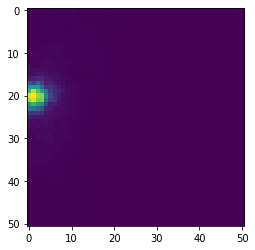

In [328]:
a = true_label.to('cpu')
recons = generator2(a)

plt.imshow(recons[0].detach().squeeze().numpy())

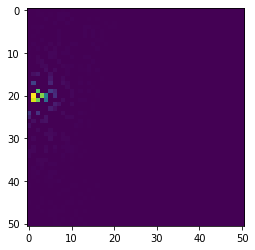

In [330]:
b = sample[0].to('cpu')
plt.imshow(b.detach().squeeze().numpy())

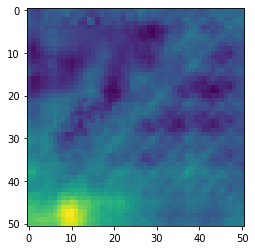

In [87]:
gen = torch.load('trained-models/gan/generator-gan-first'); z=64
gen = torch.load('trained-models/gan/gan-generator-2_z-16'); z=16

gen.eval()
gen.to('cpu')

a = torch.randn((1,z), dtype=torch.float32)
out = gen(a)
plt.imshow(np.log(out.detach().squeeze().numpy()))



## linear Interpolation in the latent space

In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# generator2.eval()
# generator2 = generator2.to('cpu')
generator.eval()
generator = generator.to('cpu')

In [41]:
def plot_multiple(images, n, dim, cmap):
    """
    :param arr images:          An array of images stored as a numpy array
    :param int n:               The width and height of the plot in terms of images
    :param tuple dim:           The dimension of the images
    :param str cmap:            The colourmap to be used by pyplot

    :return:                    Nothing

    Function used to plot multiple images in one single plot
    """
    # unpack the image dimensions
    z_dim, x_dim, y_dim = dim

    # if image is grayscale
    if (z_dim == 1):
        # initialize some limits on x&y
        x_limit = np.linspace(-2, 2, n)
        y_limit = np.linspace(-2, 2, n)

        # initialize the final combined image
        empty = np.empty((x_dim*n, y_dim*n))

        current = 0
        for i, zi in enumerate(x_limit):
            for j, pi in enumerate(y_limit):
                # each image insert it into a subsection of the final image
                empty[(n-i-1)*x_dim:(n-i)*x_dim, j*y_dim:(j+1)*y_dim] = images[current][0]
                current+=1

        plt.figure(figsize=(8, 10))

        x,y = np.meshgrid(x_limit, y_limit)
        plt.imshow(empty, origin="upper", cmap=cmap)
        plt.grid(False)
        plt.show()

    # if the image is rgb
    elif (z_dim == 3):
        # initialize some limits on x&y
        x_limit = np.linspace(-2, 2, n)
        y_limit = np.linspace(-2, 2, n)

        # initialize the final combined image (now with one more dim)
        empty = np.empty((x_dim*n, y_dim*n, 3))

        current = 0
        for i, zi in enumerate(x_limit):
            for j, pi in enumerate(y_limit):
                # flatten the image
                curr_img = images[current].ravel()
                # reshape it into the correct shape for pyplot
                curr_img = np.reshape(curr_img, (x_dim, y_dim, z_dim), order='F')
                # rotate it by 270 degrees
                curr_img = np.rot90(curr_img, 3)

                # insert it into a subsection of the final image
                empty[(n-i-1)*x_dim:(n-i)*x_dim, j*y_dim:(j+1)*y_dim] = curr_img
                current+=1

        plt.figure(figsize=(8, 10))

        x,y = np.meshgrid(x_limit, y_limit)
        plt.imshow(empty, origin="upper", cmap=cmap)
        plt.grid(False)
        plt.show()

def plot_images(images):
    if len(images)==0:
        return
    x_dim = images[0][0].shape[0]
    y_dim = images[0][0].shape[1]
    m = len(images)
    n = len(images[0])
    empty = np.empty((x_dim*m, y_dim*n))
    for i in range(m):
        for j in range(n):
            empty[(i)*x_dim:(i+1)*x_dim, j*y_dim:(j+1)*y_dim] = images[i][j]
    
    plt.figure(figsize=(8, 10))
    plt.imshow(empty, origin="upper")
    plt.grid(False)
    plt.show()

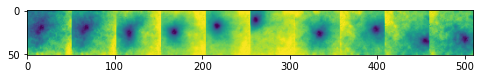

In [62]:
import numpy as np
m = 10
n = 1

images = []
step = 1.0/m

z_dim = 64
for j in range(n):
    p1 = torch.randn((1,64), dtype=torch.float32)
    p2 = torch.randn((1,64), dtype=torch.float32)

    new = []
    for i in range(m):
        sample = p1 + i*step*(p2-p1)
        out = generator(sample)
        new.append((out.detach().squeeze().numpy()))
    
    images.append(new)    
plot_images(images)

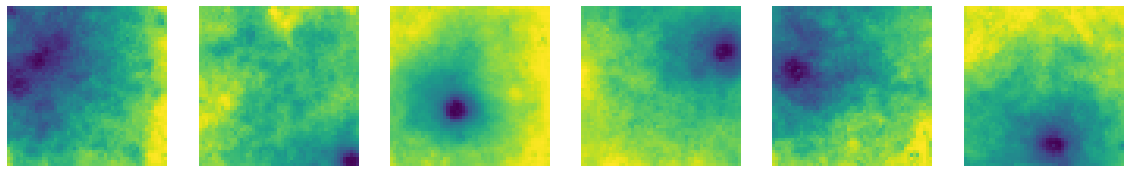

In [65]:
# plot images in gan range

fig, axes = plt.subplots(1,6, figsize=(20,20))
for i in range(6):
    p1 = torch.randn((1,64), dtype=torch.float32)
    out = generator(p1)
    
    axes[i].imshow(out.detach().squeeze().numpy())
    axes[i].axis('off')

In [119]:
generator2

Generator(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): UnFlatten()
    (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): ConvTranspose2d(16, 2, kernel_size=(4, 4), stride=(2, 2))
    (15): BatchNorm2d(2, eps=1e-05, m

In [136]:
for param in generator2.parameters():
    print(param.shape)

torch.Size([128, 64])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 4, 4])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 32, 4, 4])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 16, 4, 4])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16, 2, 4, 4])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([1, 2, 4, 4])
torch.Size([1])


In [139]:
next(generator2.parameters()).shape[0]

128

In [134]:
a.shape

torch.Size([128, 64])

In [ ]:
generator

In [88]:
a = torch.randn((1,64), dtype=torch.float32)
 = torch.randn((1,64), dtype=torch.float32)

import matplotlib.pyplot as plt
import numpy as np

generator.to('cpu')
generator.eval()
img = generator(a)
plt.imshow(np.log(img.detach().squeeze().numpy()))

TypeError: can't multiply sequence by non-int of type 'float'

In [69]:
torch.save(generator, 'trained-models/generator-gan-first')

In [4]:
q = torch.rand((5,10), dtype=torch.float32)
a = torch.randn_like(q)

In [10]:
q.shape[0]

5

In [6]:
a.shape

torch.Size([5, 10])

In [8]:
a.dtype

torch.float32